# EV Charging Customer Segmentation - draft version
A work of ***dataslays*** - your trustful partner for data science projects

<div class="alert alert-block alert-info">
Hello, I'm My, the data scientist of Dataslays responsible for this project. 

Before going through the content, I have some remarks for you. 

* This notebook serves as a comprehensive, preliminary documentation of all experiments/analyses I conducted during our clustering project. Therefore you can expect a lot of textual explanations which could aid you with understanding the methodology behind better if you are interested to dive deeper into the technical aspect.

* If you look for more condensed version with final results, please refer to the final notebook (final.ipynb).

* Although this is only the draft, I still want it to be as structured and organized as possible so that everyone who is interested can still follow the content easily.
</div>

### **Table of Contents**

[0. Introduction](#0-introduction)

[1. The Data](#1-the-data)

[2. Initial Data Analysis](#2-initial-data-analysis)

[3. Preprocessing](#3-preprocessing)

[4. Exploratory Data Analysis: Statistical Properties](#4-exploratory-data-analysis-statistical-properties)

[5. Dimensionality Reduction](#5-dimensionality-reduction)

[6. Exploratory Data Analysis: Clustering](#6-exploratory-data-analysis-clustering)

[7. Early Conclusions](#7-early-conclusions)

# 0. Introduction

## 0.1. Client requirements and expectations

> **WHY?**

You as a charging operation company, which is present on the market for only five years, has expressed the need and will of exploring and understanding your customer base using advanced data science methods

> **WHEN**

The project pitch was successfully conducted on April 17, 2025. The result is expected to be presented on May 18, 2025.

> **WHO?**

You company has chosen us dataslays as your partner for executing this project. We as company with more than five years experience helping multiple companies on their data science journey can ensure the success.   


> **WHAT?** 

* The specific task is customer segmentation: identify and analyze different EV
charging customer groups and their behaviours based on historical transaction data.

* So the clusters should have intepretable characteristics. 

* Each customer included in the experiment should be assigned to a specific cluster so that you can take this to run further experiments.

The number of clusters is not strictly predefined and the clusters don't have to be perfectly separatable/distinguiable from each others. 

=> This is usually not crucial for your business operations. The goal is rather to have a better understanding of customer needs. Your company have defined some customer personas during market research phase and want to used the results from this project to verify and expand the personas. This is used mostly for sales and marketing purposes such as running campaign, targeted incentives and tailored pricing models. 

> **HOW?**

The data is given directly to me without further constraint (more details in chapter 1. The Data)
We will explore the data with both statistical and clustering methods to find out the best approach in your case.


## 0.2. Setup

In this project, we'll use Python as programming language with these main packages.

In [1]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical arrays
import matplotlib.pyplot as plt  # Data plotting
import seaborn as sns  # Enhanced visualizations

# make pandas display ALL columns of a dataframe
pd.options.display.max_columns = None

from pca import pca  # Dimensional reduction
from sklearn.cluster import KMeans  # Centroid-based clustering
from sklearn.cluster import DBSCAN  # Density-based clustering
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering

# Keep output clean by hiding unnecessary warning messages.
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducible experiment
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import random
random.seed(RANDOM_SEED)

Further packages will be added later in the specific sections.

# 1. The Data

<div class="alert alert-block alert-info">

Several options of dataset were introduced. Based on our initial investigation, the one we choose here is perfect for an PoC in our opinion although it doesn't include all possible features.

The chosen dataset was collected for the purpose of another [study](https://www.nature.com/articles/s41597-024-02942-9), which captures all charging sessions during your company’s annual commercial operation period (from Sept 30, 2021 to Sept 30, 2022). 

It can be directly downloaded from [this site](https://figshare.com/articles/dataset/A_dataset_for_multi-faceted_analysis_of_electric_vehicle_charging_transactions/22495141/1) with Creative Commons Licenses by 4.0 

Now I'll import the raw data so we can take an inital look at it and I'll explain why it is particularly well-suited for clustering analysis.

</div>

In [2]:
raw_data = pd.read_csv('ChargingRecords.csv')
raw_data

UserID  ChargerID  ChargerCompany            Location  ChargerType  \
0           0          1               1               hotel            0   
1           0          1               1               hotel            0   
2           0          1               1               hotel            0   
3           0          1               1               hotel            0   
4           0          1               1               hotel            0   
...       ...        ...             ...                 ...          ...   
72851    2155       2649               0  public institution            0   
72852    2379       2670               0         sightseeing            1   
72853    2388       2670               0         sightseeing            1   
72854    2388       2671               0             company            1   
72855    2388       2671               0             company            1   

         StartDay StartTime      EndDay   EndTime     StartDatetime  \
0      2022-09-15  20:54:02  2022-09-15  23:59:13  2022-09-15 20:54   
1      2022-09-14  20:01:05  2022-09-14  21:31:04  2022-09-14 20:01   
2      2022-09-14  18:54:30  2022-09-14  19:54:29  2022-09-14 18:54   
3      2022-09-29  18:32:51  2022-09-30   0:16:42  2022-09-29 18:32   
4      2022-09-25  19:30:15  2022-09-26   0:30:14  2022-09-25 19:30   
...           ...       ...         ...       ...               ...   
72851  2022-01-27   9:54:44  2022-01-27   9:58:57   2022-01-27 9:54   
72852  2021-10-31  14:52:11  2021-10-31  15:20:28  2021-10-31 14:52   
72853  2021-10-03  13:52:14  2021-10-03  14:32:13  2021-10-03 13:52   
72854  2021-11-18  11:37:44  2021-11-18  11:45:37  2021-11-18 11:37   
72855  2021-10-30  17:29:02  2021-10-30  17:36:47  2021-10-30 17:29   

            EndDatetime  Duration  Demand  
0      2022-09-15 23:59       185   20.36  
1      2022-09-14 21:31        90   10.19  
2      2022-09-14 19:54        60    6.78  
3       2022-09-30 0:16       344   37.65  
4       2022-09-26 0:30       300   33.81  
...                 ...       ...     ...  
72851   2022-01-27 9:58         4    0.50  
72852  2021-10-31 15:20        28   16.53  
72853  2021-10-03 14:32        40   12.20  
72854  2021-11-18 11:45         8    3.80  
72855  2021-10-30 17:36         8    3.67  

[72856 rows x 13 columns]

<div class="alert alert-block alert-info">

Although this dataset is session-based, we can still easily group the sessions per user and calculate aggregated values. The data containes all sessions, as our goal is customer segmentation, group each customer to clusters based on similar behaviours => I need to group data per userID and experiment with new features via feature engineering. 

Some key characteristics:

1. The dataset has a substantial size: With a total of 72,856 sessions contributed by 2,337 EV users and 2,119 chargers => this is a large enough sample for effective clustering

2. Diverse dimensions: Including a variety of features (e.g. duration, demand, location etc.), covering both numerical and categorical data. => allowing various analytical and feature engineering approaches

3. High data quality and usability: Well-maintained, featuring no missing values and collected though a transparent and scientifically validated process. => ensuring reliability and clarity

</div>

<div class="alert alert-block alert-info">
Below is the table which shows the summary of the raw data features, 

The original table can be taken from the study paper.

</div>

Table 1: Feature description of raw data

| Column         | Description                                                                           | Data type  |           
|----------------|---------------------------------------------------------------------------------------|-------------|        
| UserID         | User ID; own members (1–2337) and other company’s members/non-members (0)             | Numerical   | 
| ChargerID      | Charger ID                                                                            | Numerical   |
| ChargerCompany | Categorization by charger company’s type: own company (1), other company (0)          | Categorical |
| Location       | Installed location of charger; location type (accommodation, apartment, bus garage, camping, company, golf, hotel, market, public area, public institution, public parking lot, resort, restaurant, and sightseeing)                | Categorical | 
| ChargerType    | Categorization by charging speed; fast charger (1) and slow charger (0)               | Categorical | 
| StartDay       | Start date of connection between EV and charger (YYYY-MM-DD)                          | Datetime   | 
| StartTime      | Start time of connection between EV and charger (HH:MM:SS)                            | Datetime   | 
| EndDay         | End date of connection between EV and charger (YYYY-MM-DD)                            | Datetime   | 
| EndTime        | End time of connection between EV and charger (HH:MM:SS)                              | Datetime   | 
| StartDatetime  | Start date time of connection between EV and charger (YYYY-MM-DD HH:MM:SS)            | Datetime   | 
| EndDatetime    | End date time of connection between EV and charger (YYYY-MM-DD HH:MM:SS)              | Datetime   | 
| Duration       | Charger connection duration (unit: minute)                                            | Numerical-Continuous   | 
| Demand         | Amount of power charged to the EV (unit: kWh)                                         | Numerical-Continuous   | 

<div class="alert alert-block alert-info">
First notes on the features:

* EV users with IDs recorded as 0 refer to customers in this study who are not subscribed to your company => they belong to an cluster unknown and therefore will be excluded from the analysis. (**To-do 1**)
</div>

# 2. Initial Data Analysis

<div class="alert alert-block alert-info">
Now we can look further into the data entries.
</div>

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72856 entries, 0 to 72855
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UserID          72856 non-null  int64  
 1   ChargerID       72856 non-null  int64  
 2   ChargerCompany  72856 non-null  int64  
 3   Location        72856 non-null  object 
 4   ChargerType     72856 non-null  int64  
 5   StartDay        72856 non-null  object 
 6   StartTime       72856 non-null  object 
 7   EndDay          72856 non-null  object 
 8   EndTime         72856 non-null  object 
 9   StartDatetime   72856 non-null  object 
 10  EndDatetime     72856 non-null  object 
 11  Duration        72856 non-null  int64  
 12  Demand          72856 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 7.2+ MB


<div class="alert alert-block alert-info">

As you can see, although the dataset looks clean and doesn't have missing values, the dtype of some columns are not how we want them ideally: StartDay, StartTime, EndDay, EndTime, StartDatetime, EndDatetime have type object, while they should have datetime type => change this (**To-do 2**)
</div>

In [4]:
raw_data.describe().round(2)

UserID  ChargerID  ChargerCompany  ChargerType  Duration    Demand
count  72856.00   72856.00        72856.00     72856.00  72856.00  72856.00
mean     338.16     525.49            0.63         0.21    151.19     17.44
std      553.97     569.54            0.48         0.40    146.43     13.49
min        0.00       1.00            0.00         0.00    -29.00      0.01
25%        0.00     107.00            0.00         0.00     40.00      7.53
50%       62.00     301.00            1.00         0.00    112.00     14.10
75%      407.00     738.00            1.00         0.00    202.00     23.20
max     2501.00    2671.00            1.00         1.00   1573.00     97.00

<div class="alert alert-block alert-info">

There seems to be also some further issues with the capture of data too.

There are some negative values in the Duration columns. Upon investigation we can see that the system seems to mess up the start and endtime here. It only happened in the location market and to several users. They are not UserID 0. According to our discussion lately you confirmed this and we agreed to change the duration to positive number for the entries below and swap the time (**To-do 3**)
</div>

In [5]:
raw_data[raw_data['Duration'] < 0]

UserID  ChargerID  ChargerCompany Location  ChargerType    StartDay  \
55422    1403        775               0   market            1  2022-02-15   
55425    1403        775               0   market            1  2022-02-24   
55427    1403        775               0   market            1  2022-01-17   
55455      37        778               0   market            1  2022-04-29   
55457      55        778               0   market            1  2022-05-07   
55458      74        778               0   market            1  2022-04-29   
55459      92        778               0   market            1  2022-03-27   
55460      92        778               0   market            1  2022-02-05   
55464     266        778               0   market            1  2022-05-08   
55465     326        778               0   market            1  2022-01-09   
55469    1768        778               0   market            1  2022-04-07   
57800      55        922               0   market            1  2022-04-09   
57802    1474        922               0   market            1  2022-05-05   
57803    1766        922               0   market            1  2022-04-17   
63503    1575       1229               0   market            1  2022-03-19   
63504    1575       1229               0   market            1  2022-03-22   
65029     140       1347               0   market            1  2022-03-30   

      StartTime      EndDay   EndTime     StartDatetime       EndDatetime  \
55422  15:04:54  2022-02-15  14:35:36  2022-02-15 15:04  2022-02-15 14:35   
55425  14:27:44  2022-02-24  14:18:35  2022-02-24 14:27  2022-02-24 14:18   
55427  14:47:03  2022-01-17  14:39:24  2022-01-17 14:47  2022-01-17 14:39   
55455  18:58:46  2022-04-29  18:52:20  2022-04-29 18:58  2022-04-29 18:52   
55457  16:24:20  2022-05-07  16:03:03  2022-05-07 16:24  2022-05-07 16:03   
55458  15:48:51  2022-04-29  15:43:07  2022-04-29 15:48  2022-04-29 15:43   
55459  15:17:53  2022-03-27  15:10:38  2022-03-27 15:17  2022-03-27 15:10   
55460  18:52:39  2022-02-05  18:50:15  2022-02-05 18:52  2022-02-05 18:50   
55464  12:02:28  2022-05-08  11:42:02  2022-05-08 12:02  2022-05-08 11:42   
55465  14:29:15  2022-01-09  14:20:28  2022-01-09 14:29  2022-01-09 14:20   
55469  12:25:32  2022-04-07  12:12:11  2022-04-07 12:25  2022-04-07 12:12   
57800  11:29:43  2022-04-09  11:23:46  2022-04-09 11:29  2022-04-09 11:23   
57802  17:48:01  2022-05-05  17:31:39  2022-05-05 17:48  2022-05-05 17:31   
57803  18:59:44  2022-04-17  18:54:21  2022-04-17 18:59  2022-04-17 18:54   
63503  15:32:26  2022-03-19  15:24:33  2022-03-19 15:32  2022-03-19 15:24   
63504  17:19:11  2022-03-22  16:55:39  2022-03-22 17:19  2022-03-22 16:55   
65029  13:20:34  2022-03-30  13:04:57  2022-03-30 13:20  2022-03-30 13:04   

       Duration  Demand  
55422       -29   11.68  
55425        -9   34.56  
55427        -8   17.77  
55455        -6   31.90  
55457       -21   13.39  
55458        -6   19.36  
55459        -7   20.99  
55460        -2   31.59  
55464       -20    3.28  
55465        -9   31.68  
55469       -13   53.24  
57800        -6   41.08  
57802       -16   51.99  
57803        -5   15.04  
63503        -8   37.97  
63504       -24   25.49  
65029       -16   23.10

<div class="alert alert-block alert-info">

We also agreed to only keep sessions which have duration of more than 10 minutes. 
The sessions below 10 are often the case where user just try the connection or sometimes connect to the charger but forgot to start the charging.  (**To-do 4**)
</div>

In [6]:
raw_data[raw_data['Duration'] < 10]

UserID  ChargerID  ChargerCompany            Location  ChargerType  \
15          0          1               1               hotel            0   
32          0          1               1               hotel            0   
33          0          1               1               hotel            0   
47          0          1               1               hotel            0   
50          0          1               1               hotel            0   
...       ...        ...             ...                 ...          ...   
72754    1731       2584               0             company            0   
72768    2092       2594               0  public parking lot            1   
72851    2155       2649               0  public institution            0   
72854    2388       2671               0             company            1   
72855    2388       2671               0             company            1   

         StartDay StartTime      EndDay   EndTime     StartDatetime  \
15     2022-08-19  17:10:57  2022-08-19  19:10:57  2022-08-19 17:10   
32     2022-06-10  18:52:53  2022-06-10  18:52:53  2022-06-10 18:52   
33     2022-06-10  19:14:26  2022-06-10  19:14:26  2022-06-10 19:14   
47     2022-04-14  20:41:59  2022-04-14  20:50:52  2022-04-14 20:41   
50     2022-03-01  12:45:35  2022-03-01  13:34:38  2022-03-01 12:45   
...           ...       ...         ...       ...               ...   
72754  2022-01-08  15:42:14  2022-01-08  15:46:23  2022-01-08 15:42   
72768  2022-01-28  16:34:31  2022-01-28  16:40:26  2022-01-28 16:34   
72851  2022-01-27   9:54:44  2022-01-27   9:58:57   2022-01-27 9:54   
72854  2021-11-18  11:37:44  2021-11-18  11:45:37  2021-11-18 11:37   
72855  2021-10-30  17:29:02  2021-10-30  17:36:47  2021-10-30 17:29   

            EndDatetime  Duration  Demand  
15     2022-08-19 19:10         4   12.42  
32     2022-06-10 18:52         0    0.54  
33     2022-06-10 19:14         0    0.55  
47     2022-04-14 20:50         9    0.96  
50     2022-03-01 13:34         0    5.58  
...                 ...       ...     ...  
72754  2022-01-08 15:46         4    0.39  
72768  2022-01-28 16:40         6    2.76  
72851   2022-01-27 9:58         4    0.50  
72854  2021-11-18 11:45         8    3.80  
72855  2021-10-30 17:36         8    3.67  

[3662 rows x 13 columns]

<div class="alert alert-block alert-info">

Here we can also see that there is a variety of charging times, distribution. There are clearly users that charges a lot  and user that charges very little (they use the service occationally, can be because they have their own charger and only charge at home) => only include users who charges at least 10 sessions during the observed time (**To-do 5**)
</div>

In [7]:
raw_data['UserID'].value_counts()

UserID
0       31553
31        353
95        348
179       341
40        323
        ...  
1680        1
2157        1
1541        1
2182        1
1582        1
Name: count, Length: 2337, dtype: int64

In [8]:
raw_data['UserID'].value_counts().unique()

array([31553,   353,   348,   341,   323,   300,   279,   245,   236,
         217,   216,   215,   204,   203,   200,   199,   196,   195,
         192,   191,   185,   181,   180,   178,   174,   171,   169,
         167,   166,   163,   160,   157,   154,   153,   149,   146,
         144,   140,   139,   138,   137,   136,   134,   132,   131,
         130,   128,   126,   125,   123,   122,   121,   120,   119,
         118,   113,   112,   111,   109,   108,   107,   106,   105,
         103,   101,   100,    98,    97,    95,    94,    93,    92,
          91,    90,    89,    88,    87,    86,    85,    84,    83,
          82,    81,    80,    79,    78,    77,    76,    75,    74,
          73,    72,    71,    70,    68,    67,    66,    65,    64,
          63,    62,    61,    60,    59,    58,    57,    56,    55,
          54,    53,    52,    51,    50,    49,    48,    47,    46,
          45,    44,    43,    42,    41,    40,    39,    38,    37,
          36,    35,

# 3. Preprocessing

## 3.1. Clean the data

In [9]:
# Drop unsubscribed user with UserID = 0 (To-do 1)
raw_data = raw_data[raw_data['UserID'] > 0]
raw_data

UserID  ChargerID  ChargerCompany            Location  ChargerType  \
127        14          1               1               hotel            0   
137       156          1               1               hotel            0   
142       246          1               1               hotel            0   
155       330          1               1               hotel            0   
166       479          1               1               hotel            0   
...       ...        ...             ...                 ...          ...   
72851    2155       2649               0  public institution            0   
72852    2379       2670               0         sightseeing            1   
72853    2388       2670               0         sightseeing            1   
72854    2388       2671               0             company            1   
72855    2388       2671               0             company            1   

         StartDay StartTime      EndDay   EndTime     StartDatetime  \
127    2022-08-16  11:59:23  2022-08-16  14:20:45  2022-08-16 11:59   
137    2022-08-07   9:16:19  2022-08-07  11:11:01   2022-08-07 9:16   
142    2022-09-07  16:24:07  2022-09-07  18:08:53  2022-09-07 16:24   
155    2022-03-20  13:26:23  2022-03-20  14:02:21  2022-03-20 13:26   
166    2022-05-28  11:38:04  2022-05-28  11:58:29  2022-05-28 11:38   
...           ...       ...         ...       ...               ...   
72851  2022-01-27   9:54:44  2022-01-27   9:58:57   2022-01-27 9:54   
72852  2021-10-31  14:52:11  2021-10-31  15:20:28  2021-10-31 14:52   
72853  2021-10-03  13:52:14  2021-10-03  14:32:13  2021-10-03 13:52   
72854  2021-11-18  11:37:44  2021-11-18  11:45:37  2021-11-18 11:37   
72855  2021-10-30  17:29:02  2021-10-30  17:36:47  2021-10-30 17:29   

            EndDatetime  Duration  Demand  
127    2022-08-16 14:20       141   15.86  
137    2022-08-07 11:11       115    6.25  
142    2022-09-07 18:08       105   11.15  
155    2022-03-20 14:02        36    4.10  
166    2022-05-28 11:58        20    2.27  
...                 ...       ...     ...  
72851   2022-01-27 9:58         4    0.50  
72852  2021-10-31 15:20        28   16.53  
72853  2021-10-03 14:32        40   12.20  
72854  2021-11-18 11:45         8    3.80  
72855  2021-10-30 17:36         8    3.67  

[41303 rows x 13 columns]

In [10]:
# Transform Date columns to Datetime (To-do 2)
datetime_columns = ['StartDay', 'EndDay', 'StartTime', 'EndTime', 'StartDatetime', 'EndDatetime']
raw_data[datetime_columns] = raw_data[datetime_columns].apply(pd.to_datetime)

In [11]:
# Change the duration to positive number for the negative duration entries (To-do 3)
neg_duration_indices = raw_data[raw_data['Duration'] < 0].index
print(neg_duration_indices)

raw_data.loc[neg_duration_indices, 'Duration'] *= -1


# Swap 'StartDay' with 'EndDay'
raw_data.loc[neg_duration_indices, ['StartDay', 'EndDay']] = raw_data.loc[neg_duration_indices, ['EndDay', 'StartDay']].values

# Swap 'StartTime' with 'EndTime'
raw_data.loc[neg_duration_indices, ['StartTime', 'EndTime']] = raw_data.loc[neg_duration_indices, ['EndTime', 'StartTime']].values

# Swap 'StartDatetime' with 'EndDatetime'
raw_data.loc[neg_duration_indices, ['StartDatetime', 'EndDatetime']] = raw_data.loc[neg_duration_indices, ['EndDatetime', 'StartDatetime']].values


Index([55422, 55425, 55427, 55455, 55457, 55458, 55459, 55460, 55464, 55465,
       55469, 57800, 57802, 57803, 63503, 63504, 65029],
      dtype='int64')


In [12]:
# only keep sessions which have duration of more than 10 minutes. (To-do 4) 
raw_data = raw_data[raw_data['Duration'] >= 10]

## 3.2. Group data per user and feature engineering (To do 5)

<div class="alert alert-block alert-info">

When it comes to EV charging sessions, several data points and insights are particularly valuable for understanding user behavior:

#### Duration and Demand Analysis
- **Total charging sessions per year (session_count):** This fundamental metric indicates the frequency of service usage. A high session count suggests frequent use, while a low count could indicate occasional or sporadic usage.

- **Total duration (in minutes):** Understanding the accumulated time spent charging provides insights into the user's dependency on the service, helping to identify frequent versus infrequent users.

- **Average session duration and standard deviation of duration:** These metrics divulge typical charging behaviors and consistency in session length. Users with high variation might have unpredictable schedules, while consistent users might be more stable.

- **Total demand (in kWh)** Evaluating the total energy requirement helps in discerning power consumption habits. 
- **Average demand per session:** can highlight whether users typically need quick top-ups or longer charges.
- **Standard deviation in demand:** This indicates variability in energy needs across sessions—valuable for recognizing consistent versus fluctuating charger demand.

#### Location Preferences
- **Number of unique locations:** Understanding the geographical diversity of charging locations reveals mobility patterns and user flexibility. Users charging at many locations might be more mobile, while single-location users might indicate home-based usage or work commutes.


#### Charging Preferences (Ratios)
- **Charger Preference Ratio:** Observes whether users predominantly utilize fast or slow chargers, which influence their charging speed expectations.

- **Charger Company Preference Ratio:** Assesses loyalty or preference toward specific charger providers, indicative of brand affinity or service satisfaction.

- **Night Charger Ratio and Weekend Charger Ratio:** These ratios reflect charging time preferences, providing insights into user schedules. Nighttime or weekend charging may suggest personal vehicle use, while daytime or weekday charging might indicate work-related use.
</div>

In [13]:
data_pre_transform_scale = raw_data.groupby('UserID').agg({
    'UserID': 'count',
    'Duration': ['sum', 'mean', 'std'],
    'Demand': ['sum', 'mean', 'std'],
    'Location': 'nunique'
})

data_pre_transform_scale.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_pre_transform_scale.columns]

In [14]:
data_pre_transform_scale = data_pre_transform_scale.rename(columns={
    'UserID_count': 'session_count',
    'Duration_sum': 'total_duration',
    'Duration_mean': 'avg_session_duration',
    'Duration_std': 'std_duration',
    'Demand_sum': 'total_demand',
    'Demand_mean': 'avg_demand_per_session',
    'Demand_std': 'std_demand',
    'Location_nunique': 'unique_locations'
})

In [15]:
data_pre_transform_scale

session_count  total_duration  avg_session_duration  std_duration  \
UserID                                                                      
1                 108           36429            337.305556    140.521755   
2                  39            7020            180.000000     97.696361   
3                  34            5862            172.411765    133.319647   
4                 168           27569            164.101190     95.541297   
5                   2             840            420.000000    267.286363   
...               ...             ...                   ...           ...   
2497                2             348            174.000000     91.923882   
2498                2             270            135.000000     21.213203   
2499                1              76             76.000000           NaN   
2500                1              23             23.000000           NaN   
2501                1              97             97.000000           NaN   

        total_demand  avg_demand_per_session  std_demand  unique_locations  
UserID                                                                      
1            3912.50               36.226852   14.523034                 4  
2             806.92               20.690256   11.282258                 1  
3             797.31               23.450294   10.699674                 7  
4            2714.35               16.156845    7.302607                 1  
5              29.00               14.500000   12.303658                 2  
...              ...                     ...         ...               ...  
2497           38.40               19.200000    9.220672                 2  
2498           30.80               15.400000    2.687006                 1  
2499            4.60                4.600000         NaN                 1  
2500            2.56                2.560000         NaN                 1  
2501           19.26               19.260000         NaN                 1  

[2284 rows x 8 columns]

In [16]:
data_pre_transform_scale = data_pre_transform_scale[data_pre_transform_scale['session_count'] >= 10]
data_pre_transform_scale.shape

(686, 8)

In [17]:
def calc_usage_counts(raw_data, data, col_name, target_col, val):
    data[target_col] = raw_data[raw_data[col_name] == val].groupby('UserID')[col_name].count().fillna(0).astype(int)
    return data

def calc_pref_ratio(data, target_cols, reference_cols, ratio_col):
    data[ratio_col] = data[target_cols].sum(axis=1) / data[reference_cols].sum(axis=1)
    return data

In [18]:
# Fast and Slow charger usage counts
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerType', 'fast_charger_uses', 1)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerType', 'slow_charger_uses', 0)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['fast_charger_uses'], ['fast_charger_uses', 'slow_charger_uses'], 'fast_charger_ratio')

# Charger company usage counts
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerCompany', 'own_company_uses', 1)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerCompany', 'other_company_uses', 0)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['own_company_uses'], ['own_company_uses', 'other_company_uses'], 'own_company_ratio')


In [19]:
# Night and Day charger usage counts
raw_data['is_night_charging'] = raw_data['StartDatetime'].dt.hour.between(20, 23) | raw_data['StartDatetime'].dt.hour.between(0, 6)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_night_charging', 'night_charges', True)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_night_charging', 'day_charges', False)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['night_charges'], ['night_charges', 'day_charges'], 'night_ratio')

# Weekend and Weekday charger usage counts
raw_data['is_weekend'] = raw_data['StartDatetime'].dt.dayofweek >= 5
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_weekend', 'weekend_charges', True)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_weekend', 'weekday_charges', False)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['weekend_charges'], ['weekend_charges', 'weekday_charges'], 'weekend_ratio')

In [20]:
data_pre_transform_scale

session_count  total_duration  avg_session_duration  std_duration  \
UserID                                                                      
1                 108           36429            337.305556    140.521755   
2                  39            7020            180.000000     97.696361   
3                  34            5862            172.411765    133.319647   
4                 168           27569            164.101190     95.541297   
6                  53           15367            289.943396    190.851373   
...               ...             ...                   ...           ...   
2356               39            6295            161.410256     47.332373   
2388               12             563             46.916667     34.739180   
2393               10            1509            150.900000     30.895703   
2421               19            3890            204.736842     81.338007   
2464               10            1045            104.500000     30.562322   

        total_demand  avg_demand_per_session  std_demand  unique_locations  \
UserID                                                                       
1            3912.50               36.226852   14.523034                 4   
2             806.92               20.690256   11.282258                 1   
3             797.31               23.450294   10.699674                 7   
4            2714.35               16.156845    7.302607                 1   
6            2009.16               37.908679   16.958805                 4   
...              ...                     ...         ...               ...   
2356          304.79                7.815128    2.055936                 2   
2388          218.83               18.235833    4.779984                 4   
2393           62.58                6.258000    1.363205                 1   
2421          466.68               24.562105    6.418442                 2   
2464           45.59                4.559000    1.684072                 1   

        fast_charger_uses  slow_charger_uses  fast_charger_ratio  \
UserID                                                             
1                     NaN              108.0            0.000000   
2                     NaN               39.0            0.000000   
3                    12.0               22.0            0.352941   
4                     NaN              168.0            0.000000   
6                    14.0               39.0            0.264151   
...                   ...                ...                 ...   
2356                  NaN               39.0            0.000000   
2388                 11.0                1.0            0.916667   
2393                  NaN               10.0            0.000000   
2421                  2.0               17.0            0.105263   
2464                  NaN               10.0            0.000000   

        own_company_uses  other_company_uses  own_company_ratio  \
UserID                                                            
1                   93.0                15.0           0.861111   
2                   39.0                 NaN           1.000000   
3                   20.0                14.0           0.588235   
4                  147.0                21.0           0.875000   
6                   39.0                14.0           0.735849   
...                  ...                 ...                ...   
2356                38.0                 1.0           0.974359   
2388                 NaN                12.0           0.000000   
2393                10.0                 NaN           1.000000   
2421                17.0                 2.0           0.894737   
2464                 NaN                10.0           0.000000   

        night_charges  day_charges  night_ratio  weekend_charges  \
UserID                                                             
1                64.0         44.0     0.592593             26.0   
2                 2.0         

In [21]:
data_pre_transform_scale = data_pre_transform_scale[
    [
        'session_count', 
        'total_duration', 
        'total_demand', 
        'unique_locations',
        'avg_session_duration', 
        'avg_demand_per_session',
        'std_duration',
        'std_demand', 
        'fast_charger_ratio',
        'own_company_ratio', 
        'night_ratio', 
        'weekend_ratio'
    ]
]
data_pre_transform_scale.index.name = 'user_id'

In [22]:
data_pre_transform_scale.describe().round(2)

session_count  total_duration  total_demand  unique_locations  \
count         686.00          686.00        686.00            686.00   
mean           51.49         7803.68        977.57              3.90   
std            49.29        10693.55       1010.19              2.33   
min            10.00          278.00         33.75              1.00   
25%            19.00         1612.75        312.46              2.00   
50%            34.00         3883.00        632.31              4.00   
75%            66.00         9747.25       1309.35              5.75   
max           351.00        86232.00       9621.37             11.00   

       avg_session_duration  avg_demand_per_session  std_duration  std_demand  \
count                686.00                  686.00        686.00      686.00   
mean                 147.16                   19.94         84.51        8.49   
std                  117.97                   10.44         73.81        4.98   
min                   18.79                    2.25          0.00        0.50   
25%                   52.54                   11.91         28.57        4.36   
50%                  112.79                   18.24         61.96        7.57   
75%                  195.08                   26.15        121.52       11.99   
max                  719.10                   58.88        471.97       30.83   

       fast_charger_ratio  own_company_ratio  night_ratio  weekend_ratio  
count              686.00             686.00       686.00         686.00  
mean                 0.39               0.35         0.19           0.27  
std                  0.42               0.43         0.22           0.14  
min                  0.00               0.00         0.00           0.00  
25%                  0.00               0.00         0.02           0.18  
50%                  0.13               0.04         0.11           0.26  
75%                  0.89               0.91         0.28           0.35  
max                  1.00               1.00         1.00           0.94

In [23]:
def plot_histograms(data, figure_size=(20, 15), title_font_size=12, hspace=0.8, wspace=0.5, bins=20):
    plt.figure(figsize=figure_size)
    axes = data.hist(figsize=figure_size, bins=bins)
    
    for ax in axes.flatten():
        ax.title.set_fontsize(title_font_size)
        ax.grid(False)
        ax.spines['top'].set_visible(False)  
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='both', direction='out', length=6)
        
        # Set x-axis to start from 0
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(0, max(xmax, 0))  # Ensure 0 is included in the range

    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.tight_layout()
    plt.show()


<Figure size 2000x1500 with 0 Axes>

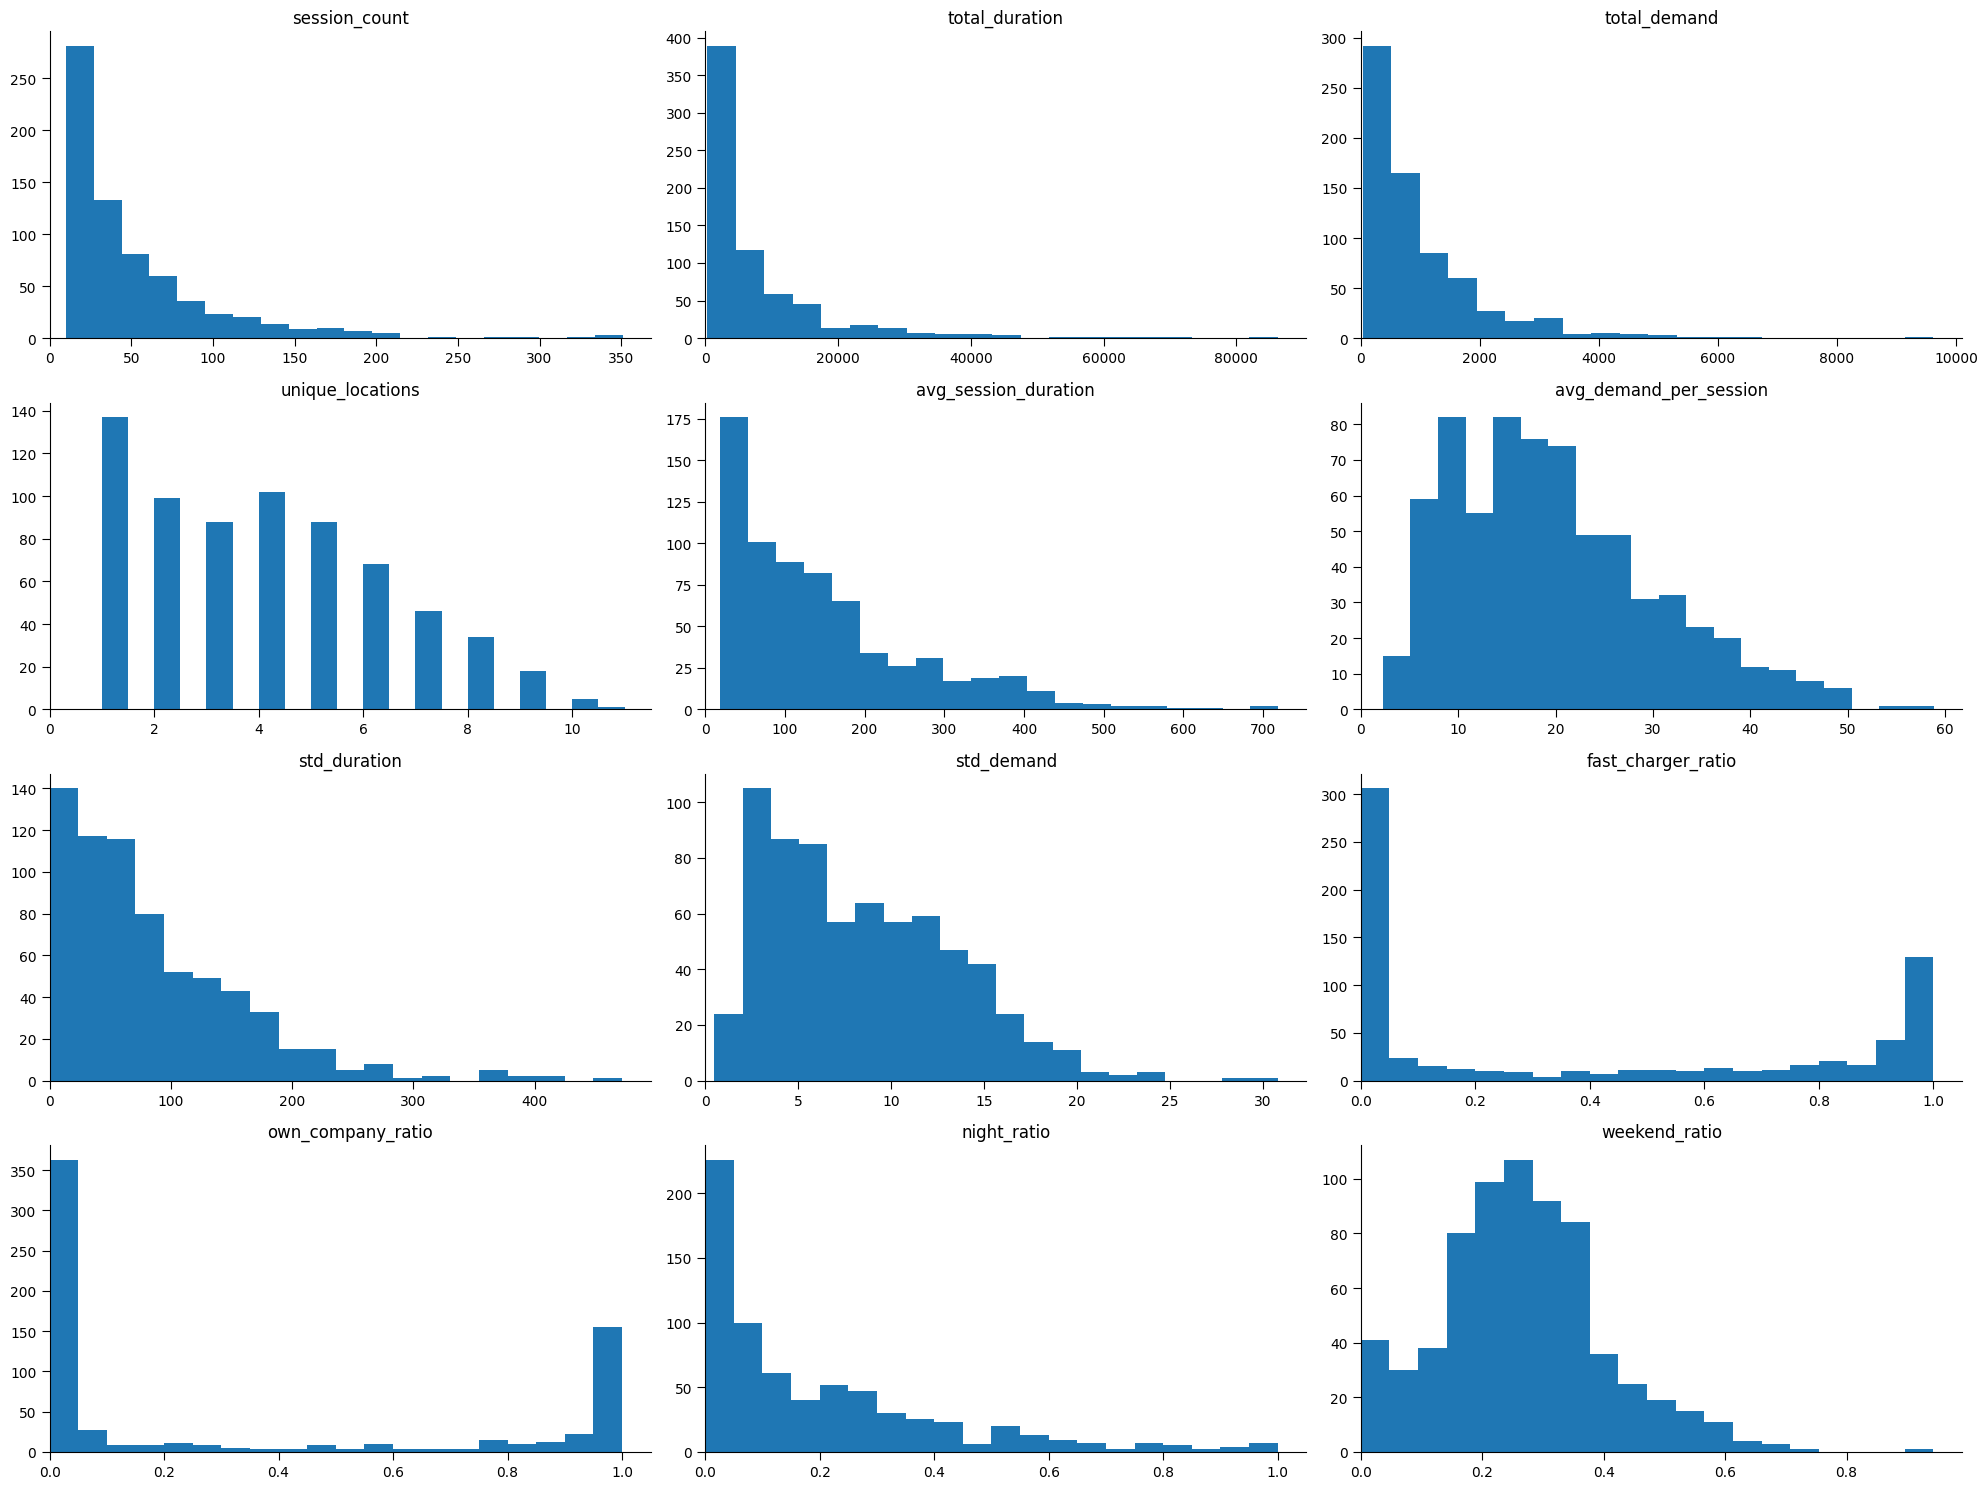

In [24]:
plot_histograms(data_pre_transform_scale)

In [25]:
def plot_boxplots(data):
    plt.figure(figsize=(12, 6))
    
    features_to_plot = data.columns
    n_subplots = len(features_to_plot)
    n_rows, n_cols = (2, 6)
    
    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(y=data[feature])
        plt.grid(False)
        plt.title(feature, fontsize=10, pad=10)
        plt.ylabel('')
        plt.yticks(fontsize=8)
        plt.tick_params(axis='y', which='both', direction='out', length=5)
        
        # Get current y axis limits
        ymin, ymax = plt.ylim()
        # If ymin is greater than 0, extend the axis to include 0
        if ymin > 0:
            plt.ylim(0, ymax)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=1)
    plt.show()


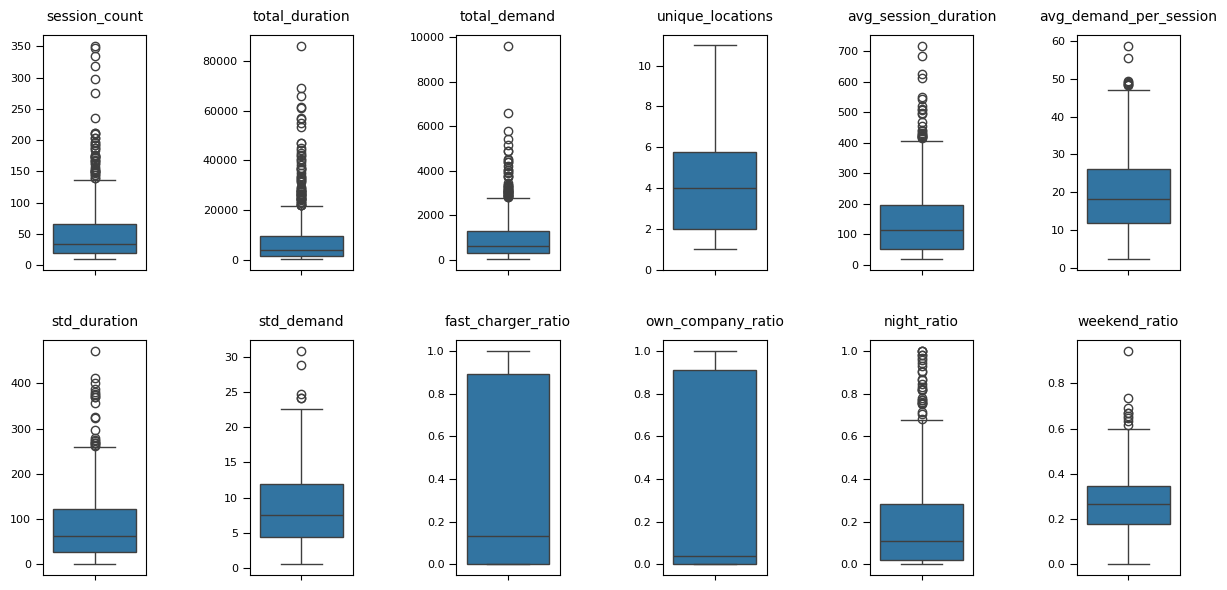

In [26]:
plot_boxplots(data_pre_transform_scale)

In [27]:
data_pre_transform_scale.shape

(686, 12)

<div class="alert alert-block alert-info">

We can see
* Significant outliers in most numerical features => I need to handle this (**To do 6**)
* Strong right-skewed distributions in many features (session_count, total_duration, total_demand, avg_session_duration) => (**To do 7**)
* Different value ranges across features (from 0-1 for ratios to 0-80,000+ for total_duration)
* Bimodal distributions in some ratio features (fast_charger_ratio, own_company_ratio)
</div>

## 3.3. Handle outliers (to do 6)

<div class="alert alert-block alert-info">

To handle outliers in our data, several methods can be employed, such as the Interquartile Range (IQR) method and the Z-Score. Additionally, clustering algorithms like DBSCAN and OPTICS are effective in managing outliers. However, for our dataset, I aim to address outliers upfront to reduce their impact on subsequent analyses such as K-means and HAC.

For our non-ratio features, I selected Isolation Forest, which is particularly suited for skewed or high-dimensional data.

* Random subsampling: Isolation Forest constructs numerous binary trees (isolation trees) by selecting features and split values randomly.

* Isolation path: Data points isolated quickly, resulting in a short path to become a leaf, are likely to be outliers.

* Scoring: Each data point receives an anomaly score based on the ease of isolation. A short path indicates a likely outlier, while a long path suggests normalcy.

Advantages:

* No distribution assumptions: It functions well with skewed histograms, similar to those in our dataset.

* Efficiency in high dimensions: Ideal for datasets with a large number of features, such as the 15+ features we have.

* Unsupervised approach: It does not require labeled data.

* Non-linear boundaries: Capable of identifying complex outlier patterns that might be missed by IQR or Z-score methods.
</div>

In [28]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(random_state=RANDOM_SEED) #using default parameters

non_ratio_features = ['session_count', 'total_duration', 'total_demand', 
               'avg_session_duration', 'std_duration', 'std_demand', 'avg_demand_per_session', 'unique_locations']


X = data_pre_transform_scale[non_ratio_features]
outliers = iso.fit_predict(X)
data_pre_transform_scale = data_pre_transform_scale[outliers == 1]


In [29]:
data_pre_transform_scale.shape

(579, 12)

107 outliers have been removed.

<Figure size 2000x1500 with 0 Axes>

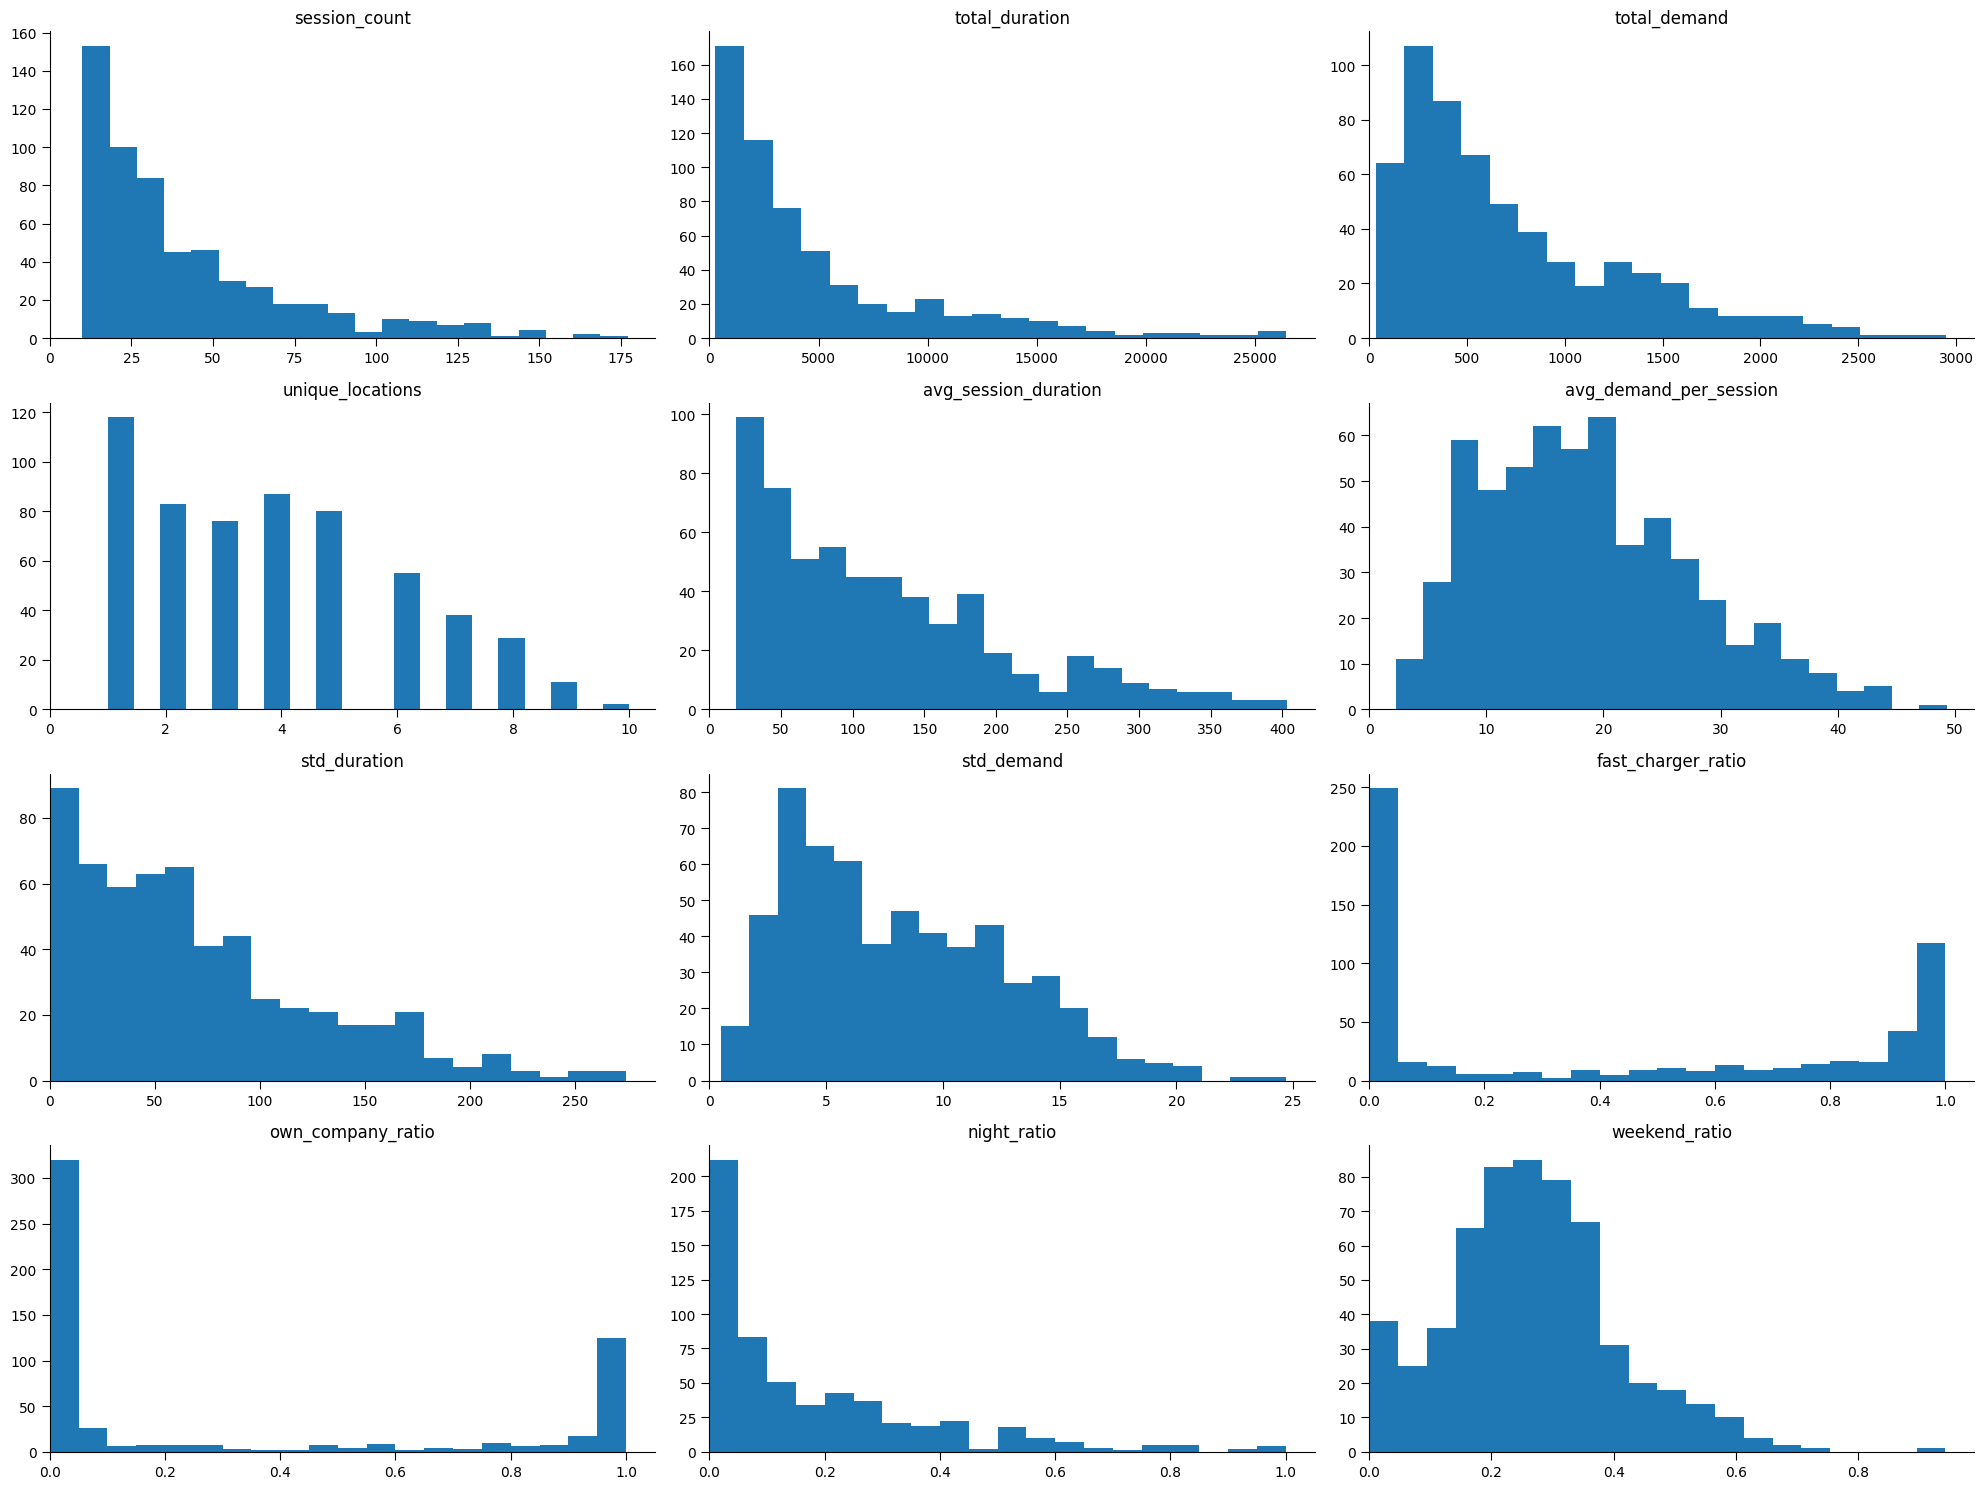

In [30]:
plot_histograms(data_pre_transform_scale)

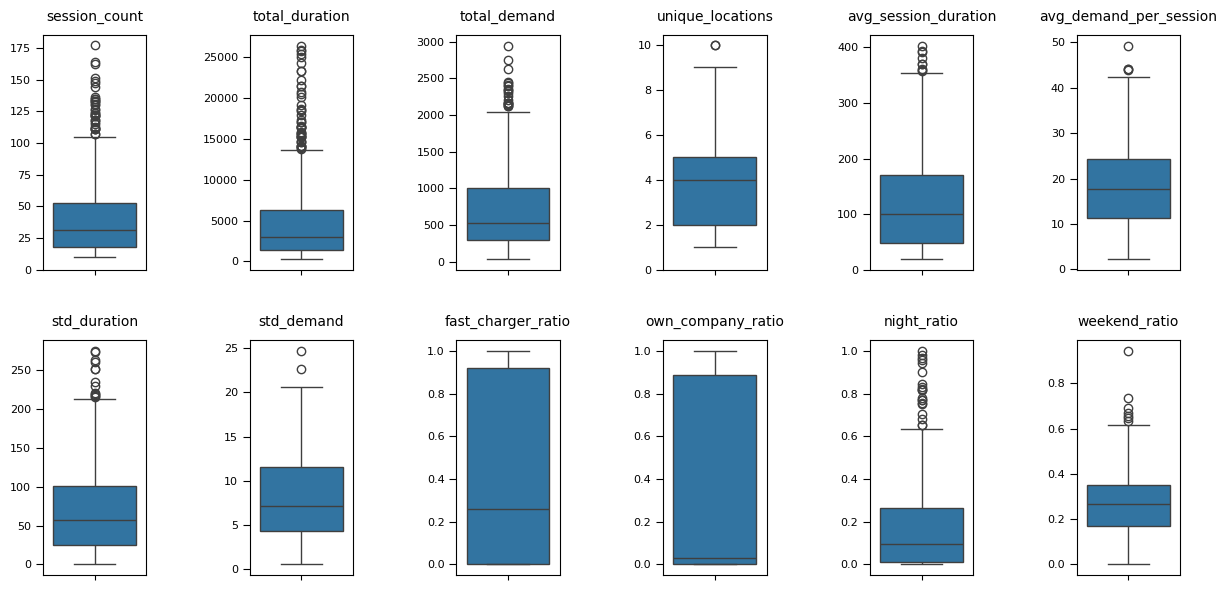

In [31]:
plot_boxplots(data_pre_transform_scale)

## 3.4. Further transform and scale data

<div class="alert alert-block alert-info">

In this part, I'll apply log transformations to skewed features like total_duration, total_demand, session_count, and avg_session_duration to normalize and balance influence, enhancing clustering effectiveness. Then apply StandardScaler for all features. StandardScaler properly centered (mean = 0) and scaled all features to the same range (standard deviation = 1)

Addressing skewed data is important for optimizing clustering and preserving data relationships due to:

* Distance calculation problems: Skewed data can distort distance metrics, causing clustering algorithms like K-means and HAC to form unbalanced clusters while impeding DBSCAN's density estimation.

* Outlier sensitivity: Extreme outliers in skewed distributions can misplace cluster centroids and obscure meaningful patterns.

* Algorithm assumptions: Many algorithms, such as K-means and PCA, work best under normal distribution assumptions for spherical clusters and linear relationships.

* Feature dominance: Highly skewed features can dominate similarity calculations, leading to clusters influenced by one or two overpowering features.

</div>

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
data_pre_transform_scale.skew()

session_count             1.551313
total_duration            1.807712
total_demand              1.206379
unique_locations          0.451440
avg_session_duration      1.052337
avg_demand_per_session    0.598778
std_duration              1.077599
std_demand                0.624038
fast_charger_ratio        0.247584
own_company_ratio         0.746438
night_ratio               1.583452
weekend_ratio             0.504619
dtype: float64

<div class="alert alert-block alert-info">

Features targeted for transformation

* session_count (Skewness: 1.55): Right-skewed distribution
* total_duration (Skewness: 1.81): Most skewed feature
* total_demand (Skewness: 1.21): Right skewness with a long tail
* avg_session_duration (Skewness: 1.05): Moderately skewed
* std_duration (Skewness: 1.08): Moderate skewness
* night_ratio (Skewness: 1.58): High right skewness

Detailed approach:

* Apply log transformations using log1p for features with zero values: session_count, total_duration, total_demand, avg_session_duration, std_duration, and night_ratio.

* Standardize all features post-transformation for balanced contributions in clustering and PCA.
</div>

In [34]:
df = data_pre_transform_scale.copy()
    
# Log transform highly skewed features to reduce impact of outliers on initial centroid selection
log_features = ['session_count', 'total_duration', 'total_demand', 'avg_session_duration', 'std_duration']
for feature in log_features:
    df[feature] = np.log1p(df[feature])
    
df['night_ratio'] = np.sqrt(df['night_ratio'])


In [35]:
# After transformation
df.skew()

session_count             0.269649
total_duration            0.026123
total_demand             -0.353674
unique_locations          0.451440
avg_session_duration     -0.044236
avg_demand_per_session    0.598778
std_duration             -0.513302
std_demand                0.624038
fast_charger_ratio        0.247584
own_company_ratio         0.746438
night_ratio               0.346945
weekend_ratio             0.504619
dtype: float64

<Figure size 2000x1500 with 0 Axes>

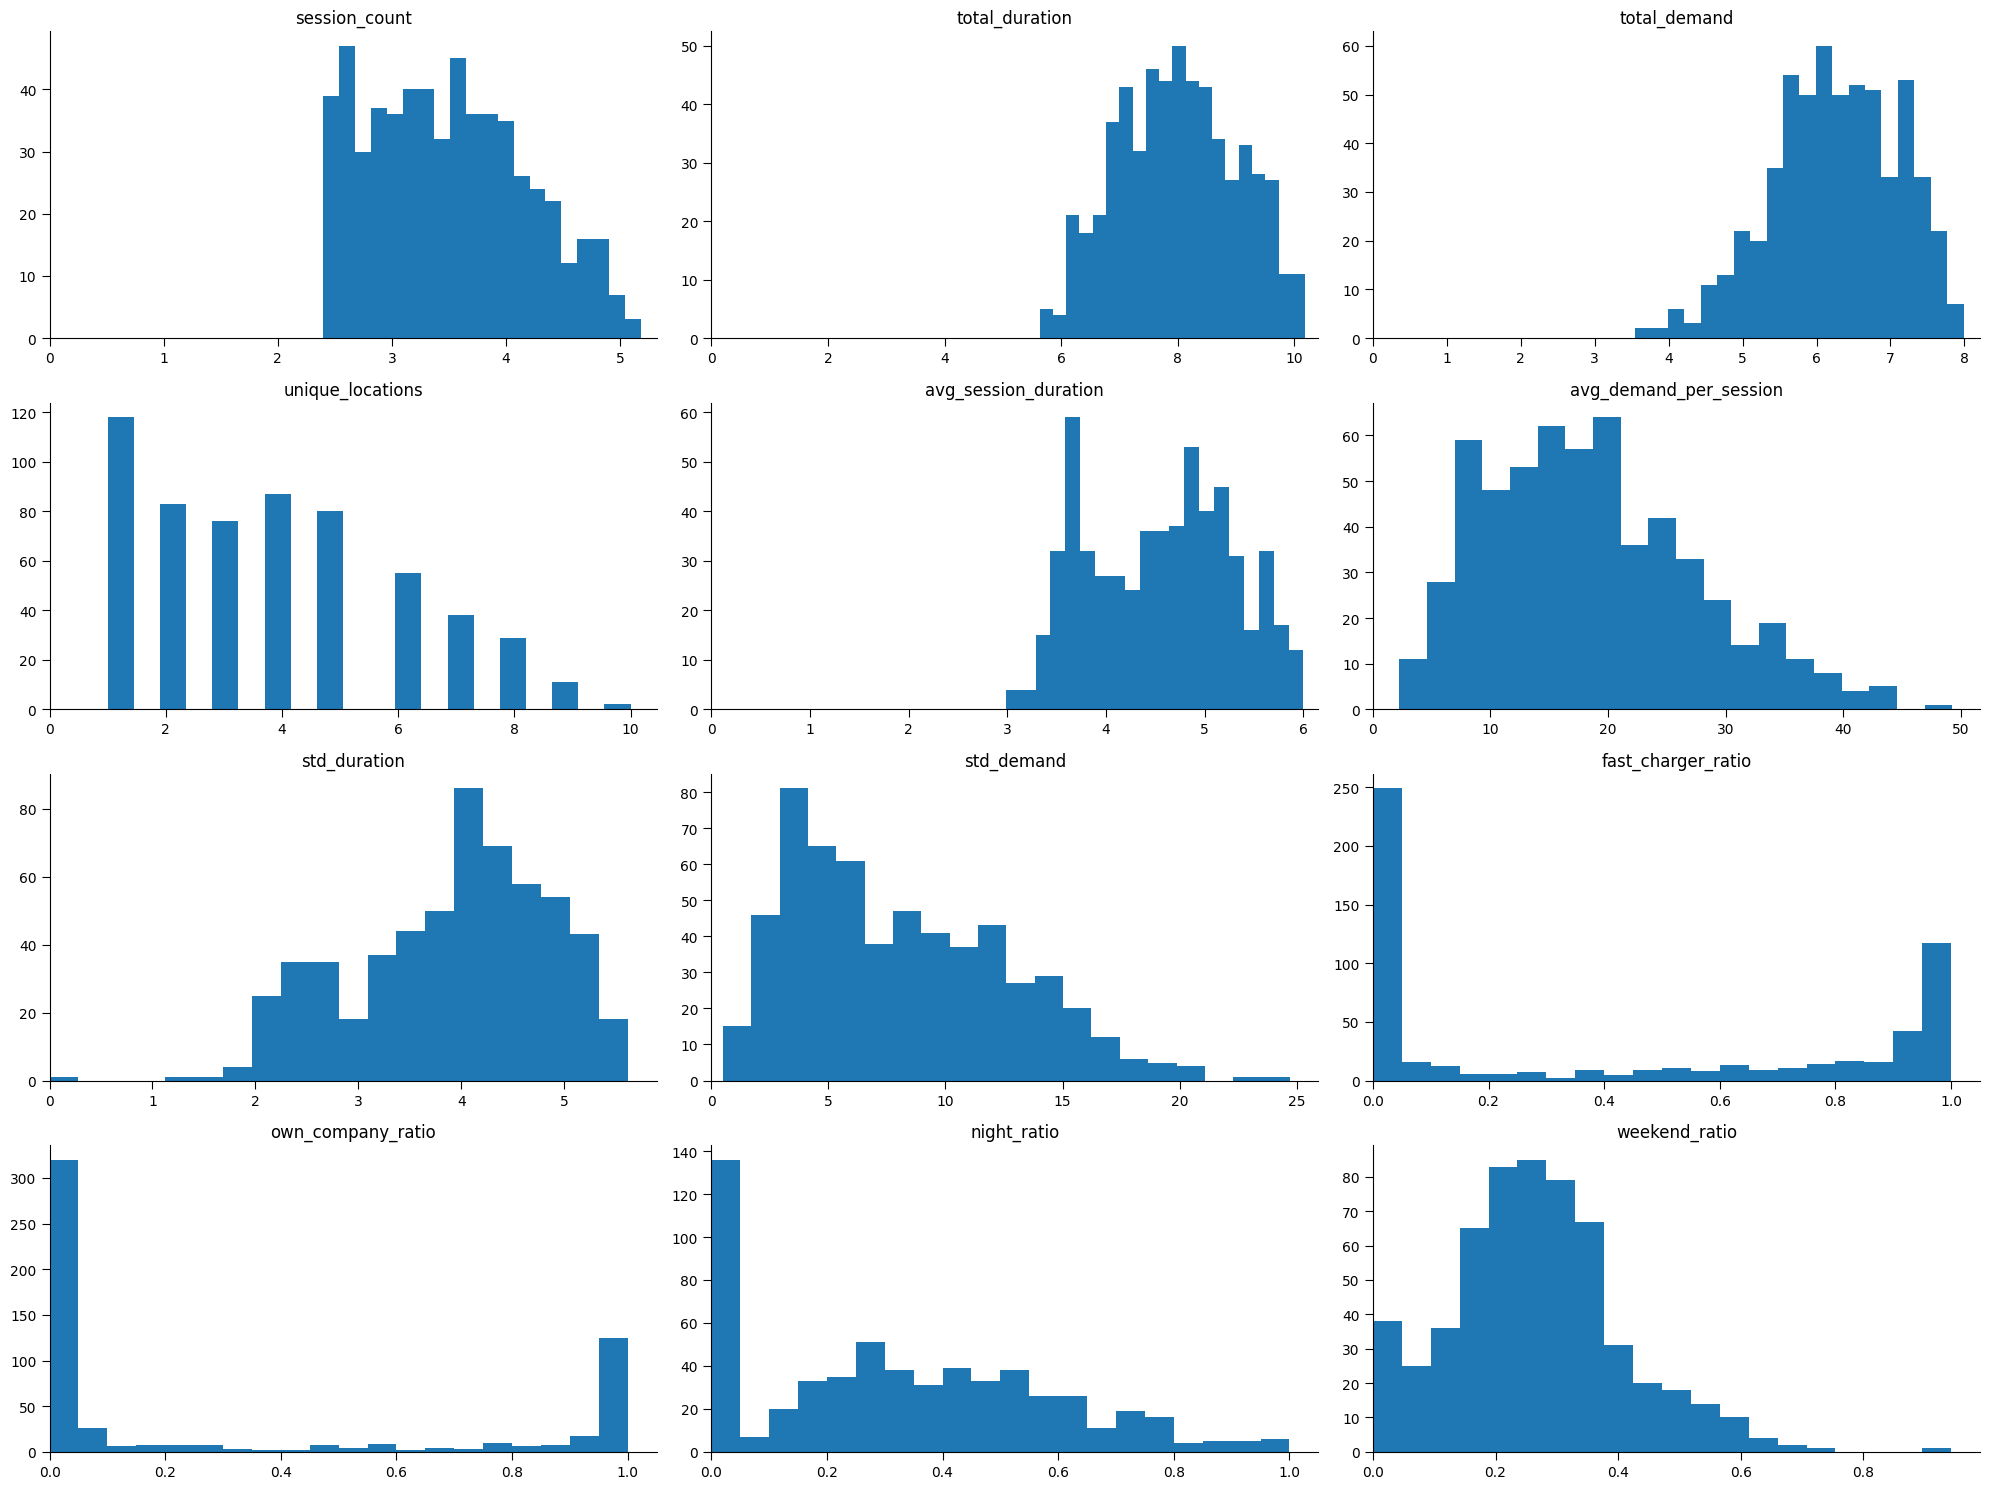

In [36]:
plot_histograms(df)

In [37]:
# Then standardize to equalize feature scales
scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   session_count           579 non-null    float64
 1   total_duration          579 non-null    float64
 2   total_demand            579 non-null    float64
 3   unique_locations        579 non-null    float64
 4   avg_session_duration    579 non-null    float64
 5   avg_demand_per_session  579 non-null    float64
 6   std_duration            579 non-null    float64
 7   std_demand              579 non-null    float64
 8   fast_charger_ratio      579 non-null    float64
 9   own_company_ratio       579 non-null    float64
 10  night_ratio             579 non-null    float64
 11  weekend_ratio           579 non-null    float64
dtypes: float64(12)
memory usage: 54.4 KB


In [39]:
data.describe().round(2)

session_count  total_duration  total_demand  unique_locations  \
count         579.00          579.00        579.00            579.00   
mean            0.00            0.00         -0.00              0.00   
std             1.00            1.00          1.00              1.00   
min            -1.60           -2.32         -3.14             -1.26   
25%            -0.80           -0.78         -0.68             -0.81   
50%            -0.04           -0.01          0.02              0.08   
75%             0.72            0.73          0.77              0.53   
max             2.45            2.13          2.02              2.76   

       avg_session_duration  avg_demand_per_session  std_duration  std_demand  \
count                579.00                  579.00        579.00      579.00   
mean                   0.00                    0.00          0.00        0.00   
std                    1.00                    1.00          1.00        1.00   
min                   -2.17                   -1.82         -4.15       -1.66   
25%                   -0.93                   -0.80         -0.68       -0.82   
50%                    0.09                   -0.09          0.16       -0.21   
75%                    0.81                    0.65          0.76        0.75   
max                    1.99                    3.45          1.82        3.64   

       fast_charger_ratio  own_company_ratio  night_ratio  weekend_ratio  
count              579.00             579.00       579.00         579.00  
mean                -0.00              -0.00        -0.00          -0.00  
std                  1.00               1.00         1.00           1.00  
min                 -0.98              -0.76        -1.28          -1.89  
25%                 -0.98              -0.76        -0.86          -0.68  
50%                 -0.38              -0.69        -0.07          -0.01  
75%                  1.16               1.31         0.73           0.58  
max                  1.35               1.58         2.63           4.79

# 4. Exploratory Data Analysis: Statistical Properties

<Figure size 2000x1500 with 0 Axes>

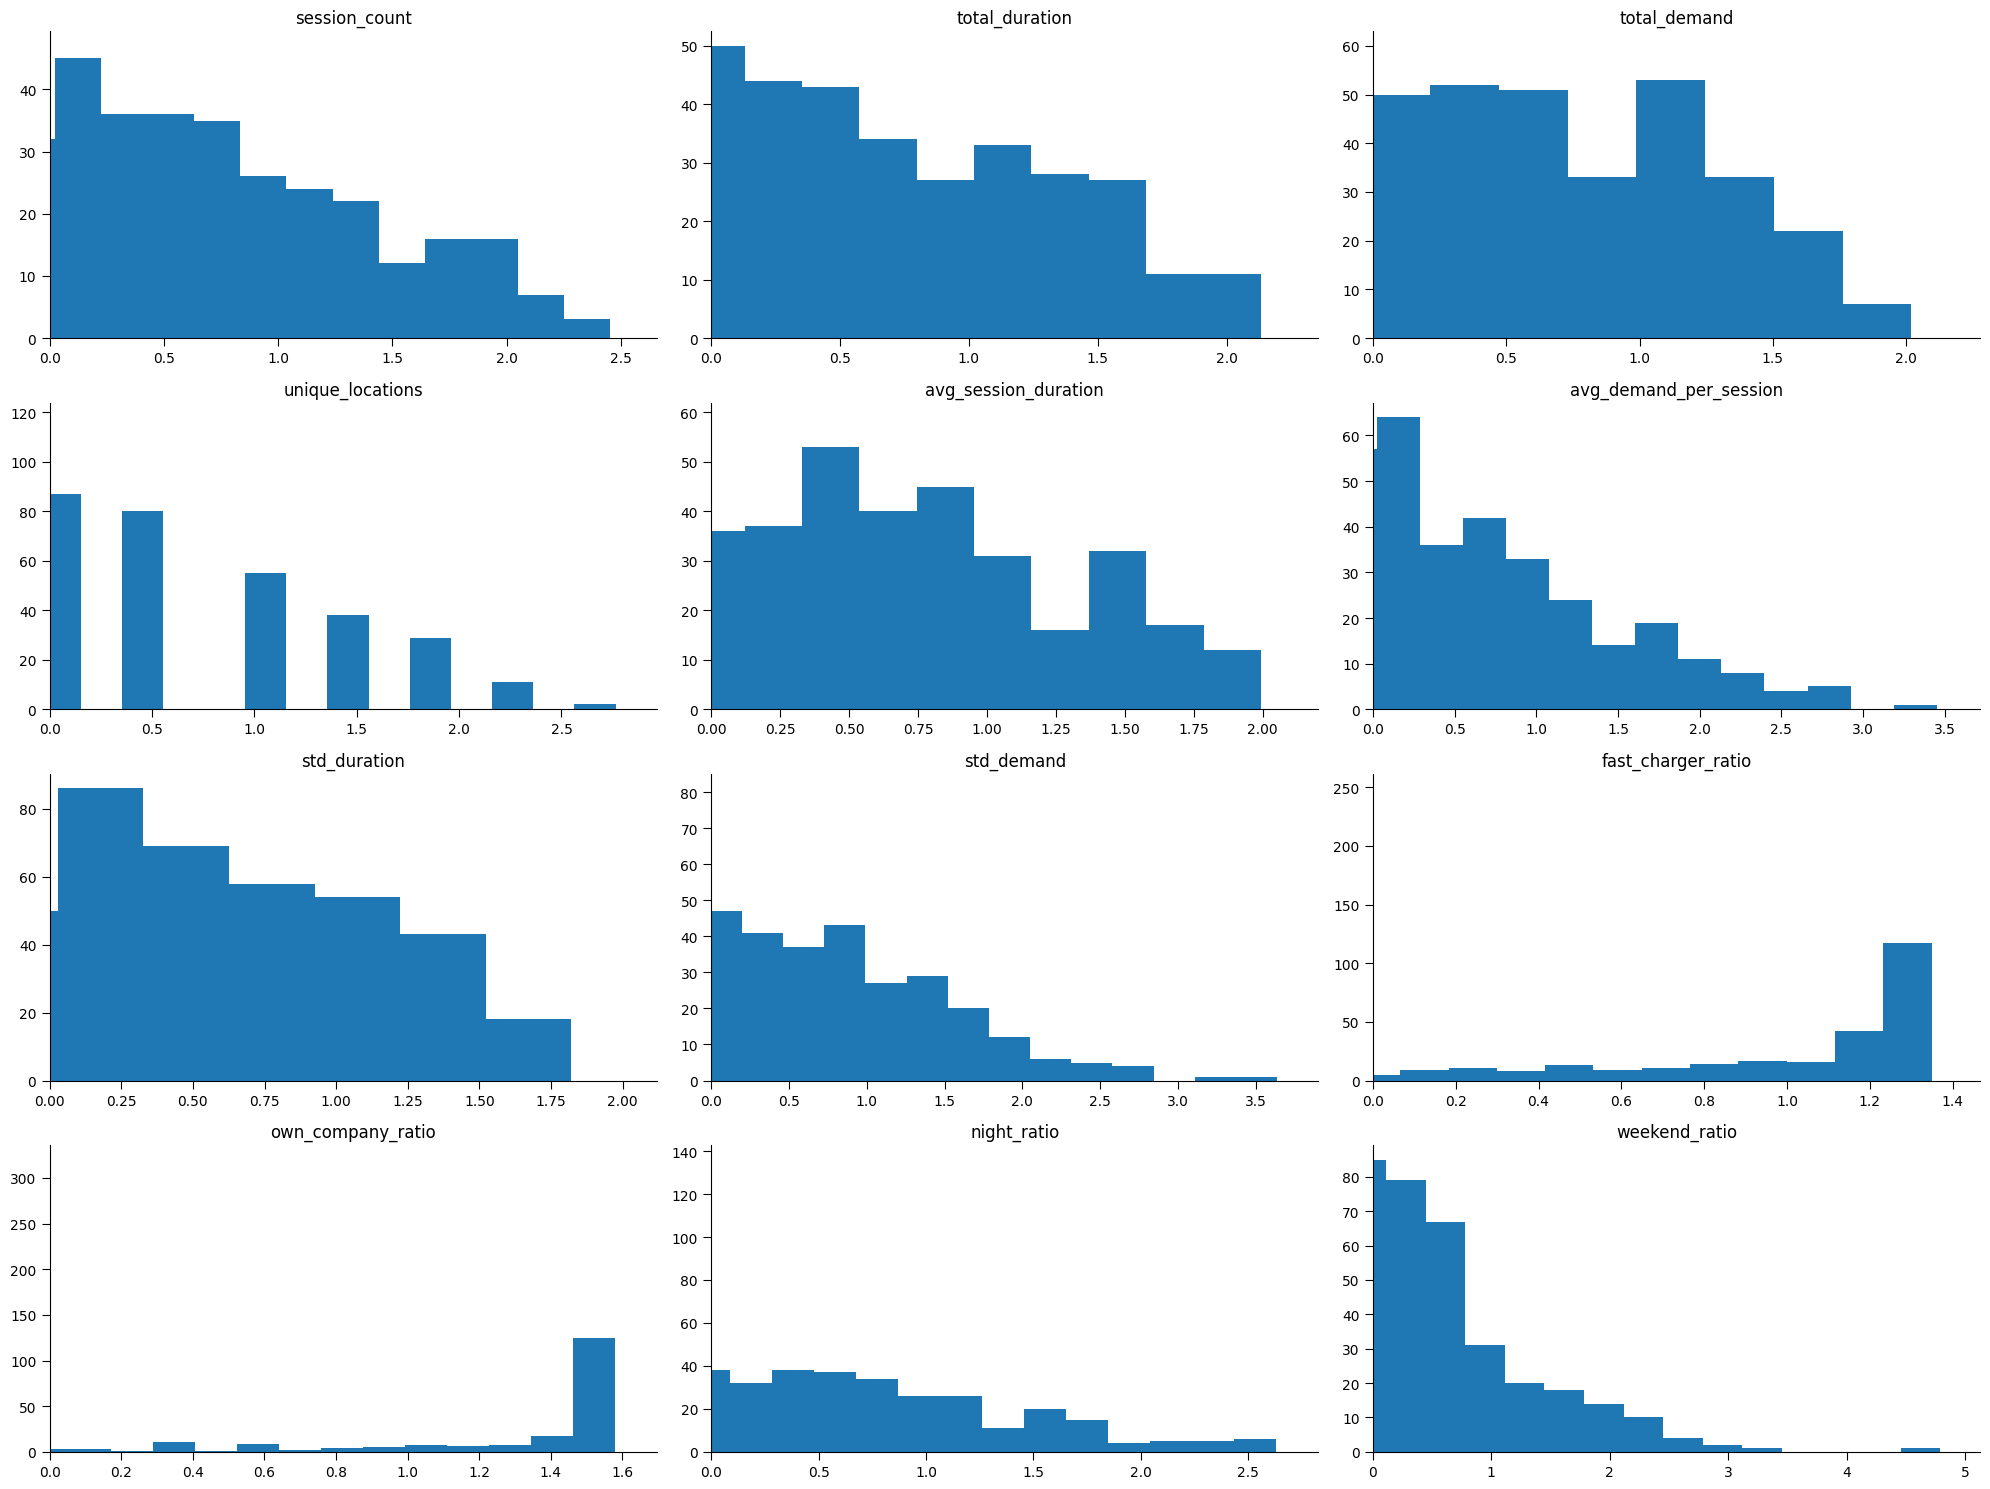

In [40]:
plot_histograms(data)

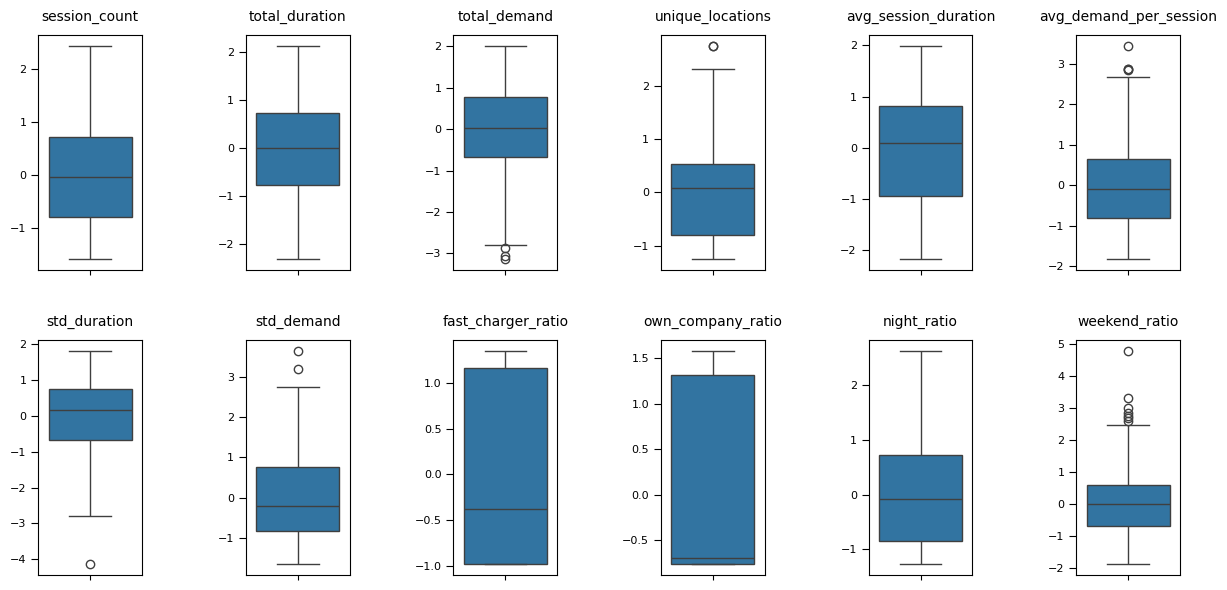

In [41]:
plot_boxplots(data)

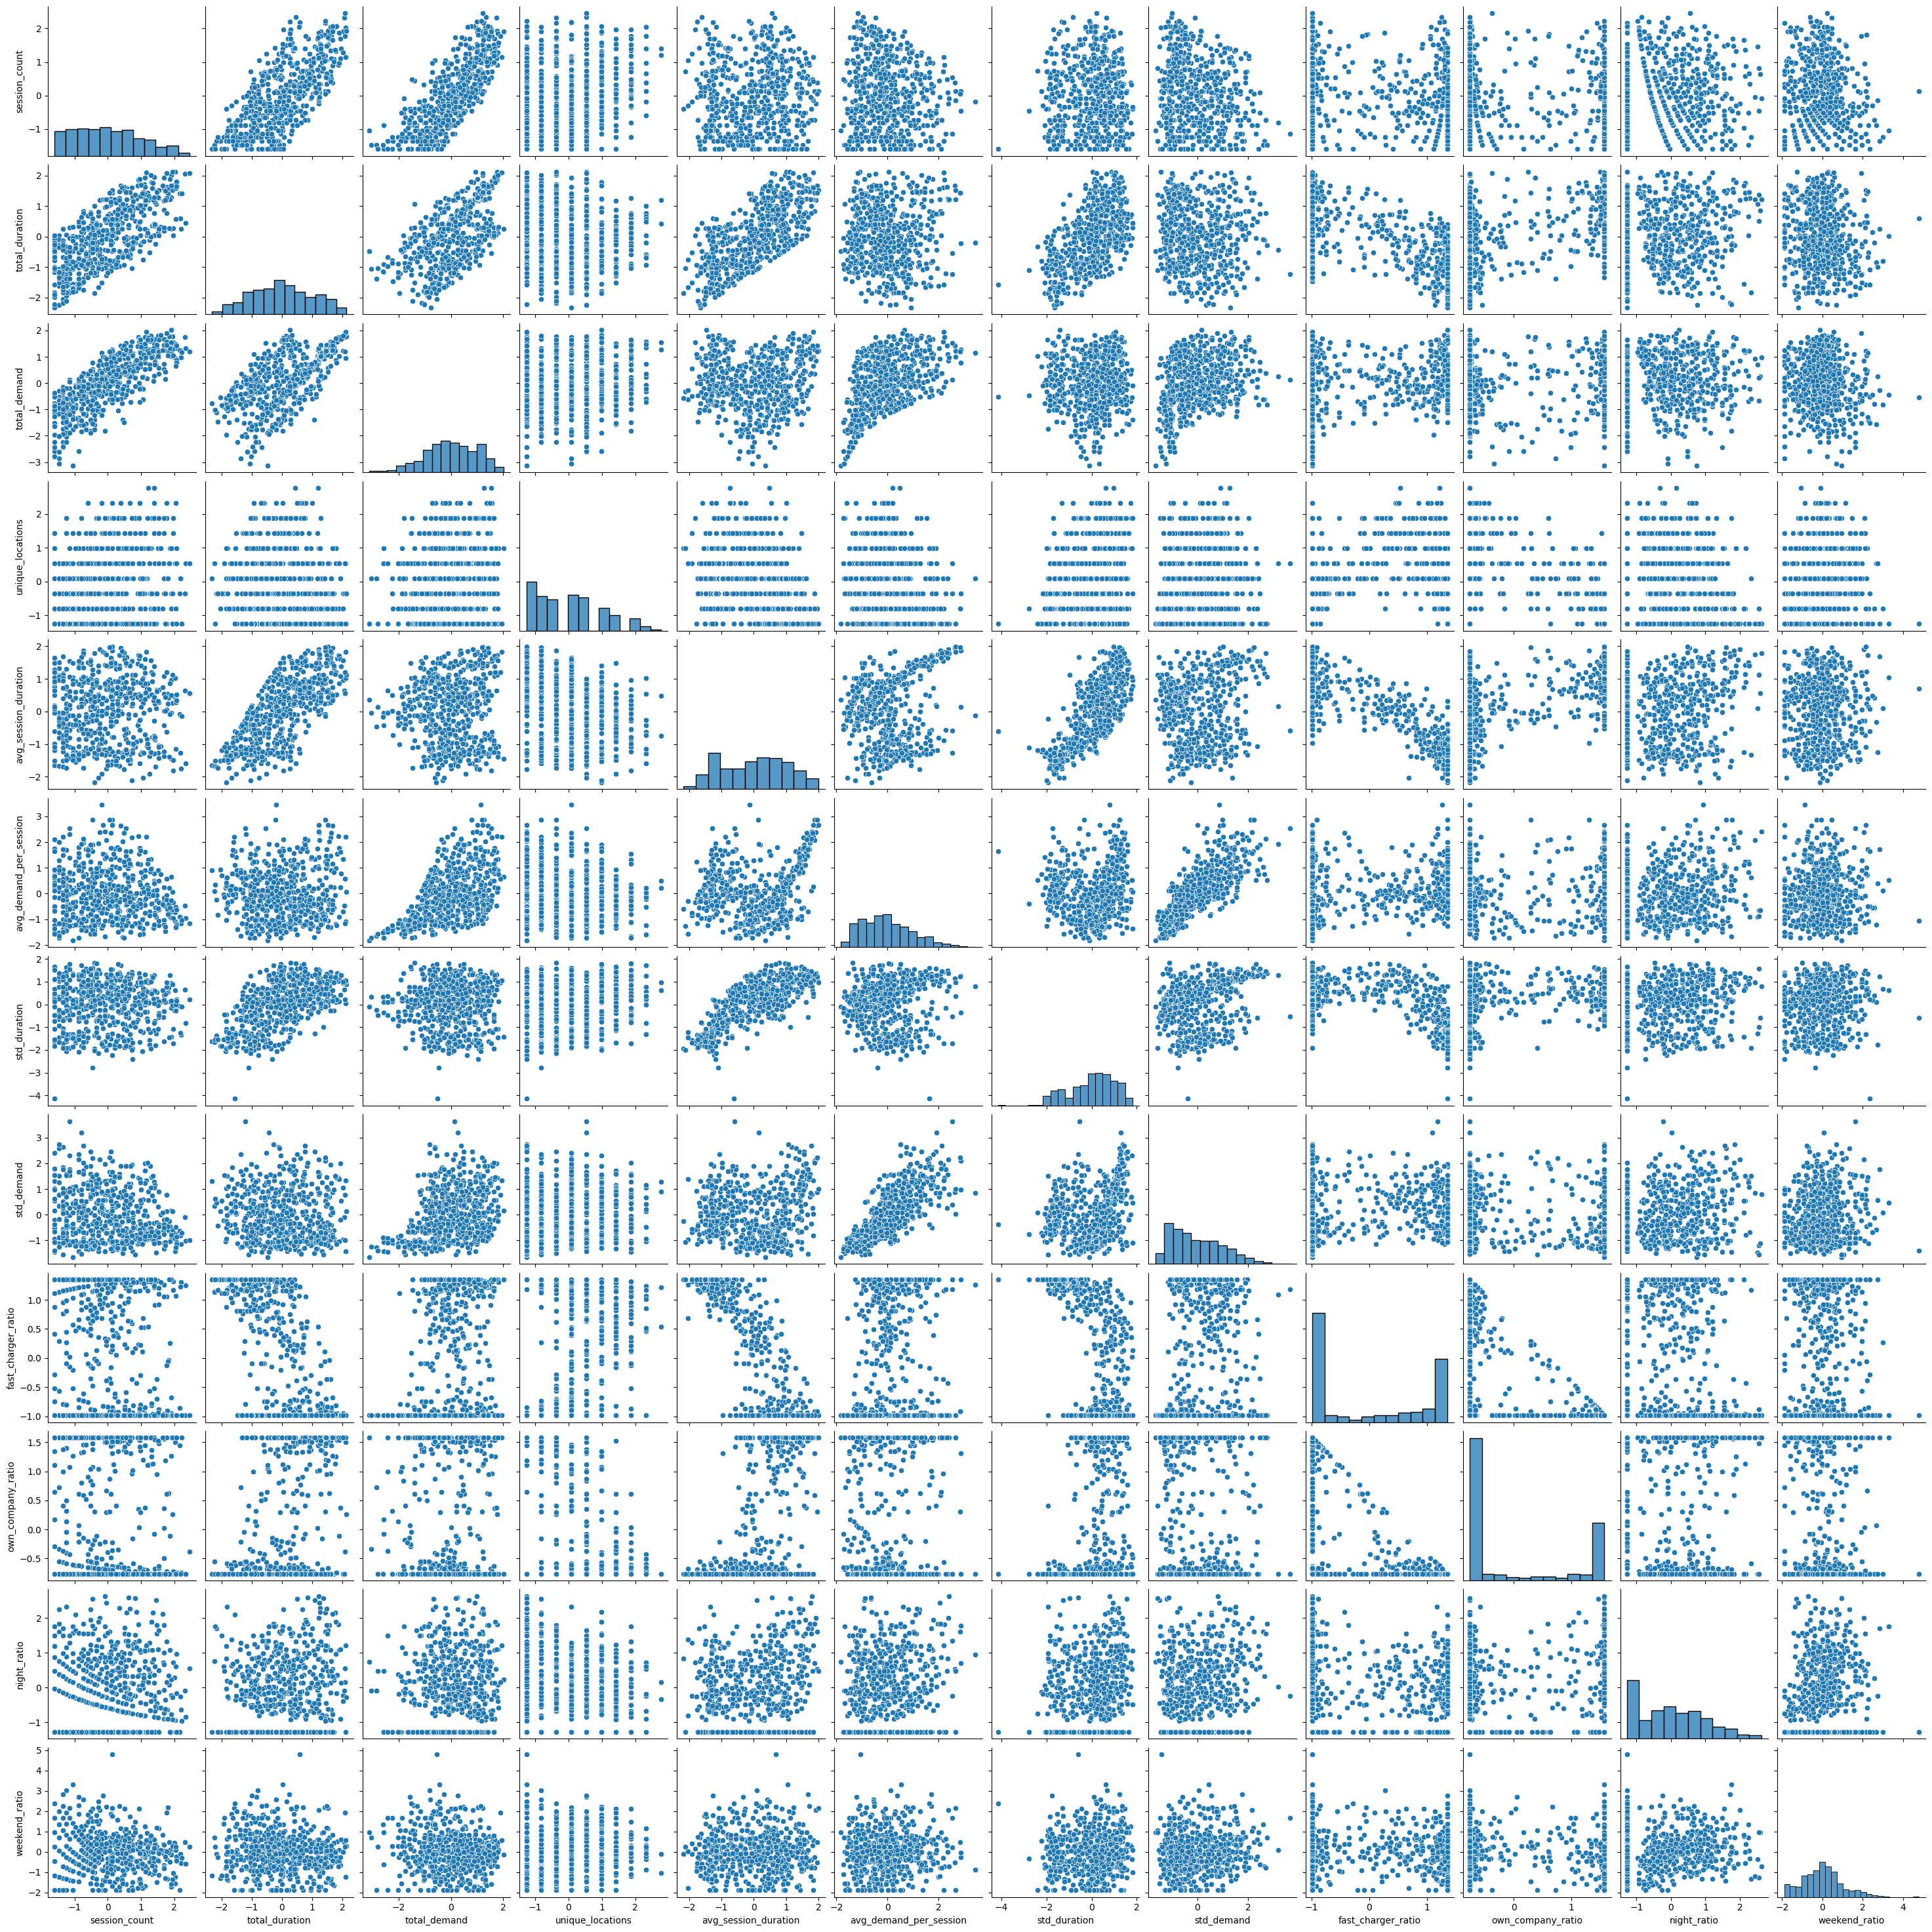

In [42]:
sns.pairplot(data)

<div class="alert alert-block alert-info">

Upon examining the pairplot, we observe various relationships between the features:

* Strong positive linear relationships: Several pairs show clear positive correlations, visible as diagonal lines trending from bottom-left to top-right. These indicate that as one variable increases, the other tends to increase proportionally.
    * session_count - total_duration
    * session count - total_demand
    * total_demand - total_duration
    * total_duration - average_session_duration
    * avg_demand_per_session - std_demand
    * avg_session_duration - std_duration

* No correlation/random scatter: Many pairs exhibit random scatter patterns with no obvious structure, suggesting little to no relationship between those variables.
    * session_count - avg_session_duration
    * session_count - avg_demand_per_session
    * total_duration - weekend_ratio 
    etc.

* Discrete/Categorical variables: Several columns/rows show vertical or horizontal stripe patterns, indicating discrete or categorical variables being plotted against continuous variables.
    * session_count - night_ratio
    * session_count - weekend_ratio
    etc.

However, there are no obvious cluster patterns, indicating potential noise in the data that may hinder achieving clean and distinct clusterings.
</div>

In [43]:
def plot_correlation_matrix(data, figsize=(12, 10), cmap='coolwarm'):

    correlation = data.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    plt.figure(figsize=figsize)
    sns.heatmap(correlation, mask=mask, annot=True, cmap=cmap, fmt='.2f')
    plt.title(f'Correlation Matrix')
    plt.tight_layout()
    plt.show()


<div class="alert alert-block alert-info">
The correlation of certain pairs is confirmed by calculations and by displaying the correlation matrix.
</div>

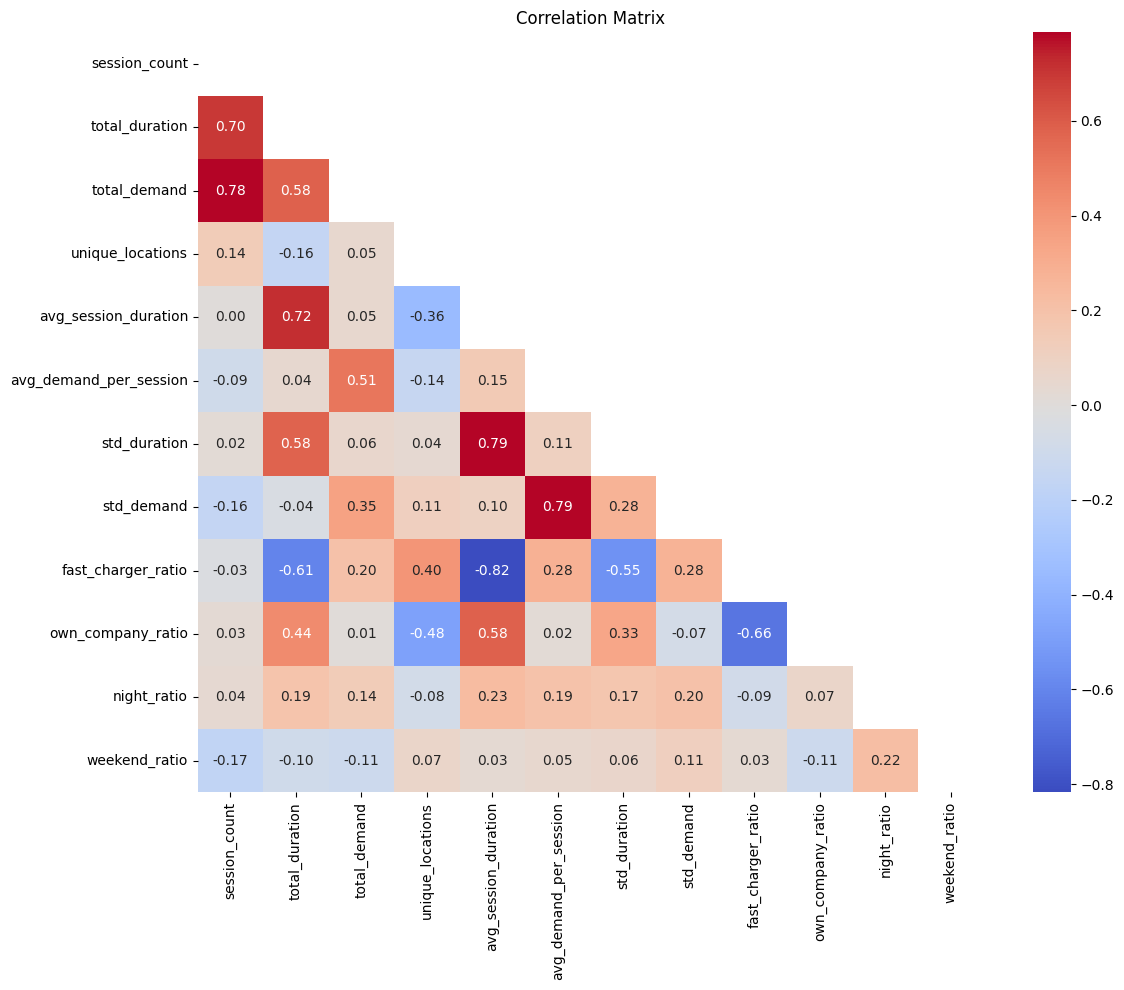

In [44]:
plot_correlation_matrix(data)

#  5. Dimensionality Reduction

<div class="alert alert-block alert-info">

Principal Component Analysis (PCA) is a technique used for dimensionality reduction in datasets. It transforms high-dimensional data into a lower-dimensional space by finding principal components—new variables that are linear combinations of the original variables. These components are ordered based on the amount of variance they explain, aiming to preserve as much variance as possible.

Based on the characteristics observed in scatterplot matrix, PCA is particularly suitable for your dataset for several reasons:

* High dimensionality: your dataset contains numerous variables (12 dimensions), making it complex to interpret all relationships. PCA helps simplify this by reducing the dimensions while retaining the core data characteristics.

* Visible correlations: The dataset exhibits clear linear relationships between many variable pairs. PCA is effective in capturing these correlations, both positive and negative, as it focuses on maximizing variance.

* Mixed relationship patterns: The data includes pairs with strong linear relationships and others with minimal or non-linear correlations. PCA identifies the relationships contributing most to the overall variance, aiding in more efficient analysis.

* Potential redundancy: Several variables seem to share similar patterns, suggesting redundancy. PCA addresses this by creating new, uncorrelated components, thereby maximizing information retention with fewer variables.

</div>

In [45]:
model = pca(n_components=0.75, random_state=RANDOM_SEED)
pca_result = model.fit_transform(data)['PC']

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [75.0%] explained variance using the [12] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [4] that covers the [75.00%] explained variance.
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [46]:
data_pca = pca_result
data_pca

PC1       PC2       PC3       PC4
0    2.419910  0.030775 -0.373501 -0.954831
1    1.209576  0.954617 -0.168977  0.788027
2    3.018613  2.881205 -0.873432 -0.410234
3    2.108890  0.779359  1.233728  0.425109
4    2.316634  0.466491  2.339709  0.877727
..        ...       ...       ...       ...
574  1.864859 -1.836779  0.718836 -0.166272
575 -2.440482 -0.821339 -1.473953  0.897159
576  0.526172 -3.756320 -1.692819  0.465246
577  1.723220 -0.746462 -0.645745 -1.333811
578 -0.896687 -3.816410 -1.029015  0.275360

[579 rows x 4 columns]

<div class="alert alert-block alert-info">

The Principal Component Analysis (PCA) transformation applied to the dataset has yielded significant dimensionality reduction while preserving most of the information in the original data. As shown in the first figure, just 4 principal components capture ca. 80% of the total variance in the dataset, which is a substantial reduction from the original 12 dimensions.

</div>

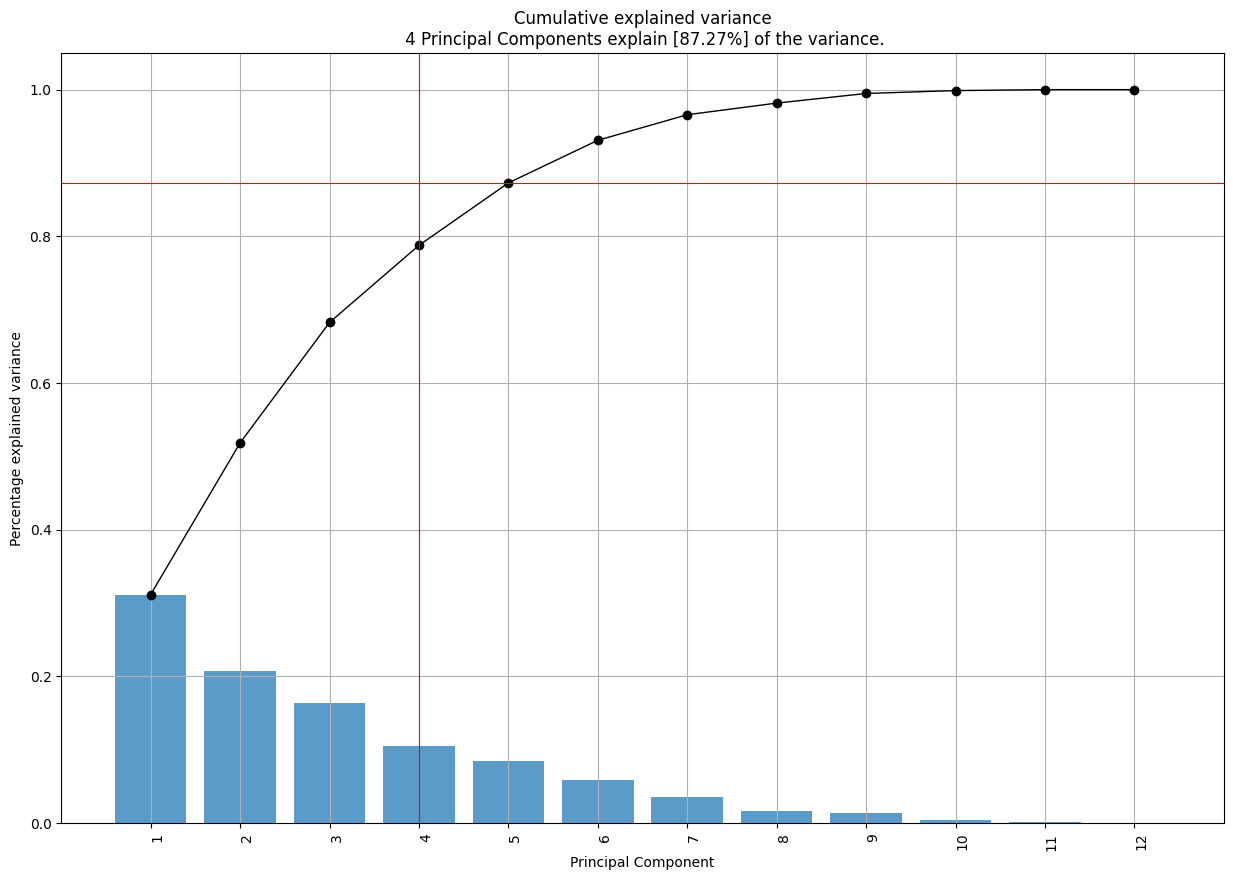

In [47]:
# explained variance
fig, ax = model.plot()

[18-05-2025 23:05:47] [scatterd.scatterd] [INFO] Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(None,
 <Axes: title={'center': '4 Principal Components explain [87.27%] of the variance'}, xlabel='PC1 (31.1% expl.var)', ylabel='PC2 (20.6% expl.var)'>)

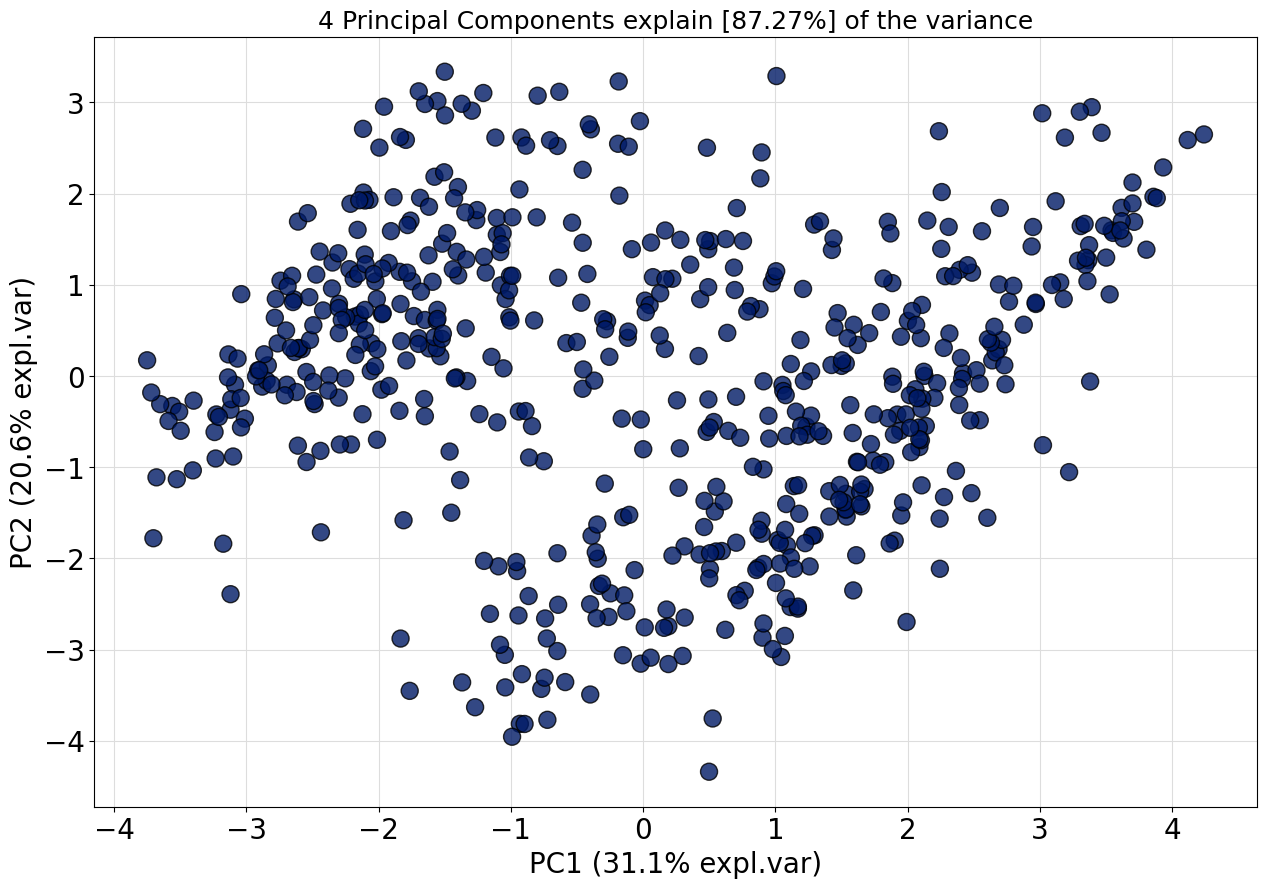

In [48]:
fig, ax = plt.subplots(figsize=(15, 10)) 

model.scatter(ax=ax, legend=False)

In [49]:
model.results['loadings'].round(3)

session_count  total_duration  total_demand  unique_locations  \
PC1          0.158           0.452         0.146            -0.206   
PC2          0.289           0.153         0.540             0.169   
PC3          0.577           0.273         0.273             0.143   
PC4          0.065           0.104        -0.126             0.591   

     avg_session_duration  avg_demand_per_session  std_duration  std_demand  \
PC1                 0.477                   0.054         0.377       0.021   
PC2                -0.067                   0.467         0.034       0.445   
PC3                -0.177                  -0.367        -0.184      -0.424   
PC4                 0.081                  -0.301         0.356      -0.037   

     fast_charger_ratio  own_company_ratio  night_ratio  weekend_ratio  
PC1              -0.426              0.366        0.137         -0.029  
PC2               0.312             -0.170        0.158          0.017  
PC3               0.003             -0.060       -0.200         -0.273  
PC4              -0.051             -0.311        0.243          0.486

In [50]:
model.results['explained_var']

array([0.31152408, 0.51832926, 0.68259384, 0.78769936, 0.87277839,
       0.93091722, 0.96577831, 0.98165165, 0.99476588, 0.99870579,
       0.9999973 , 1.        ])

# 6. Exploratory Data Analysis: Clustering


<div class="alert alert-block alert-success">

I chosed Euclidean distance  for clustering due to dataset characteristics and PCA transformation which produces orthogonal components ideal for Euclidean space. 

* It fits K-means by aligning with the algorithm’s objective to minimize within-cluster variance under assumptions of spherical clusters. 

* For OPTICS, Euclidean distance effectively identifies density-connected regions

* For HAC, combined with Ward’s linkage, it minimizes within-cluster variance. 

Using Euclidean distance consistently across all methods allows straightforward comparisons, enhancing interpretation by maintaining a uniform distance metric.
</div>

## 6.1. K-Means++


<div class="alert alert-block alert-info">

K-Means is an unsupervised machine learning algorithm that partitions data into K distinct, non-overlapping clusters. The algorithm works by:

* Initializing K cluster centroids (using k-means++ in this implementation for better initial placement)
* Assigning each data point to the nearest centroid
* Recalculating centroids based on the mean of all points assigned to that cluster
* Repeating steps 2-3 until convergence (centroids no longer move significantly)
</div>

<div class="alert alert-block alert-info">

I'll use these 3 metrics to evaluate the quality of clustering:

* **Inertia (Within-cluster sum of squares)**: Measures how close data points are to their assigned centroids. Lower values indicate tighter, more compact clusters. Used in the Elbow Method to identify the optimal K where adding more clusters provides diminishing returns.

* **Silhouette score**: Measures how similar an object is to its own cluster compared to other clusters. Ranges from -1 to 1, where:
    * Values near 1 indicate well-separated clusters
    * Values near 0 indicate overlapping clusters
    * Negative values suggest points may be assigned to the wrong cluster

* **Davies-Bouldin index**: Measures the average similarity between clusters, where similarity is the ratio of within-cluster distances to between-cluster distances. Lower values indicate better clustering with more distinct separation.
</div>

### 6.1.1. Setup

In [51]:
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm

In [52]:
def plot_kmeans_metrics(data, n_init, max_iter, tol):
    inertias = []
    silhouette_scores = []
    davies_bouldin_scores = []

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=n_init, init='k-means++', max_iter=max_iter, tol=tol)
        cluster_labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)

        if k > 1:  # Silhouette and Davies-Bouldin scores are valid only for k > 1
            silhouette_avg = silhouette_score(data, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            
            davies_bouldin_avg = davies_bouldin_score(data, cluster_labels)
            davies_bouldin_scores.append(davies_bouldin_avg)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for ax in axs:
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axs[0].plot(range(1, 11), inertias, marker='o')
    axs[0].set_title('Elbow Method for Optimal k', fontsize=14)
    axs[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axs[0].set_xticks(range(1, 11))

    axs[1].plot(range(2, 11), silhouette_scores, marker='o')
    axs[1].set_title('Silhouette Scores for KMeans Clustering', fontsize=14)
    axs[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axs[1].set_xticks(range(2, 11))

    axs[2].plot(range(2, 11), davies_bouldin_scores, marker='o')
    axs[2].set_title('Davies-Bouldin Score for KMeans Clustering', fontsize=14)
    axs[2].set_xlabel('Number of Clusters (k)', fontsize=12)
    axs[2].set_xticks(range(2, 11))

    plt.tight_layout()
    plt.show()

In [53]:
def perform_kmeans_clustering(data, k, n_init, max_iter, tol):

    kmeans_pp = KMeans(
        n_clusters=k,
        random_state=RANDOM_SEED,
        n_init=n_init,
        init='k-means++',
        max_iter=max_iter,
        tol=tol
    )

    cluster_labels = kmeans_pp.fit_predict(data)
    
    result_kmeans = data_pre_transform_scale.copy()
    result_kmeans['Cluster'] = cluster_labels
  
    print(result_kmeans['Cluster'].value_counts())

    visualizer = SilhouetteVisualizer(kmeans_pp, colors='yellowbrick')
    visualizer.fit(data)
    visualizer.show()

    features_to_plot = [col for col in result_kmeans.columns if col != 'Cluster']
    
    n_cols = 4
    n_rows = 3

    plt.figure(figsize=(15, n_rows * 4))

    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x='Cluster', y=feature, data=result_kmeans)
        plt.grid(False)
        plt.title(feature, fontsize=10, pad=10)
        plt.xlabel('Cluster', fontsize=9)
        plt.ylabel('')
        plt.yticks(fontsize=8)
        plt.tick_params(axis='y', which='both', direction='out', length=6)

    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    plt.show()

    return result_kmeans

In [54]:
from itertools import product
import time

def grid_search_kmeans(data, k_range=range(2, 11), n_init_values=[5, 15, 30, 50], 
                       max_iter_values=[50, 150, 300, 500], tol_values=[1e-3, 1e-4, 1e-6, 1e-8],
                       random_seed=42):
    
    best_score = float('-inf')
    best_params = None
    
    total_combinations = len(k_range) * len(n_init_values) * len(max_iter_values) * len(tol_values)
    print(f"Testing {total_combinations} combinations...")
    
    start_time = time.time()
    counter = 0
    
    for k, n_init, max_iter, tol in product(k_range, n_init_values, max_iter_values, tol_values):
        counter += 1
        if counter % 50 == 0:
            elapsed = time.time() - start_time
        
        try:
            k_int = int(k)
            n_init_int = int(n_init)
            max_iter_int = int(max_iter)
            tol_float = float(tol)
            
            kmeans = KMeans(n_clusters=k_int, random_state=random_seed, 
                           n_init=n_init_int, init='k-means++', 
                           max_iter=max_iter_int, tol=tol_float)
            cluster_labels = kmeans.fit_predict(data)
            
            silhouette_avg = silhouette_score(data, cluster_labels)
            davies_bouldin_avg = davies_bouldin_score(data, cluster_labels)
            
            # Calculate combined score (higher is better)
            combined_score = silhouette_avg - davies_bouldin_avg
            
            if combined_score > best_score:
                best_score = combined_score
                best_params = {
                    'k': k_int,
                    'n_init': n_init_int,
                    'max_iter': max_iter_int,
                    'tol': tol_float,
                    'silhouette_score': silhouette_avg,
                    'davies_bouldin_score': davies_bouldin_avg,
                    'combined_score': combined_score
                }
        except Exception as e:
            print(f"Error with combination k={k}, n_init={n_init}, max_iter={max_iter}, tol={tol}: {str(e)}")
    
    
    return best_params

In [55]:
def plot_best_kmeans_results(data, best_params, random_seed=42):

    k = int(best_params['k'])
    n_init = int(best_params['n_init'])
    max_iter = int(best_params['max_iter'])
    tol = float(best_params['tol'])
    
    silhouette_scores = []
    davies_bouldin_scores = []
    
    for k_val in range(2, 11):
        kmeans_k = KMeans(n_clusters=k_val, random_state=random_seed, 
                         n_init=n_init, init='k-means++', 
                         max_iter=max_iter, tol=tol)
        labels_k = kmeans_k.fit_predict(data)
        
        silhouette_scores.append(silhouette_score(data, labels_k))
        davies_bouldin_scores.append(davies_bouldin_score(data, labels_k))
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    for ax in axs:
        ax.tick_params(axis='both', labelsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    axs[0].plot(range(2, 11), silhouette_scores, marker='o', markersize=8, linewidth=2)
    axs[0].set_title(f'Silhouette Scores (n_init={n_init}, max_iter={max_iter}, tol={tol})', fontsize=14)
    axs[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axs[0].set_ylabel('Silhouette Score (higher is better)', fontsize=12)
    axs[0].set_xticks(range(2, 11))
    axs[0].axvline(x=k, color='red', linestyle='--', alpha=0.7, label=f'Best k={k}')
    axs[0].legend()
    
    axs[1].plot(range(2, 11), davies_bouldin_scores, marker='o', markersize=8, linewidth=2)
    axs[1].set_title(f'Davies-Bouldin Scores (n_init={n_init}, max_iter={max_iter}, tol={tol})', fontsize=14)
    axs[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axs[1].set_ylabel('Davies-Bouldin Score (lower is better)', fontsize=12)
    axs[1].set_xticks(range(2, 11))
    axs[1].axvline(x=k, color='red', linestyle='--', alpha=0.7, label=f'Best k={k}')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


In [56]:
def run_kmeans_optimization(data, sample_size=None, random_seed=42):

    if sample_size is not None and sample_size < len(data):
        np.random.seed(random_seed)
        indices = np.random.choice(len(data), sample_size, replace=False)
        sampled_data = data[indices]
        print(f"Sampled {sample_size} points from {len(data)} total points")
    else:
        sampled_data = data
    
    k_range = range(2, 11)
    n_init_values = [5, 15, 30, 50]
    max_iter_values = [50, 150, 300, 500]
    tol_values = [1e-3, 1e-4, 1e-6, 1e-8]
    
    best_params = grid_search_kmeans(
        sampled_data, 
        k_range=k_range,
        n_init_values=n_init_values,
        max_iter_values=max_iter_values,
        tol_values=tol_values,
        random_seed=random_seed
    )
    
    print("\nBest hyperparameter combination:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    print(f"\nPlotting results for best combination: k={best_params['k']}, n_init={best_params['n_init']}, "
          f"max_iter={best_params['max_iter']}, tol={best_params['tol']}")
    
    plot_best_kmeans_results(sampled_data, best_params, random_seed)
    
    return best_params

### 6.1.2. data

#### 6.1.2.1. Find optimal k

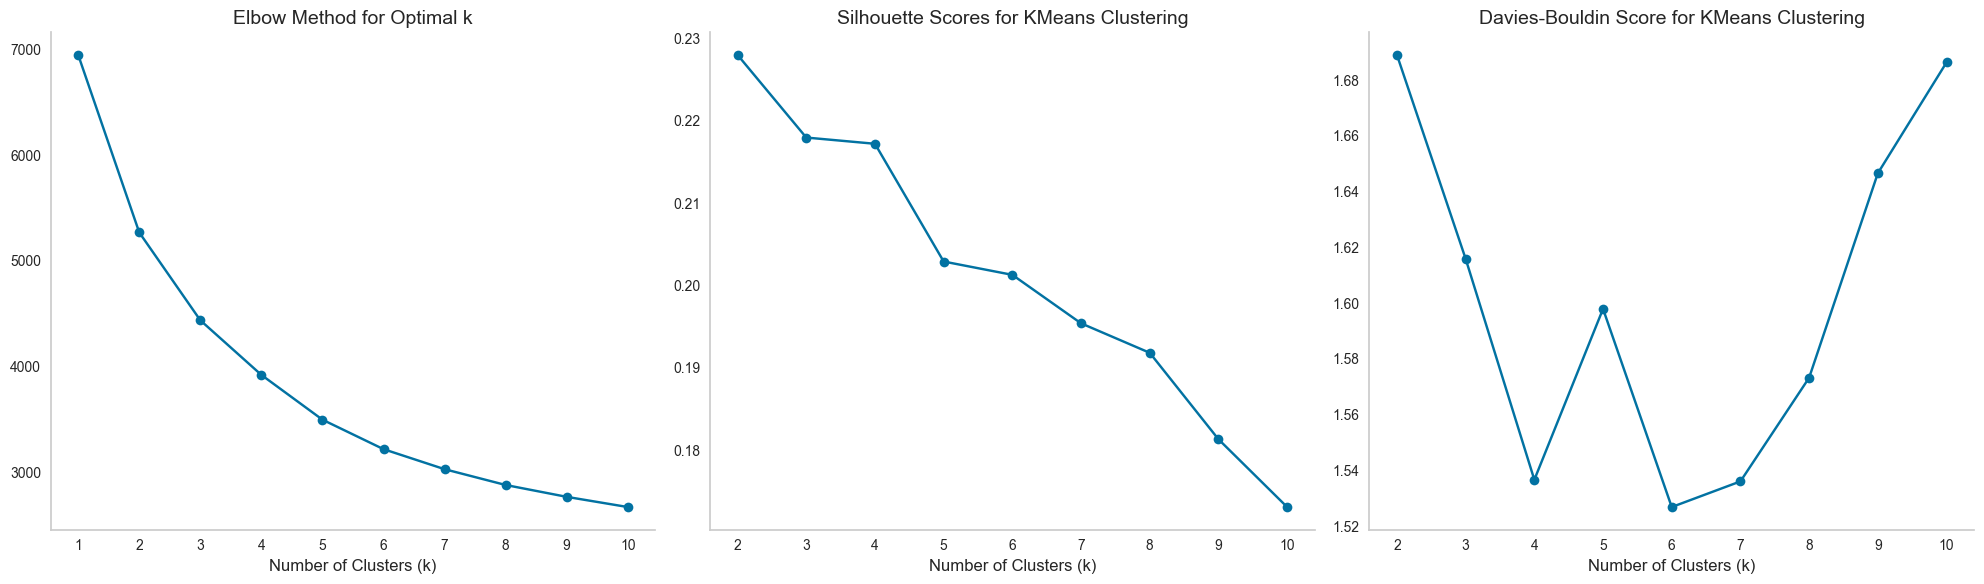

In [57]:
# Plot without hyperparameters tuning
plot_kmeans_metrics(data, n_init=10, max_iter=100, tol=0.0001)

Testing 576 combinations...

Best hyperparameter combination:
k: 4
n_init: 30
max_iter: 50
tol: 0.001
silhouette_score: 0.21783837864616284
davies_bouldin_score: 1.5284780813386034
combined_score: -1.3106397026924406

Plotting results for best combination: k=4, n_init=30, max_iter=50, tol=0.001


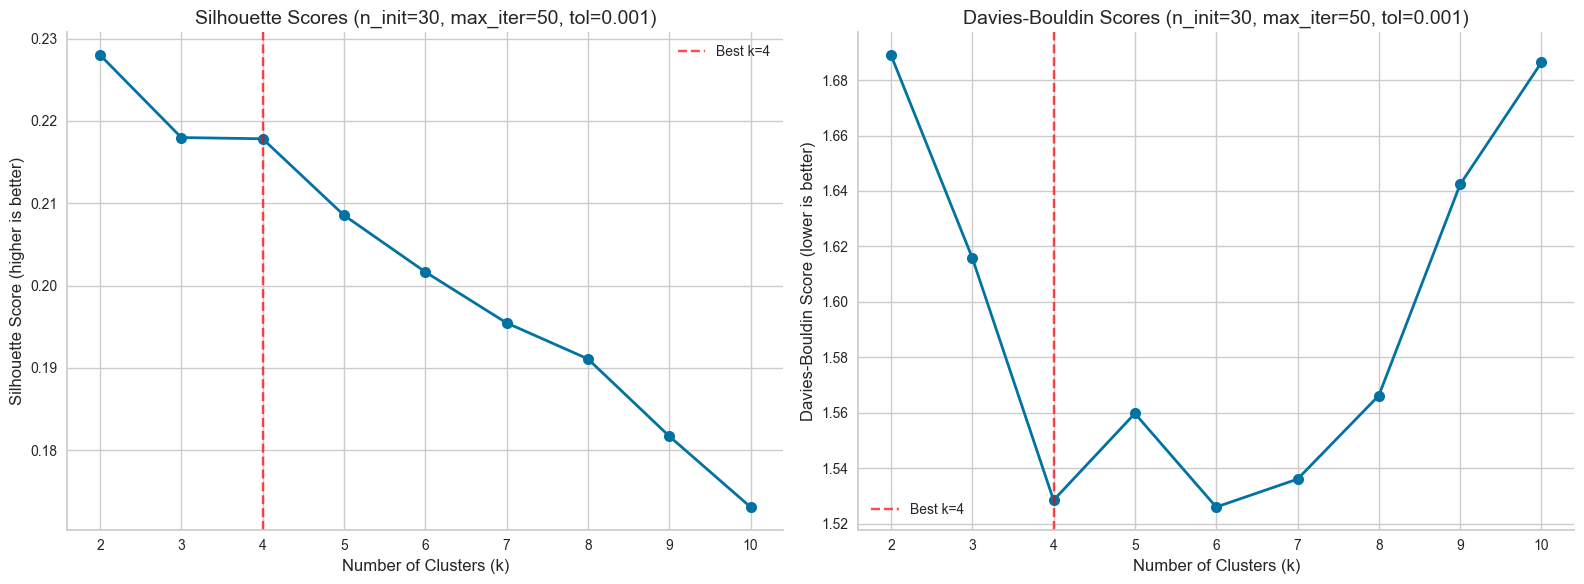

In [58]:
# Hyperparameter tuning
best_params_for_data = run_kmeans_optimization(data, sample_size=5000)

<div class="alert alert-block alert-info">

Despite extensive hyperparameter tuning, the score variations are minimal, indicating that any combination of parameters can be chosen without significantly affecting the selection of k (I choose n_init=10, max_iter=100, tol=0.0001).

In general, the silhouette score is very low, and the Davies-Bouldin score is pretty high, indicating that the clusters have a very weak to no structures for all k.

To further examine the clustering, we can select k = 3, 4 as the number of clusters to inspect how the cluster structure changes.

Rule of thumb for Silhouette score:

* s<sub>C</sub> >0.7: strong structure
* 0.7 ≥ s<sub>C</sub> >0.5: usable structure
* 0.5 ≥ s<sub>C</sub> >0.25: weak structure
* 0.25 ≥ s<sub>C</sub>: no structure
</div>

#### 6.1.2.2. Result 1

Cluster
1    242
0    189
2    148
Name: count, dtype: int64


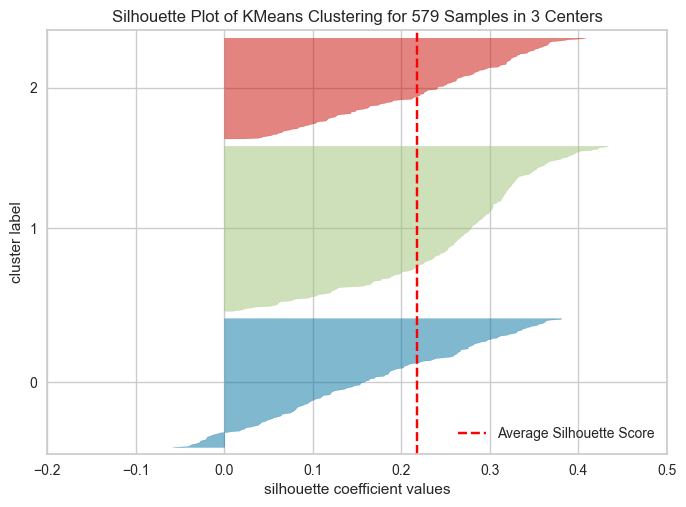

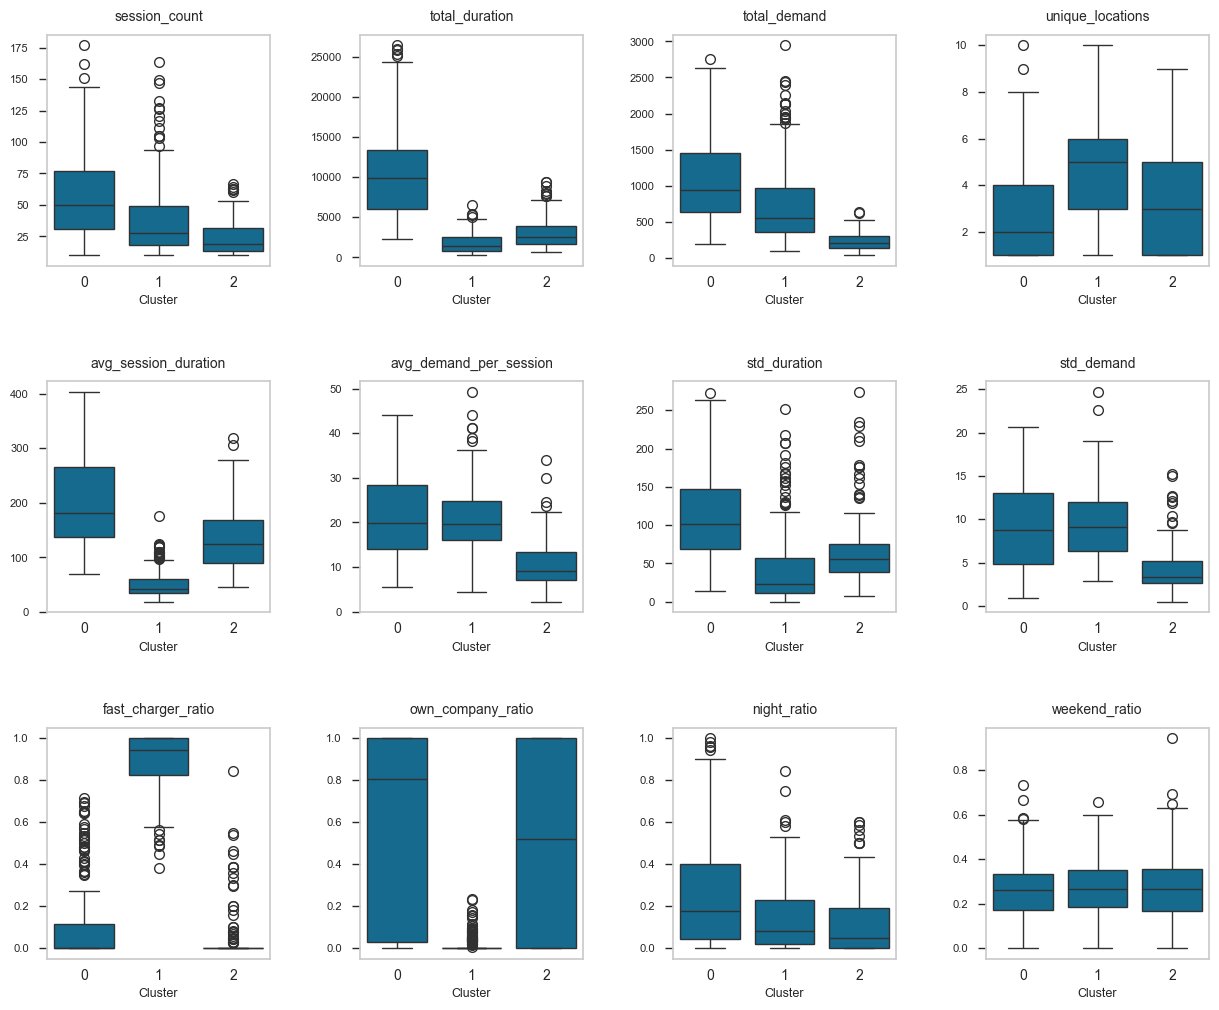

In [59]:
kmeans_data_cluster_results_1 = perform_kmeans_clustering(data, k=3, n_init=10, max_iter=100, tol=0.0001)

In [60]:
kmeans_data_cluster_results_1

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        0  
3             0.235294        0  
6             0.226415        0  
7             0.275362        0  
8             0.270492        0  
...                ...      ...  
2356          0.205128        2  
2388          0.500000        1  
2393          0.500000        2  
2421          0.105263        0  
2464          0.300000        2  

[579 rows x 13 columns]

Result Interpretation:
* Cluster 0 - "Loyal Power Users": High-frequency users (highest session_count, total_duration, total_demand) with variable charging patterns (high std_duration, std_demand). They visit fewer unique locations but show strong company loyalty (high own_company_ratio) and minimal fast charger usage.

* Cluster 1 - "Fast-Charging Explorers": Moderate-frequency users with the most diverse location usage (highest unique_locations). Distinguished by highest fast_charger_ratio (~0.9) but lowest company loyalty (lowest own_company_ratio).

* Cluster 2 - "Occasional Brand Loyalists": Low-frequency, low-demand users (lowest session_count, total_demand) with moderate location diversity. They show high company loyalty (highest own_company_ratio) but longer average session durations than Cluster 1.

#### 6.1.2.3. Result 2

Cluster
1    221
3    126
2    118
0    114
Name: count, dtype: int64


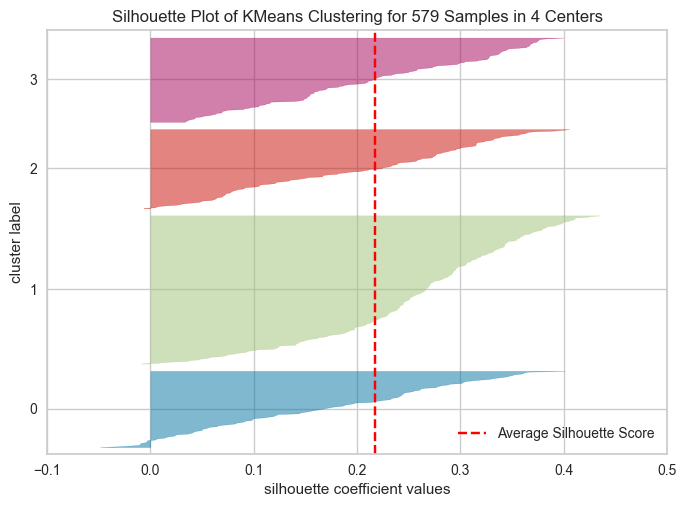

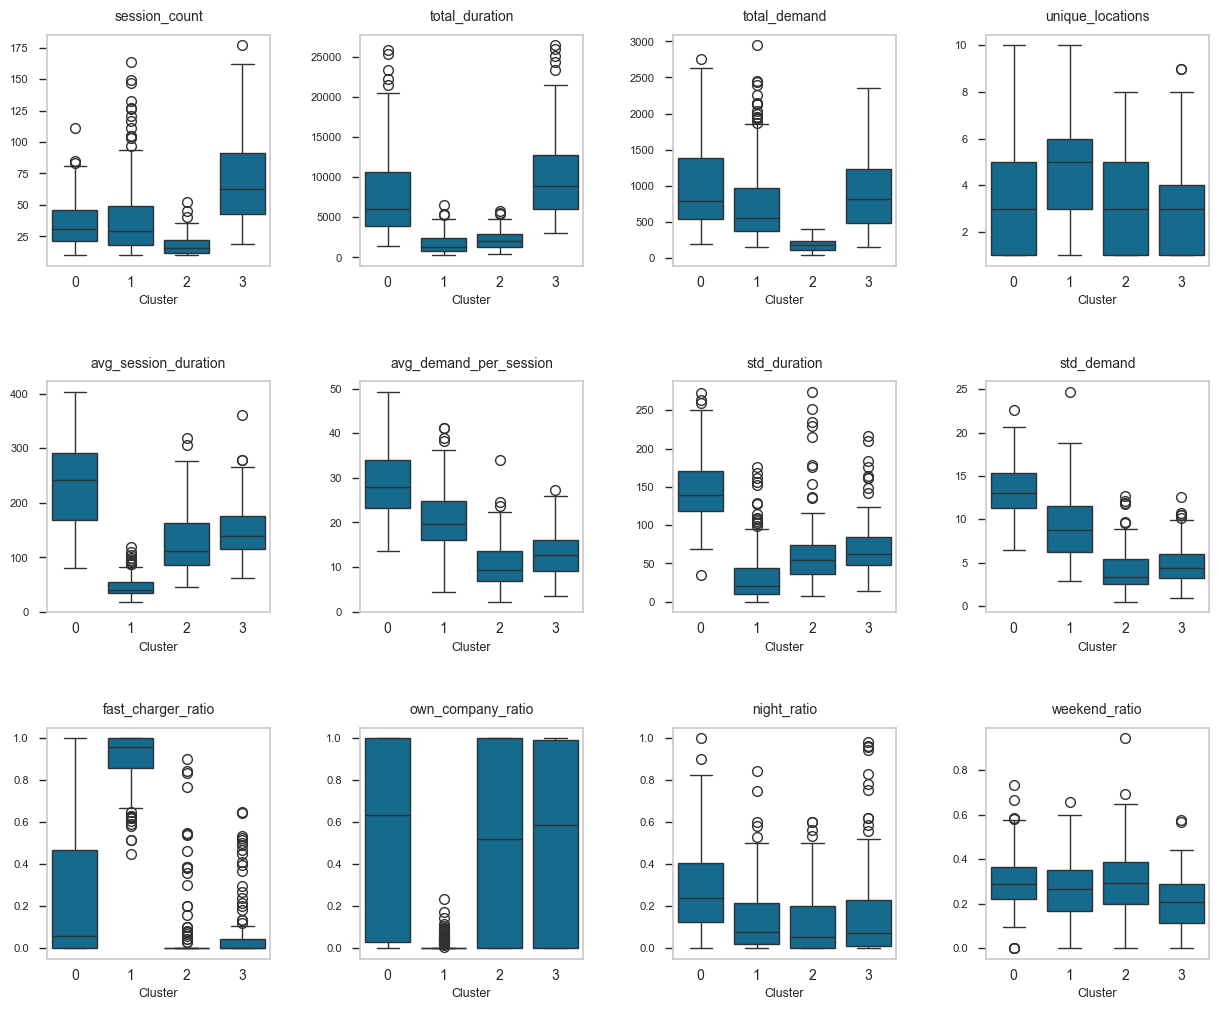

In [61]:
kmeans_data_cluster_results_2 = perform_kmeans_clustering(data, k=4, n_init=10, max_iter=100, tol=0.0001)

In [62]:
kmeans_data_cluster_results_2

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        0  
3             0.235294        0  
6             0.226415        0  
7             0.275362        3  
8             0.270492        3  
...                ...      ...  
2356          0.205128        3  
2388          0.500000        1  
2393          0.500000        2  
2421          0.105263        3  
2464          0.300000        2  

[579 rows x 13 columns]

In [63]:
kmeans_data_cluster_results_2['Cluster'].value_counts()

Cluster
1    221
3    126
2    118
0    114
Name: count, dtype: int64

Result Interpretation:

* Cluster 0 - "Steady Duration Loyalists": Moderate session frequency with the highest average session duration and demand per session. Shows strong company loyalty (high own_company_ratio), highest nighttime usage (night_ratio), and moderate weekend charging. Charging behavior is highly variable (highest std_duration and std_demand).

* Cluster 1 - "Fast-Charging Explorers": Moderate session frequency with the highest location diversity. Distinguished by highest fast_charger_ratio (~0.9) but lowest company loyalty. Primarily daytime users with moderate weekend usage.

* Cluster 2 - "Minimal Occasional Users": Lowest session count and total demand with short, consistent charging sessions. High company loyalty with moderate fast charger usage. Balanced between weekday/weekend charging.

* Cluster 3 - "High-Volume Power Users": Highest session count and total duration with moderate-to-high demand. Strong company loyalty with minimal fast 

### 6.1.3. data_pca

#### 6.1.3.1. Find optimal k

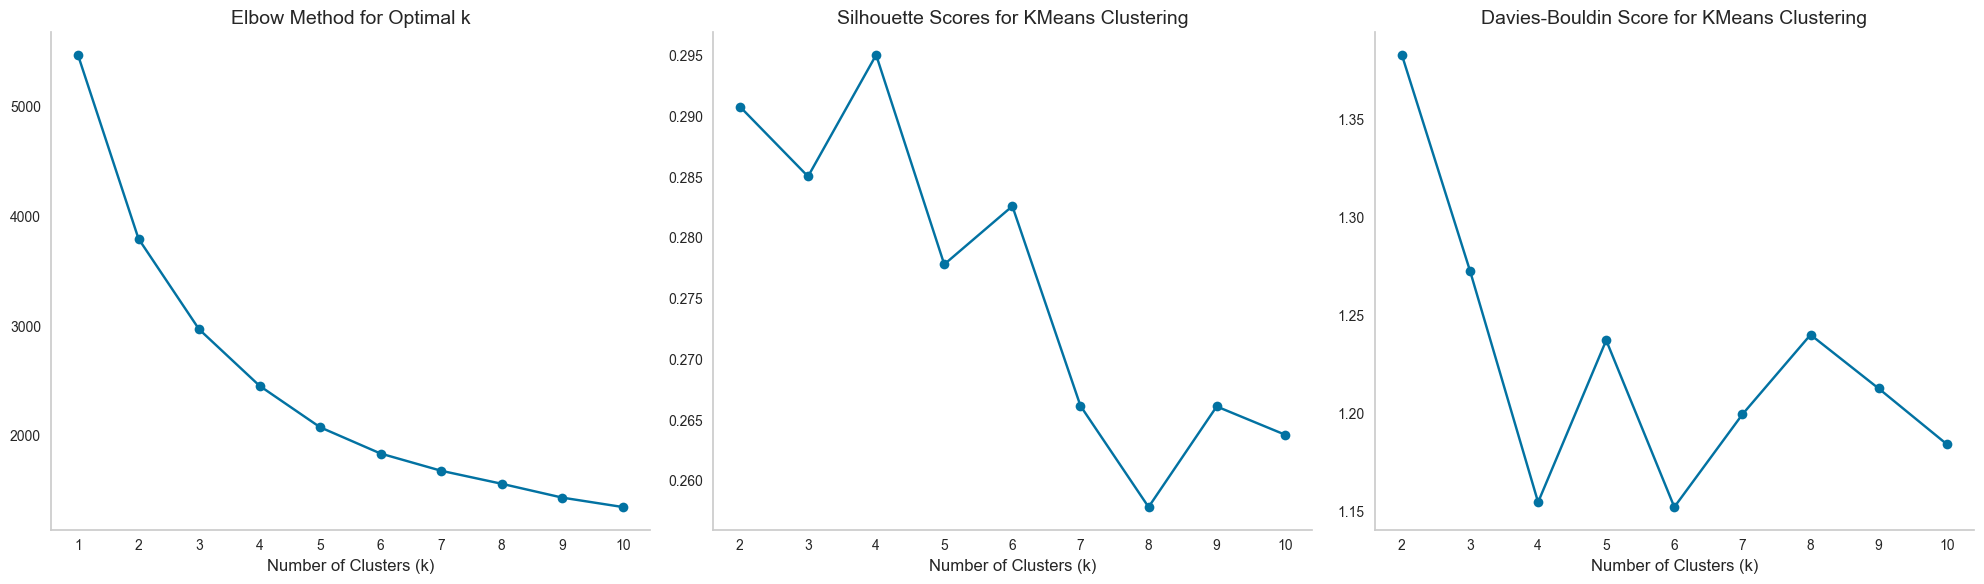

In [64]:
# Plot without hyperparameter tuning
plot_kmeans_metrics(data_pca, n_init=10, max_iter=100, tol=0.001)

Testing 576 combinations...

Best hyperparameter combination:
k: 4
n_init: 5
max_iter: 50
tol: 0.001
silhouette_score: 0.2950705098909959
davies_bouldin_score: 1.1549389552471807
combined_score: -0.8598684453561848

Plotting results for best combination: k=4, n_init=5, max_iter=50, tol=0.001


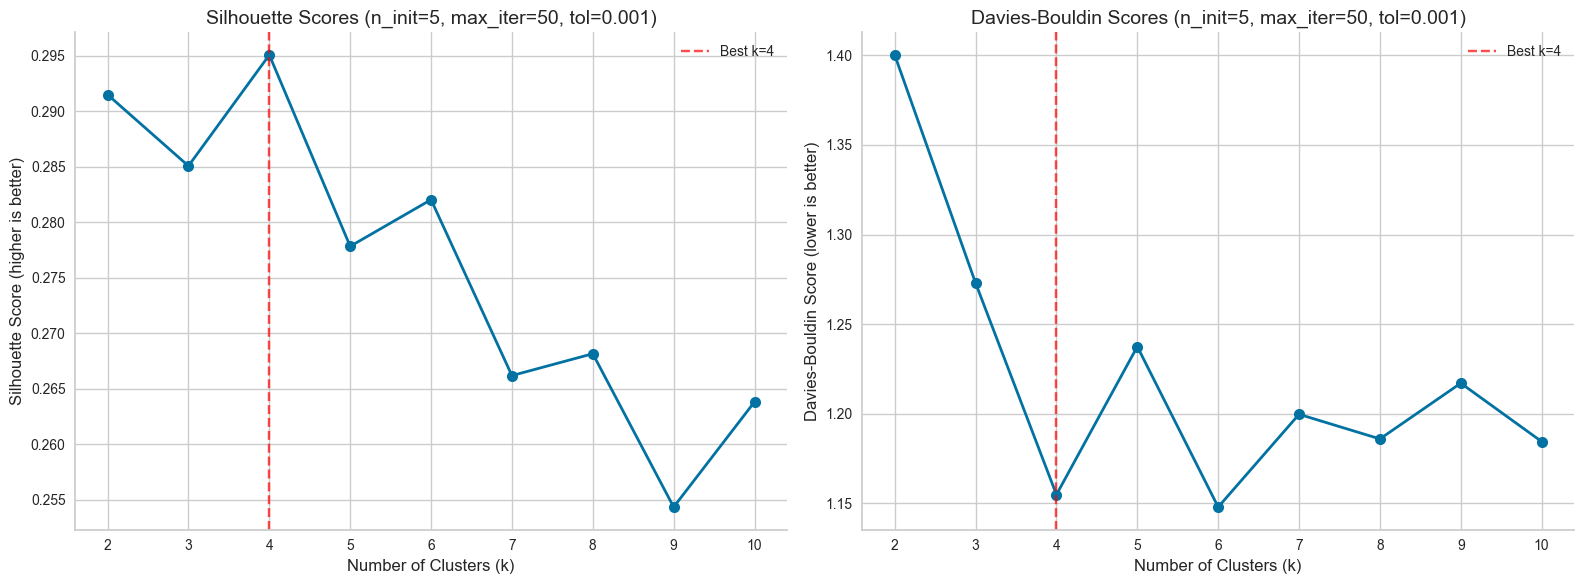

In [65]:
# Hyperparameter tuning
best_params_for_data_pca = run_kmeans_optimization(data_pca, sample_size=5000)

<div class="alert alert-block alert-info">

The result shows a slight improvement when using data_pca.

However, despite extensive hyperparameter tuning, the score variations are still minimal, indicating that any combination of parameters can be chosen without significantly affecting the selection of k (I choose n_init=10, max_iter=100, tol=0.0001).

</div>

#### 6.1.3.2. Result 1

Cluster
2    229
3    128
1    121
0    101
Name: count, dtype: int64


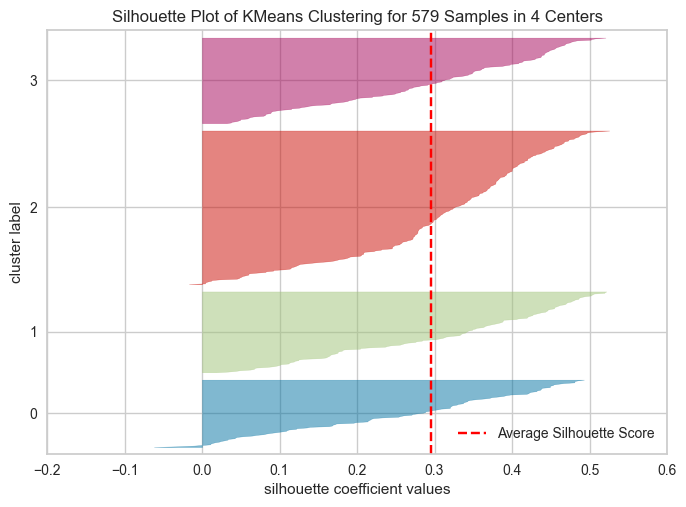

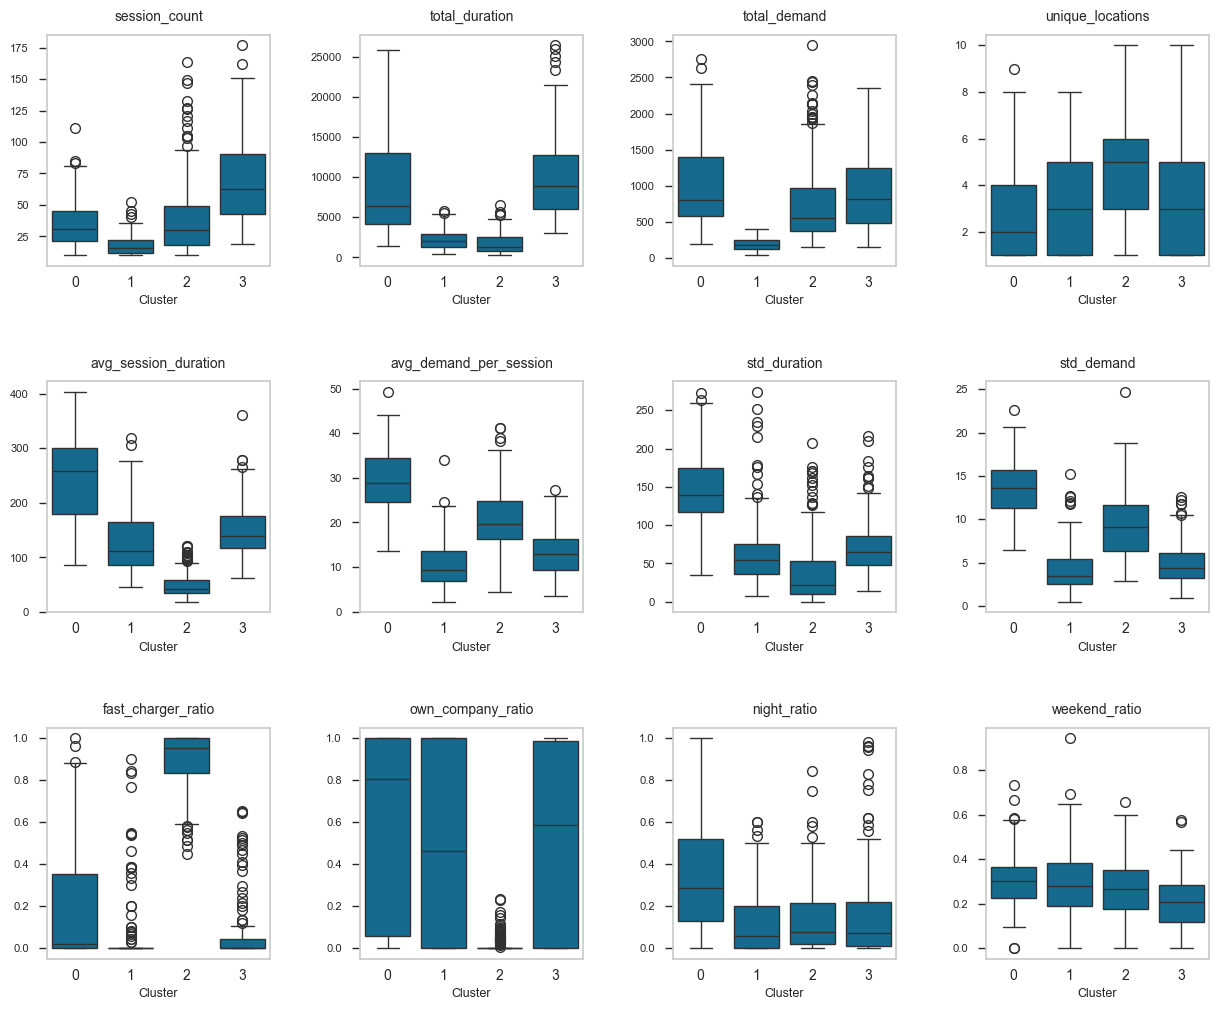

In [66]:
kmeans_data_pca_cluster_results_1 = perform_kmeans_clustering(data_pca, k=4, n_init=10, max_iter=100, tol=0.0001)

In [67]:
kmeans_data_pca_cluster_results_1

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        0  
3             0.235294        0  
6             0.226415        0  
7             0.275362        3  
8             0.270492        3  
...                ...      ...  
2356          0.205128        3  
2388          0.500000        2  
2393          0.500000        1  
2421          0.105263        3  
2464          0.300000        1  

[579 rows x 13 columns]

Result Interpretation:

* Cluster 0 - "Long-Session Loyalists": Moderate session frequency with highest average session duration and demand per session. Shows strong company loyalty, highest nighttime usage, and moderate weekend charging. Charging behavior is highly variable (highest std_duration and std_demand).

* Cluster 1 - "Low-Usage Experimenters": Lowest session count with minimal duration and demand. Moderate company loyalty with very low fast charger usage. Primarily daytime users with moderate weekend usage.

* Cluster 2 - "Fast-Charging Nomads": Moderate session frequency with highest fast_charger_ratio (~0.9) and highest location diversity. Notably lowest company loyalty. Short but consistent charging sessions with moderate demand.

* Cluster 3 - "High-Volume Regulars": Highest session count and total duration with moderate demand. Strong company loyalty with minimal fast charger usage. Charging patterns show moderate variability and lowest weekend usage ratio.

#### 6.1.3.3. Result 2

Cluster
5    122
0    111
3    106
1     88
4     83
2     69
Name: count, dtype: int64


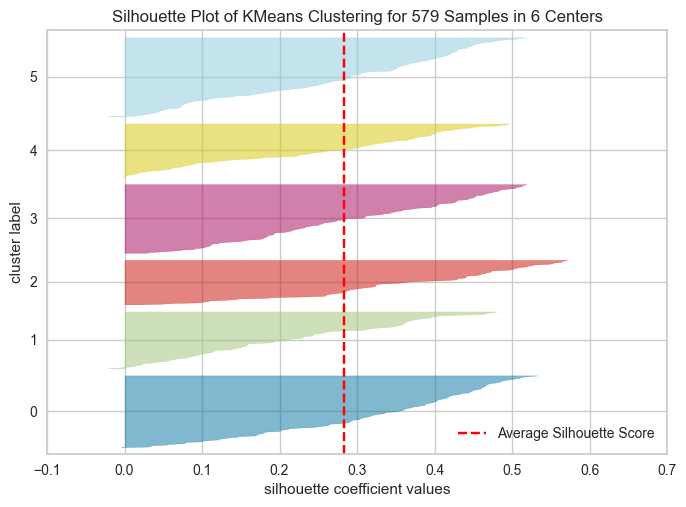

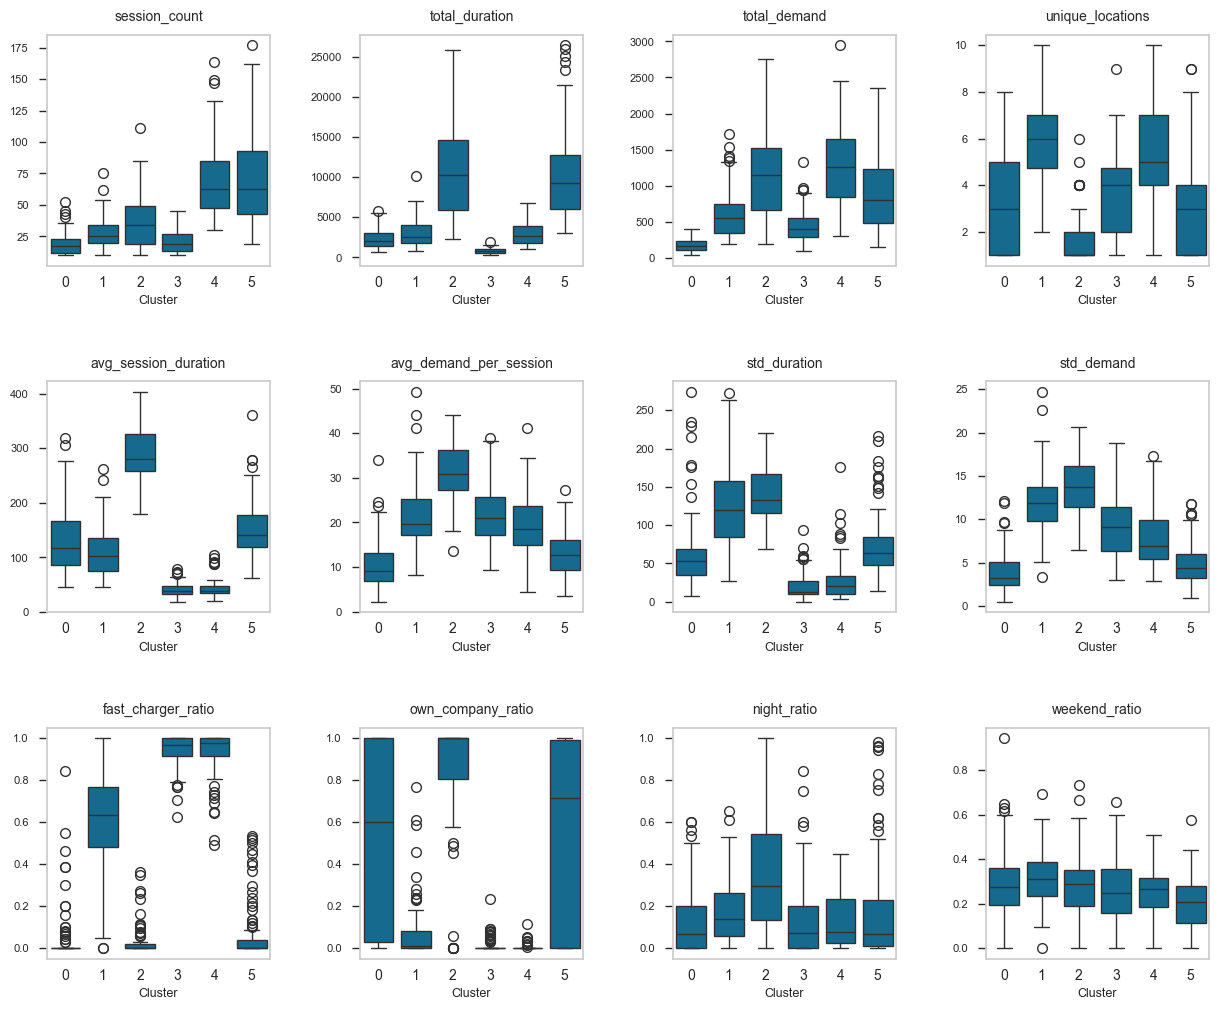

In [68]:
kmeans_data_pca_cluster_results_2 = perform_kmeans_clustering(data_pca, k=6, n_init=10, max_iter=100, tol=0.0001)

In [69]:
kmeans_data_pca_cluster_results_2

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        2  
3             0.235294        1  
6             0.226415        2  
7             0.275362        5  
8             0.270492        5  
...                ...      ...  
2356          0.205128        5  
2388          0.500000        3  
2393          0.500000        0  
2421          0.105263        5  
2464          0.300000        0  

[579 rows x 13 columns]

In [70]:
kmeans_data_pca_cluster_results_2['Cluster'].value_counts()

Cluster
5    122
0    111
3    106
1     88
4     83
2     69
Name: count, dtype: int64

Result Interpretation:

* Cluster 0 - "Minimal Occasional Users": Lowest usage across session_count, total_duration, and total_demand. Low fast charger usage with moderate company loyalty. Moderate location diversity with primarily daytime charging.

* Cluster 1 - "Location Explorers": Moderate usage with highest location diversity. Medium fast charger usage with low company loyalty. Shows moderate weekend and night charging patterns.

* Cluster 2 - "Long-Duration Loyalists": Moderate session frequency but highest average session duration. Strong company loyalty with moderate demand per session. Shows highest variability in duration and demand.

* Cluster 3 - "Fast-Charging Specialists": Low session count and short durations but highest fast_charger_ratio (~1.0). Minimal company loyalty with consistent, predictable charging patterns (low std_duration).

* Cluster 4 - "High-Volume Power Users": Highest session count and among highest total duration and demand. Moderate location diversity with high fast charger usage. Balanced day/night charging patterns.

* Cluster 5 - "Loyal Frequent Users": High session count and total duration with moderate demand. Highest company loyalty with minimal fast charger usage. Shows lowest weekend usage ratio.

## 6.2. OPTICS

<div class="alert alert-block alert-info">

OPTICS (Ordering Points To Identify the Clustering Structure) is a density-based clustering algorithm that addresses several limitations of traditional clustering methods like K-means. Unlike K-means, which requires pre-specifying the number of clusters and assumes spherical cluster shapes, OPTICS identifies clusters based on density connectivity between data points.

The algorithm works by:

* Computing a special ordering of data points based on their density relationships
* dentifying core points that have a sufficient number of neighbors within a specified radius (ε)
* Calculating a reachability distance for each point, which measures how "reachable" it is from other points
* Creating a reachability plot that reveals the density-based clustering structure
* Extracting clusters from valleys in the reachability plot

OPTICS introduces two key parameters:

* min_samples: The minimum number of points required to form a dense region
* max_eps: The maximum distance to consider when identifying neighboring points (can be set to infinity)

</div>

<div class="alert alert-block alert-info">

OPTICS appears particularly well-suited for our dataset for several reasons:

* Weak cluster structure: Our K-means analysis revealed relatively low silhouette scores and high Davies-Bouldin indices, indicating that our data doesn't naturally form well-separated, spherical clusters. OPTICS excels at finding clusters in data with complex structures where traditional algorithms struggle.

* No predefined number of clusters: Our K-means experiments tested multiple values of K (3, 4, and 6) without clear consensus on the optimal number. OPTICS doesn't require specifying the number of clusters beforehand, instead discovering them naturally based on density patterns.

* Variable density clusters: The boxplots from our K-means analysis suggest considerable overlap between clusters across multiple features. OPTICS can identify clusters of varying densities and shapes, making it ideal for datasets where clusters may have different characteristics.

* Noise handling: Our dataset likely contains outliers or noise points that don't belong to any natural cluster, as evidenced by the scattered distribution in our PCA visualization. OPTICS can explicitly identify these as noise points rather than forcing them into clusters.

* Hierarchical structure: The PCA visualization suggests our data might have a hierarchical or nested cluster structure. OPTICS produces a reachability plot that reveals hierarchical relationships between clusters, allowing us to identify both macro and micro-level patterns.

</div>

To visually assess the clustering structure, I will examine the reachability plot. A clear separation between clusters and noise indicates well-defined clustering.

### 6.2.1. Setup

In [71]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

In [72]:
def perform_optics_clustering(data, min_samples, xi, min_cluster_size):

    optics = OPTICS(min_samples=min_samples, 
                   metric='euclidean', 
                   xi=xi, 
                   min_cluster_size=min_cluster_size)
    optics.fit(data)
    
    labels_xi = optics.labels_

    print("Unique clusters for xi-based clustering:", np.unique(labels_xi))
    for k, v in dict(zip(*np.unique(labels_xi, return_counts=True))).items():
        print(f"Cluster: {k}, count: {v}")
    

    result_optics = data_pre_transform_scale.copy()
    result_optics['Cluster'] = labels_xi
    
    space = np.arange(len(data_pre_transform_scale))
    reachability = optics.reachability_[optics.ordering_]
    
    plt.figure(figsize=(8, 4))
    colors = ['g.', 'r.', 'b.', 'y.', 'c.', 'm.']
    for klass, color in zip(range(0, 6), colors):
        Xk = space[labels_xi[optics.ordering_] == klass]
        Rk = reachability[labels_xi[optics.ordering_] == klass]
        if len(Xk) > 0:  # Only plot if the cluster exists
            plt.plot(Xk, Rk, color, alpha=0.3)
    plt.plot(space[labels_xi[optics.ordering_] == -1], reachability[labels_xi[optics.ordering_] == -1], 'k.', alpha=0.3)
    plt.title('Reachability Plot with xi-based Clustering',pad=10)
    plt.xlabel('Points (ordered by processing)', fontsize=9)
    plt.ylabel('Reachability Distance', fontsize=9)
    plt.yticks(fontsize=8)
    plt.grid(False)
    plt.tick_params(axis='y', which='both', direction='out', length=5)

    plt.tight_layout()
    plt.show()
    

    # Generate boxplots
    data_filtered = result_optics[result_optics['Cluster'] != -1]

    features_to_plot = [col for col in result_optics.columns if col != 'Cluster']
        
    n_cols = 4
    n_rows = 3
        
    plt.figure(figsize=(15, n_rows * 4))

    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x='Cluster', y=feature, data=result_optics)
        plt.grid(False)
        plt.title(feature, fontsize=10, pad=10)
        plt.xlabel('Cluster', fontsize=9)
        plt.ylabel('')
        plt.yticks(fontsize=8)
        plt.tick_params(axis='y', which='both', direction='out', length=5)

    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    plt.show()

    return result_optics


### 6.2.2. data

#### 6.2.2.1. Result 1

Unique clusters for xi-based clustering: [-1  0  1  2]
Cluster: -1, count: 339
Cluster: 0, count: 76
Cluster: 1, count: 124
Cluster: 2, count: 40


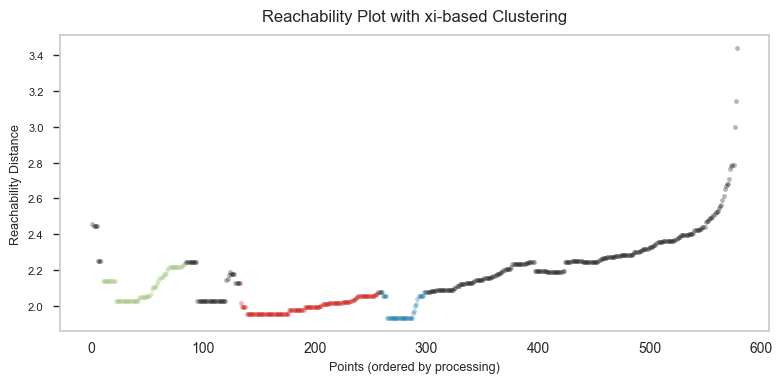

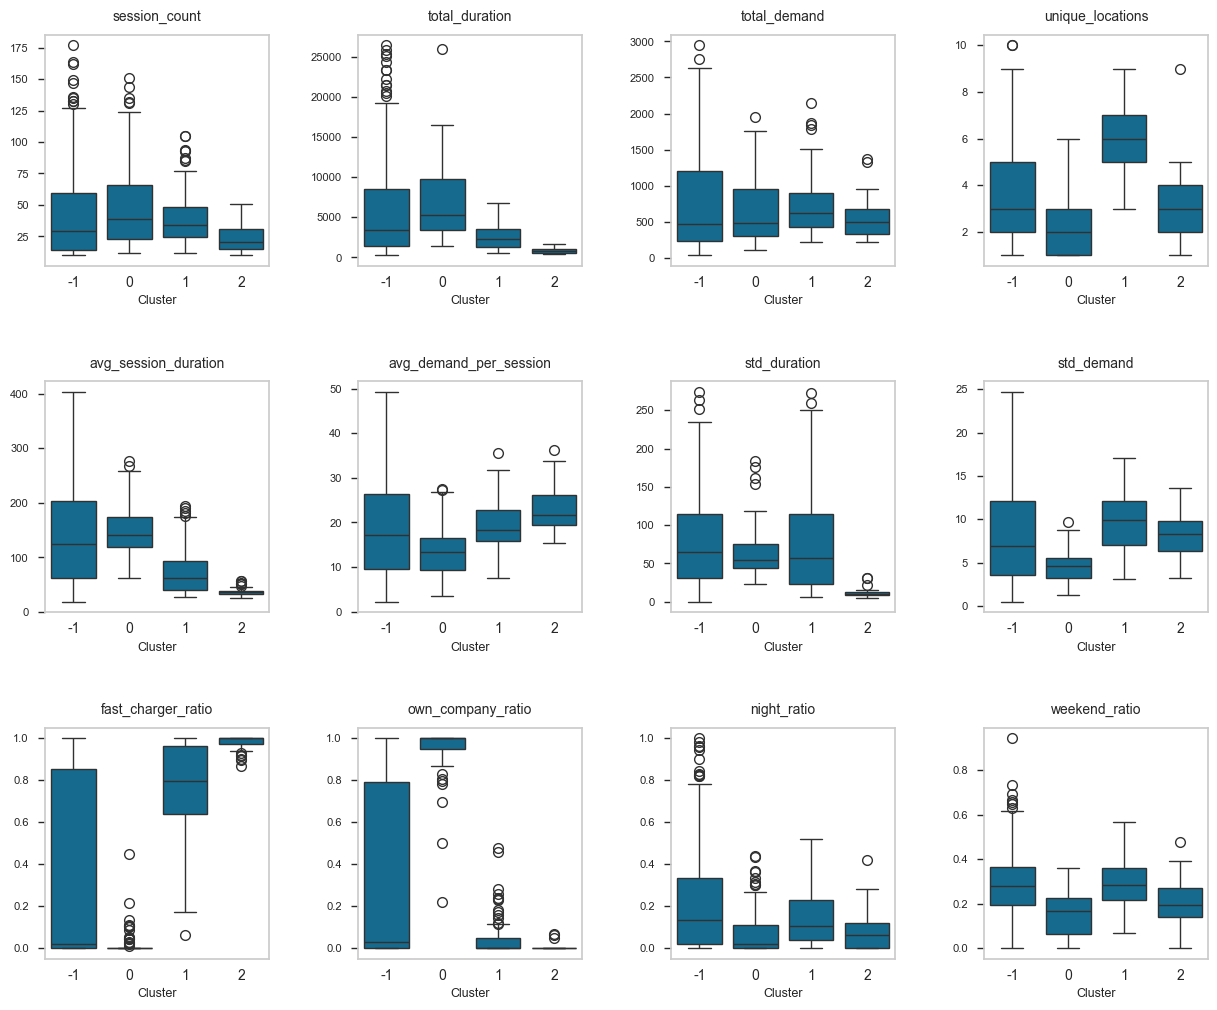

In [73]:
optics_data_cluster_results_1 = perform_optics_clustering(data, min_samples=30, xi=0.001, min_cluster_size=40)

In [74]:
optics_data_cluster_results_1

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051       -1  
3             0.235294       -1  
6             0.226415       -1  
7             0.275362       -1  
8             0.270492       -1  
...                ...      ...  
2356          0.205128        0  
2388          0.500000       -1  
2393          0.500000       -1  
2421          0.105263        0  
2464          0.300000       -1  

[579 rows x 13 columns]

Result Interpretation:
* Cluster -1 - "Variable Behavior Outliers" (Noise): Moderate-to-high usage with high variability across all metrics. Shows extreme values in night_ratio and fast_charger_ratio. Highly inconsistent charging patterns with wide ranges in duration and demand standard deviations.

* Cluster 0 - "Loyal Moderate Users": Moderate session frequency and duration with strong company loyalty (highest own_company_ratio). Low fast charger usage with primarily daytime charging and minimal weekend usage.

* Cluster 1 - "Fast-Charging Location Hoppers": Moderate session count with highest location diversity. Distinguished by high fast_charger_ratio (~0.8) but minimal company loyalty. Shows highest weekend usage ratio among all clusters.

* Cluster 2 - "Consistent Low-Duration Users": Lowest session count and shortest average duration but relatively stable demand per session. Nearly perfect fast_charger_ratio (~1.0) with minimal company loyalty. Remarkably consistent charging patterns (lowest std_duration).

#### 6.2.2.2. Result 2

Unique clusters for xi-based clustering: [-1  0  1  2]
Cluster: -1, count: 487
Cluster: 0, count: 38
Cluster: 1, count: 27
Cluster: 2, count: 27


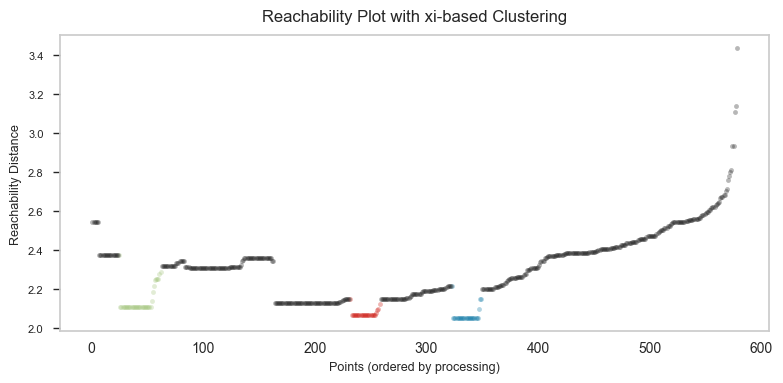

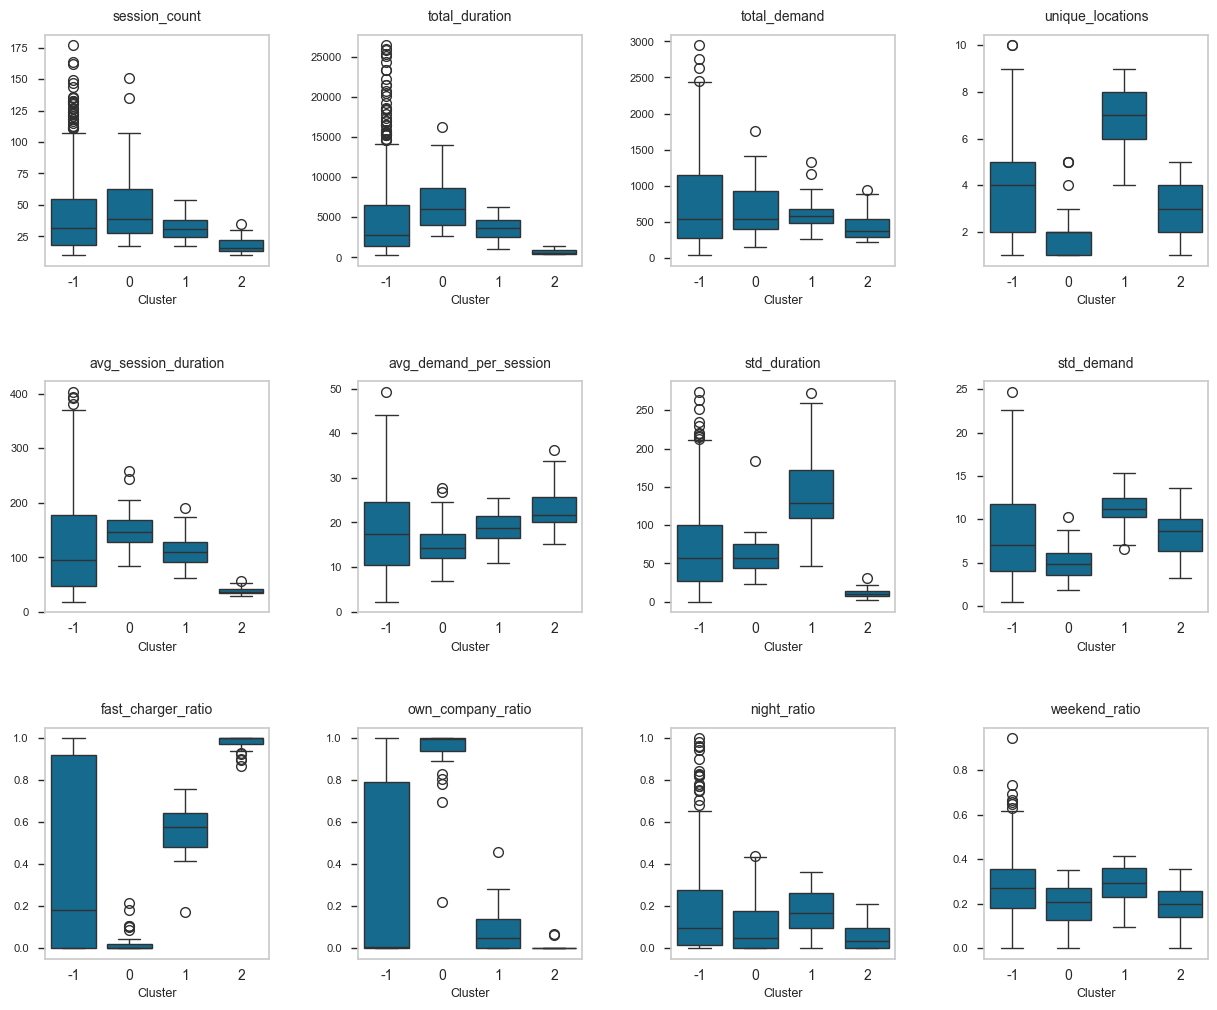

In [75]:
optics_data_cluster_results_2 = perform_optics_clustering(data, min_samples=40, xi=0.01, min_cluster_size=20)

In [76]:
optics_data_cluster_results_2

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051       -1  
3             0.235294       -1  
6             0.226415       -1  
7             0.275362       -1  
8             0.270492       -1  
...                ...      ...  
2356          0.205128        0  
2388          0.500000       -1  
2393          0.500000       -1  
2421          0.105263        0  
2464          0.300000       -1  

[579 rows x 13 columns]

Result Interpretation:

* Cluster -1 - "High-Variance Power Users" (Noise): Highest session count and total duration with extreme variability. Shows wide-ranging behavior in fast_charger_ratio, night_ratio, and company loyalty. Represents outliers with inconsistent charging patterns.

* Cluster 0 - "Loyal Standard Users": Moderate session frequency and duration with highest company loyalty (nearly 100% own_company_ratio). Minimal fast charger usage with primarily daytime charging and moderate weekend usage.

* Cluster 1 - "Location-Diverse Medium Users": Moderate session count with highest location diversity. Distinguished by moderate fast_charger_ratio (~0.6) but low company loyalty. Shows highest variability in duration (std_duration) and highest weekend usage.

* Cluster 2 - "Quick-Charge Specialists": Lowest session count and shortest average duration but highest demand per session. Nearly perfect fast_charger_ratio (~1.0) with minimal company loyalty. Remarkably consistent charging patterns (lowest std_duration).

### 6.2.3. data_pca

#### 6.2.3.1. Result 1

Unique clusters for xi-based clustering: [-1  0  1  2]
Cluster: -1, count: 405
Cluster: 0, count: 58
Cluster: 1, count: 36
Cluster: 2, count: 80


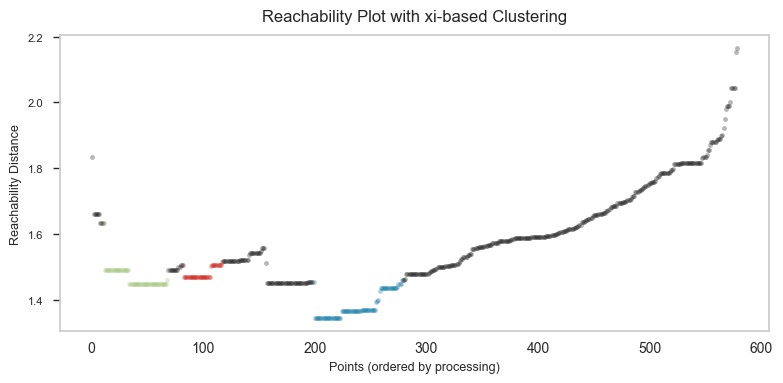

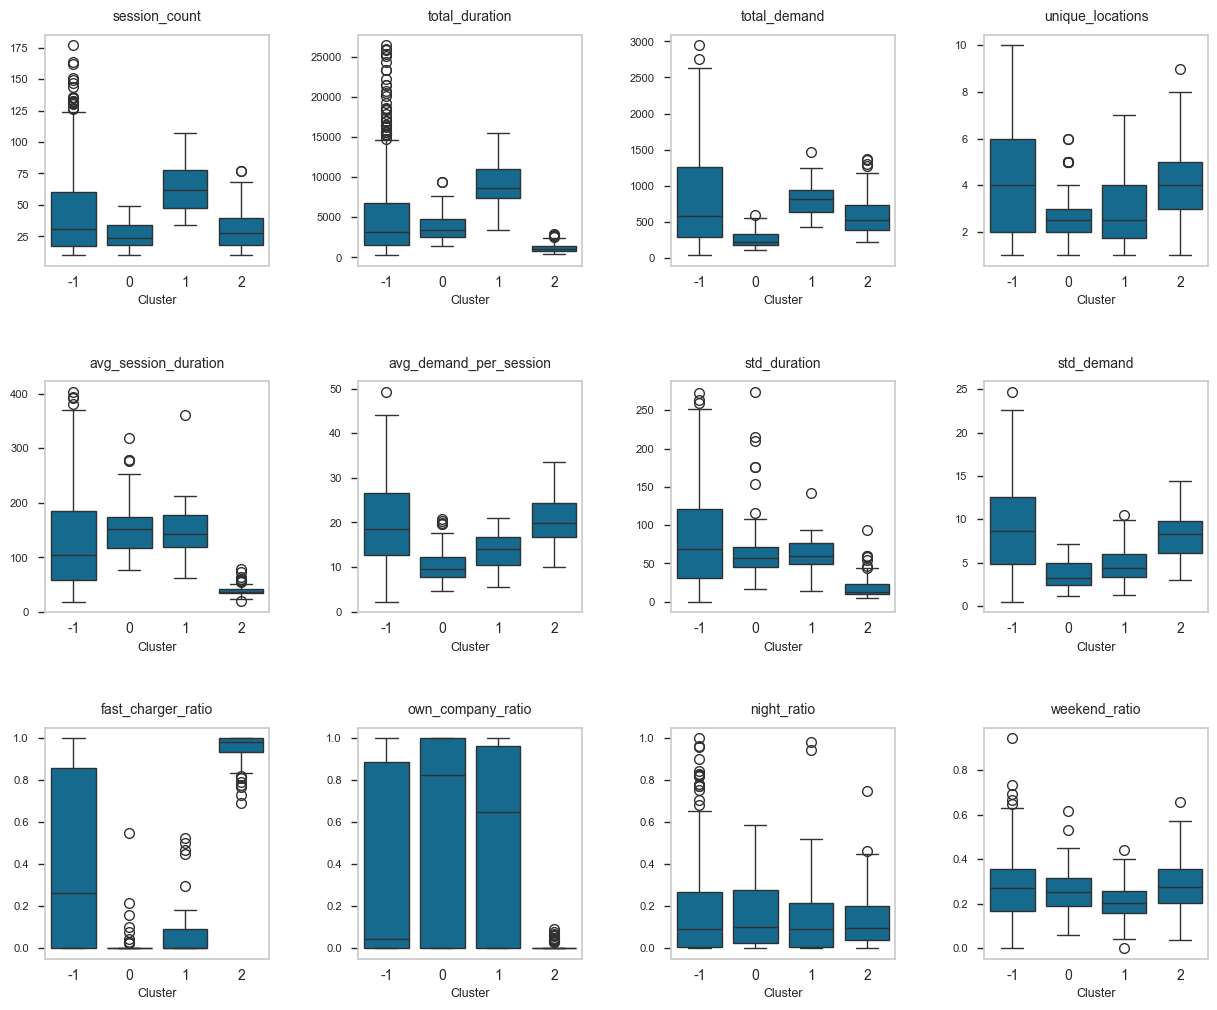

In [77]:
optics_data_pca_cluster_results_1 = perform_optics_clustering(data_pca, min_samples=40, xi=0.01, min_cluster_size=20)

In [78]:
optics_data_pca_cluster_results_1

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051       -1  
3             0.235294       -1  
6             0.226415       -1  
7             0.275362       -1  
8             0.270492       -1  
...                ...      ...  
2356          0.205128        0  
2388          0.500000       -1  
2393          0.500000       -1  
2421          0.105263       -1  
2464          0.300000       -1  

[579 rows x 13 columns]

Result interpretation:

* Cluster -1 - "Inconsistent Power Users" (Noise): Highly variable usage patterns with wide ranges across all metrics. Shows extreme values in session_count, total_duration, and demand. Represents outliers with unpredictable charging behavior and high variability.

* Cluster 0 - "Minimal Loyal Users": Lowest session count and total demand with moderate duration. High company loyalty (high own_company_ratio) with minimal fast charger usage. Limited location diversity and consistent low-demand charging patterns.

* Cluster 1 - "Medium-Volume Regulars": Highest session count and total duration with moderate demand. Strong company loyalty with minimal fast charger usage. Moderate location diversity with consistent charging patterns.

* Cluster 2 - "Fast-Charging Specialists": Low session count but high demand per session. Nearly perfect fast_charger_ratio (~1.0) with minimal company loyalty. Remarkably short and consistent charging durations (lowest avg_session_duration and std_duration) with highest location diversity.

#### 6.2.3.2. Result 2

Unique clusters for xi-based clustering: [-1  0  1  2]
Cluster: -1, count: 405
Cluster: 0, count: 58
Cluster: 1, count: 36
Cluster: 2, count: 80


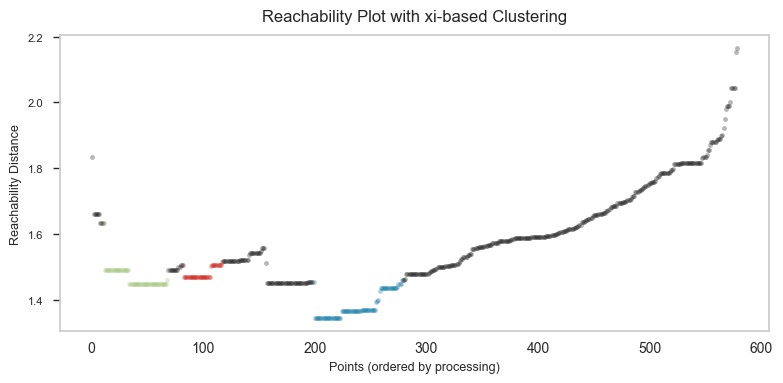

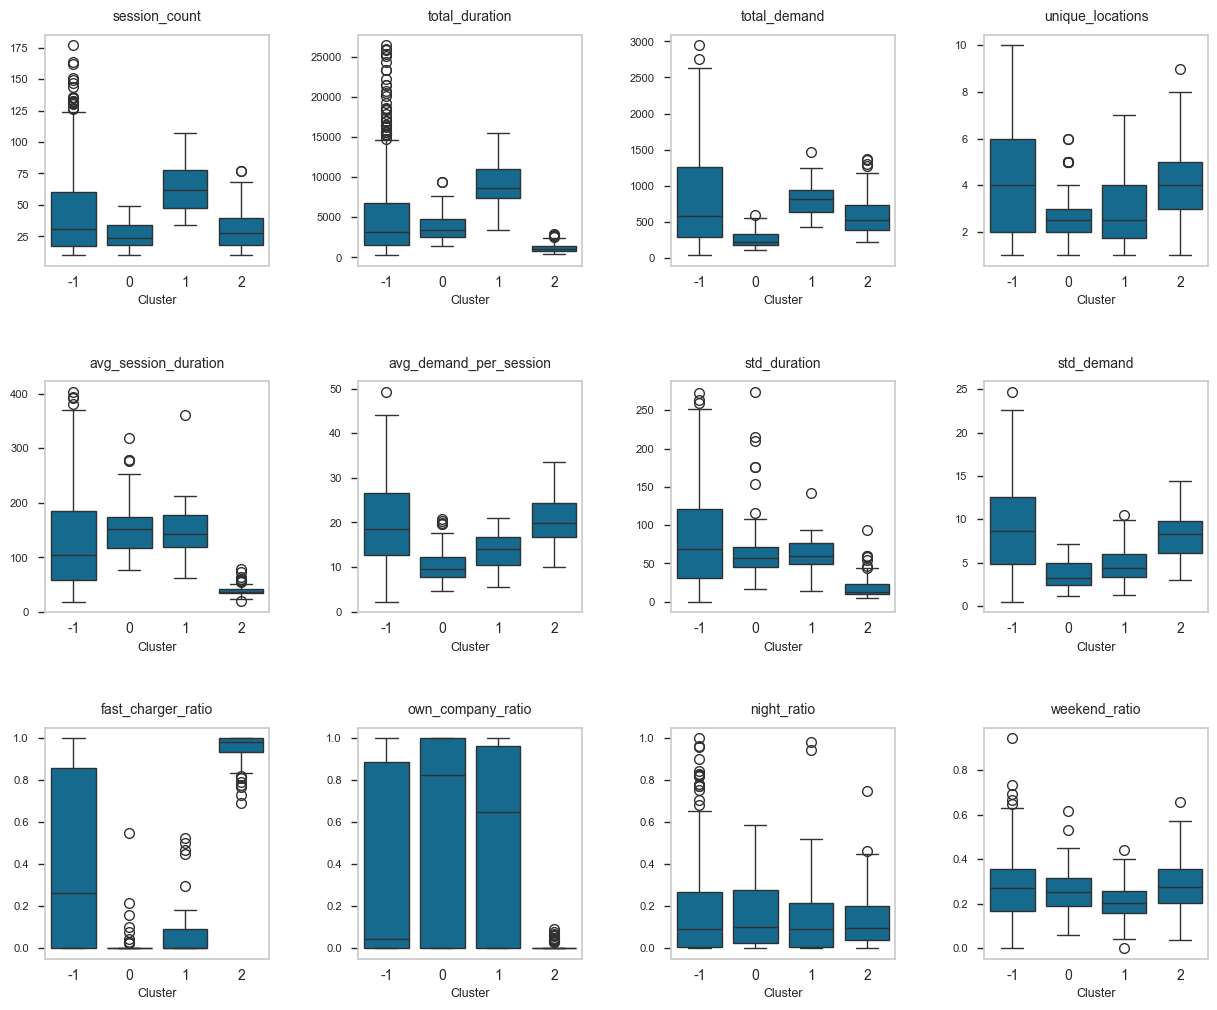

In [79]:
optics_data_pca_cluster_results_2 = perform_optics_clustering(data_pca, min_samples=40, xi=0.01, min_cluster_size=20)

In [80]:
optics_data_pca_cluster_results_2


session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051       -1  
3             0.235294       -1  
6             0.226415       -1  
7             0.275362       -1  
8             0.270492       -1  
...                ...      ...  
2356          0.205128        0  
2388          0.500000       -1  
2393          0.500000       -1  
2421          0.105263       -1  
2464          0.300000       -1  

[579 rows x 13 columns]

Result interpretation:

* Cluster -1 - "Extreme Variability Users" (Noise): Highly inconsistent usage patterns with extreme values across all metrics. Shows wide ranges in session_count, total_duration, and demand. Represents outliers with unpredictable charging behavior.

* Cluster 0 - "Minimal Loyal Users": Lowest session count and total demand with moderate duration. High company loyalty (high own_company_ratio) with minimal fast charger usage. Limited location diversity and consistent low-demand charging patterns.

* Cluster 1 - "Steady Volume Regulars": Highest session count and total duration with moderate demand. Moderate company loyalty with minimal fast charger usage. Balanced charging patterns with consistent demand.

* Cluster 2 - "Quick-Charge Specialists": Low session count but high demand per session. Nearly perfect fast_charger_ratio (~1.0) with minimal company loyalty. Remarkably short and consistent charging durations (lowest avg_session_duration and std_duration) with high location diversity.

## 6.3. HAC

<div class="alert alert-block alert-info">

Hierarchical Agglomerative Clustering (HAC) is a bottom-up clustering approach that builds nested clusters by progressively merging smaller clusters into larger ones. Unlike partition-based methods like K-means, HAC creates an entire hierarchy of clusters represented as a dendrogram, offering a multi-level view of the data structure.

The algorithm works through the following steps:

1. Initially treats each data point as a singleton cluster
2. Computes a distance/similarity matrix between all pairs of clusters
3. Merges the two closest clusters based on a linkage criterion
4. Updates the distance matrix to reflect the new clustering
5. Repeats steps 3-4 until all points belong to a single cluster


HAC offers several linkage methods that define how distances between clusters are measured:

* Ward's method: Minimizes the increase in variance when clusters are merged
* Complete linkage: Uses the maximum distance between any two points in different clusters
* Average linkage: Uses the average distance between all pairs of points in different clusters
* Single linkage: Uses the minimum distance between any two points in different clusters
</div>

<div class="alert alert-block alert-info">

HAC would be particularly valuable for our dataset for the following reasons:

* No need to specify cluster count: Our K-means experiments showed uncertainty in determining the optimal number of clusters. HAC eliminates this requirement by creating a complete hierarchy, allowing us to explore clustering at multiple levels and select the 
right dendrogram height.

* Visualization of cluster relationships: The dendrogram from HAC intuitively visualizes how data points relate, uncovering both fine and coarse cluster structures. This is especially useful given the complexity suggested by our PCA visualization.

* Flexibility in cluster shapes: Our K-means results indicated weak cluster separation with low silhouette scores. HAC with linkage methods such as Ward's or average linkage can identify non-spherical clusters that K-means might overlook.

* Robust to different distance Metrics: HAC enables experimentation with various distance metrics (Euclidean, Manhattan, etc.) and linkage methods, offering flexibility to find the best approach for our data's underlying structure.

* Interpretability: The dendrogram provides an interpretable visualization, revealing insights into natural groupings and subgroupings, potentially identifying relationships not apparent in the K-means analysis.

</div>

<div class="alert alert-block alert-info">

I'll use these 2 metrics to evaluate the quality of clustering:

* **Calinski-Harabasz Score**: Measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters with greater separation between groups and tighter cohesion within groups. Particularly effective for evaluating convex clusters of similar sizes.

* **Davies-Bouldin Score**: Measures the average similarity between each cluster and its most similar cluster. Lower values indicate better clustering with greater separation between clusters relative to their internal scatter. Less sensitive to the number of clusters and doesn't make assumptions about cluster shapes.

</div>

### 6.3.1 Setup

In [81]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster
from scipy.cluster.hierarchy import linkage as scipy_linkage
from scipy.cluster.hierarchy import set_link_color_palette

from sklearn.metrics import calinski_harabasz_score

In [82]:
def plot_hac_metrics(data, linkage_methods=['ward', 'complete', 'average', 'single'], max_clusters=10):

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    for ax in axs:
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, method in enumerate(linkage_methods):
        calinski_harabasz_scores = []
        davies_bouldin_scores = []
        
        for k in range(2, max_clusters + 1): 
            hac = AgglomerativeClustering(n_clusters=k, linkage=method)
            cluster_labels = hac.fit_predict(data)
            
            ch_score = calinski_harabasz_score(data, cluster_labels)
            calinski_harabasz_scores.append(ch_score)
            
            db_score = davies_bouldin_score(data, cluster_labels)
            davies_bouldin_scores.append(db_score)
        
        # Plot Calinski-Harabasz scores
        axs[0].plot(range(2, max_clusters + 1), calinski_harabasz_scores, marker='o', color=colors[i], label=method)
        
        # Plot Davies-Bouldin scores
        axs[1].plot(range(2, max_clusters + 1), davies_bouldin_scores, marker='o', color=colors[i], label=method)
    
    axs[0].set_title('Calinski-Harabasz Scores for HAC', fontsize=14)
    axs[0].set_xlabel('Number of Clusters', fontsize=12)
    axs[0].set_ylabel('Calinski-Harabasz Score (higher is better)', fontsize=12)
    axs[0].set_xticks(range(2, max_clusters + 1))
    axs[0].legend()
    
    axs[1].set_title('Davies-Bouldin Scores for HAC', fontsize=14)
    axs[1].set_xlabel('Number of Clusters', fontsize=12)
    axs[1].set_ylabel('Davies-Bouldin Score (lower is better)', fontsize=12)
    axs[1].set_xticks(range(2, max_clusters + 1))
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()



In [83]:
def perform_hac_analysis(data, linkage, metric='euclidean', color_threshold=None):

    feature_names = data.columns
    data_array = data.values
    data_index = data.index

    linkage_matrix = scipy_linkage(data_array, method=linkage, metric=metric)
    
    set_link_color_palette(['red', 'green', 'blue', 'black', 'purple'])
    
    plt.figure(figsize=(18, 10))
    dendrogram(
        linkage_matrix,
        color_threshold=color_threshold, 
        orientation='top',
        labels=data_index,
        leaf_rotation=0
    )
    plt.title(f'Full Hierarchical Clustering Dendrogram (linkage={linkage})', pad=10)
    plt.xlabel('Samples', fontsize=9)
    plt.ylabel('Distance', fontsize=9)
    plt.grid(False)

    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.show()
    
    return linkage_matrix

In [84]:
def analyze_hac_clusters(linkage_matrix, n_clusters, truncate_level=3):

    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1  

    result_hac = data_pre_transform_scale.copy()
    result_hac['Cluster'] = labels
    

    print(f"Analyzing {n_clusters} clusters from hierarchical clustering:")
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} samples")
    
    plt.figure(figsize=(10, 6))
    
    def plot_truncated_dendrogram(linkage_matrix, **kwargs):
        dendrogram(linkage_matrix, **kwargs)
    
    plot_truncated_dendrogram(
        linkage_matrix, 
        truncate_mode='level', 
        p=truncate_level,
        color_threshold=linkage_matrix[-n_clusters+1, 2]  # Color threshold to show n_clusters
    )
    plt.title(f'Truncated Dendrogram (n_clusters={n_clusters})', pad=10)
    plt.xlabel('Sample index or (cluster size)', fontsize=9)
    plt.ylabel('Distance', fontsize=9)
    plt.yticks(fontsize=8)
    plt.grid(False)
    plt.tick_params(axis='y', which='both', direction='out', length=5)
    plt.tight_layout()
    plt.show()
    
    features_to_plot = [col for col in result_hac.columns if col != 'Cluster']
    
    n_cols = 4
    n_rows = (len(features_to_plot) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, n_rows * 4))
    
    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x='Cluster', y=feature, data=result_hac)
        plt.grid(False)
        plt.title(feature, fontsize=10, pad=10)
        plt.xlabel('Cluster', fontsize=9)
        plt.ylabel('')
        plt.yticks(fontsize=8)
        plt.tick_params(axis='y', which='both', direction='out', length=5)
    
    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    plt.show()
    
    return result_hac

### 6.3.2. data

#### 6.3.2.1. Find optimal linkage

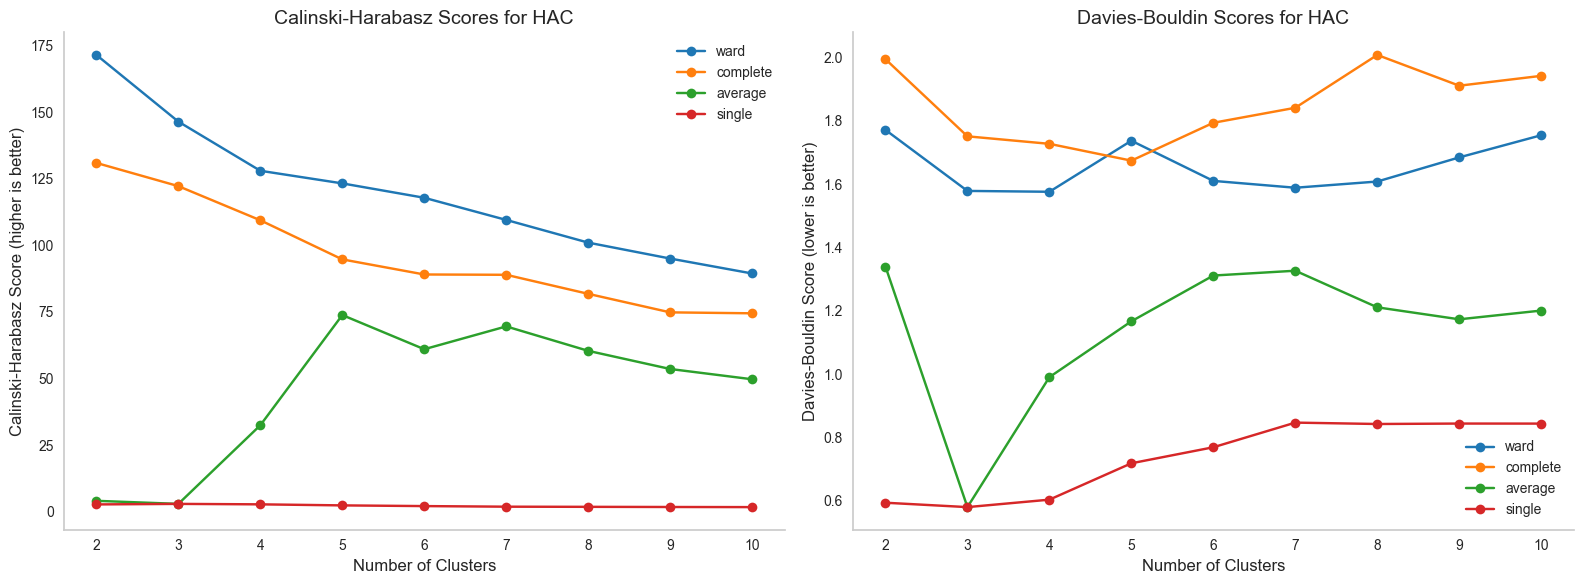

In [85]:
plot_hac_metrics(data)

<div class="alert alert-block alert-info">
Looking at this, I think the average choice is a good option.
</div>

#### 6.3.2.2. Result 1

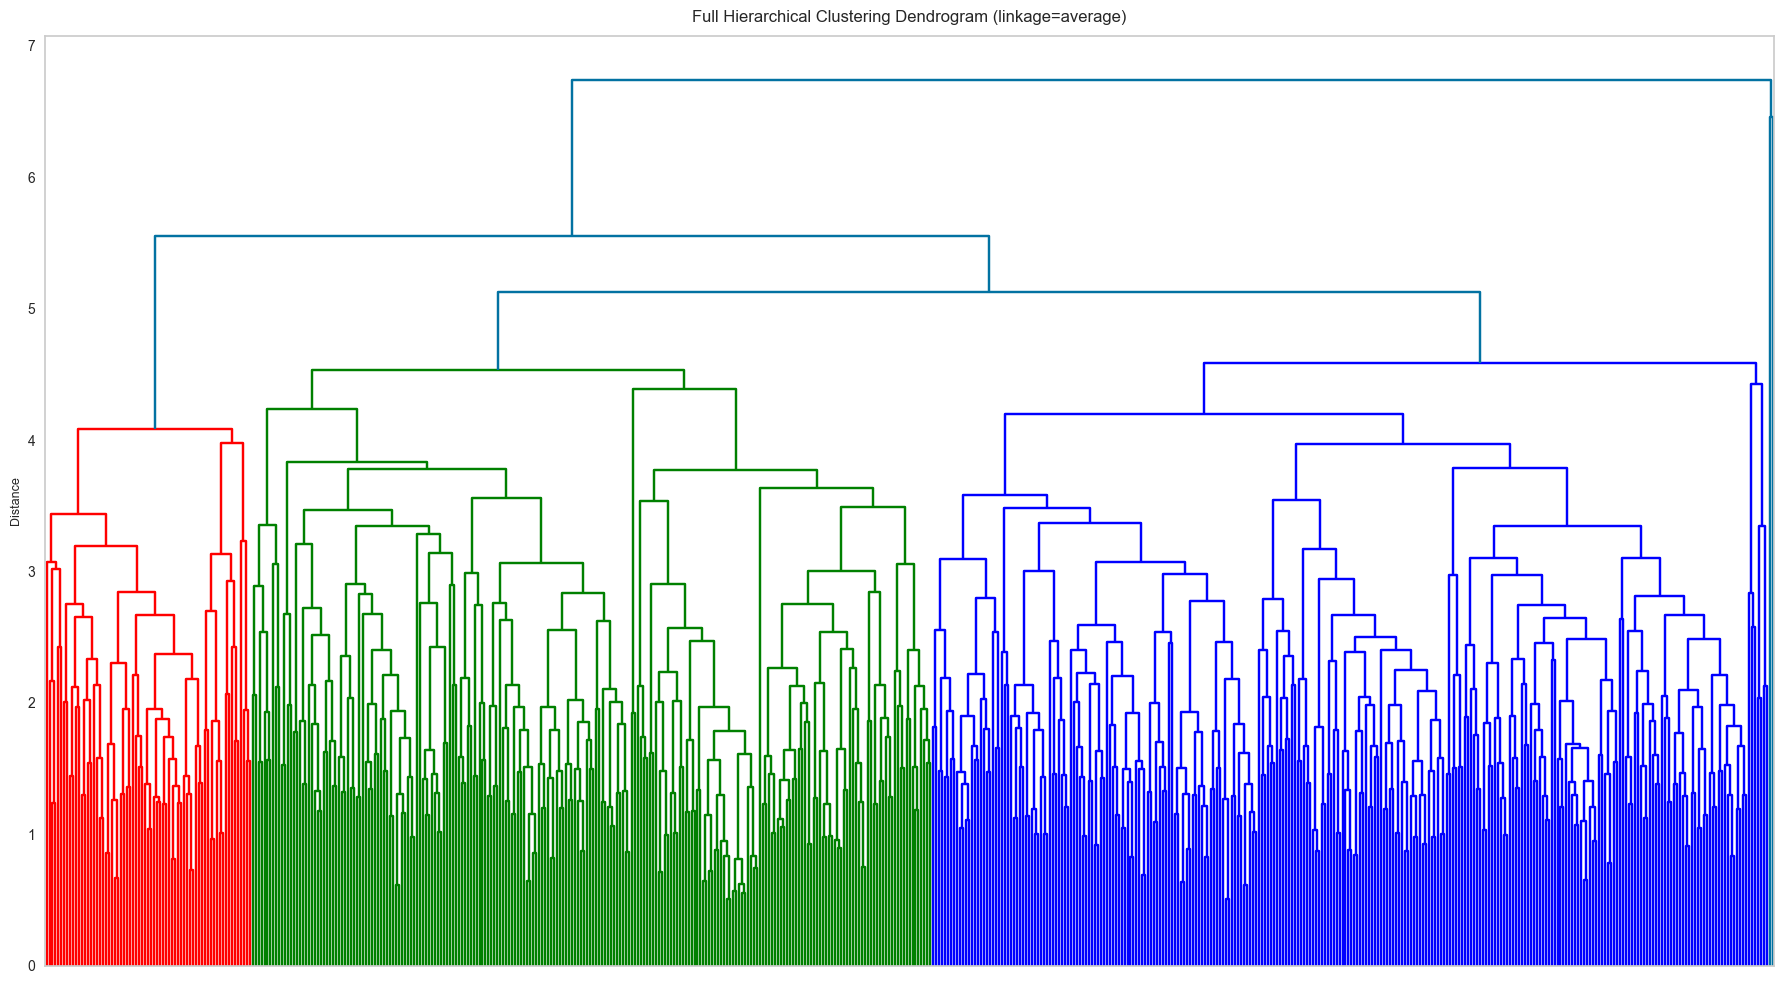

In [86]:
linkage_matrix_data_1 = perform_hac_analysis(data, linkage='average')

Analyzing 5 clusters from hierarchical clustering:
Cluster 0: 69 samples
Cluster 1: 228 samples
Cluster 2: 280 samples
Cluster 3: 1 samples
Cluster 4: 1 samples


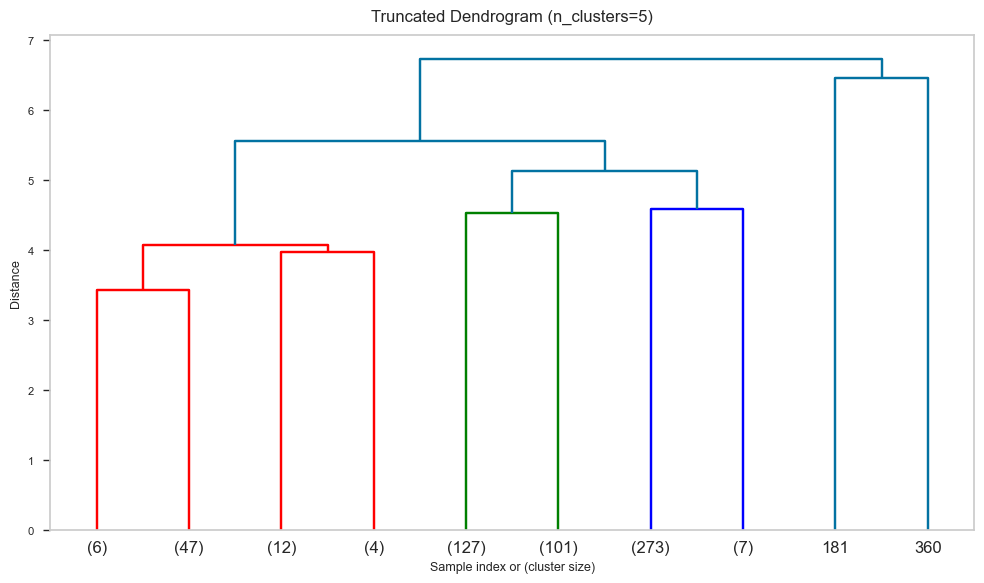

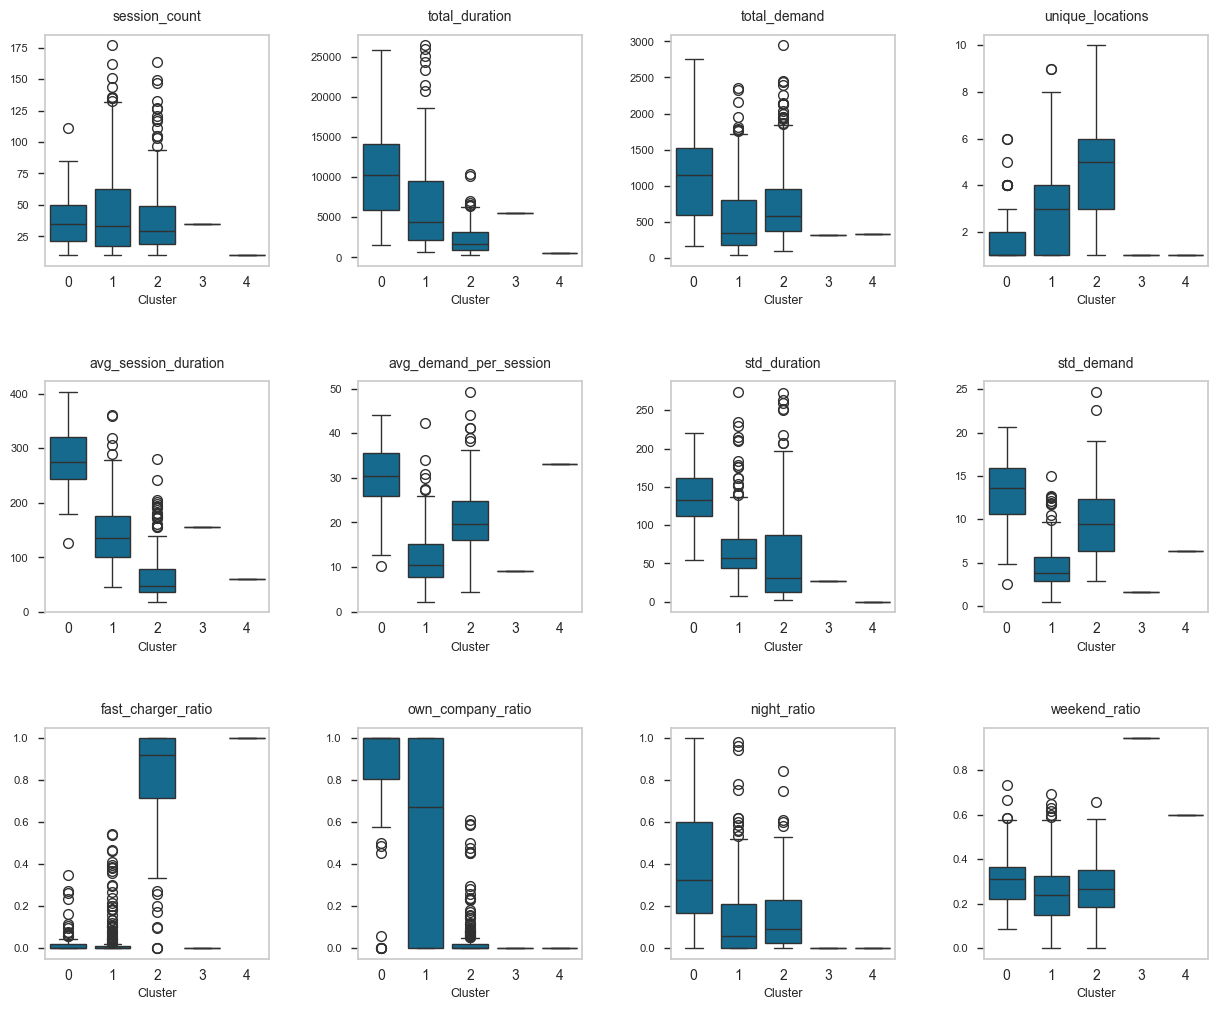

In [87]:
hac_data_cluster_results_1 = analyze_hac_clusters(linkage_matrix_data_1, n_clusters=5)

Result Interpretation:

* Cluster 0 - "Long-Duration Loyalists": Moderate session frequency with highest average session duration and demand per session. Strong company loyalty with minimal fast charger usage. Shows highest variability in charging patterns (highest std_duration and std_demand) with moderate night charging.

* Cluster 1 - "Balanced Moderate Users": Moderate session count and duration with balanced demand. Moderate company loyalty with minimal fast charger usage. Shows consistent charging patterns across diverse locations.

* Cluster 2 - "Fast-Charging Location Explorers": Moderate session count with highest location diversity. Distinguished by highest fast_charger_ratio (~0.9) but lowest company loyalty. Shorter charging sessions with moderate demand variability.

* Cluster 3, 4: Outliers

#### 6.3.2.3. Result 2

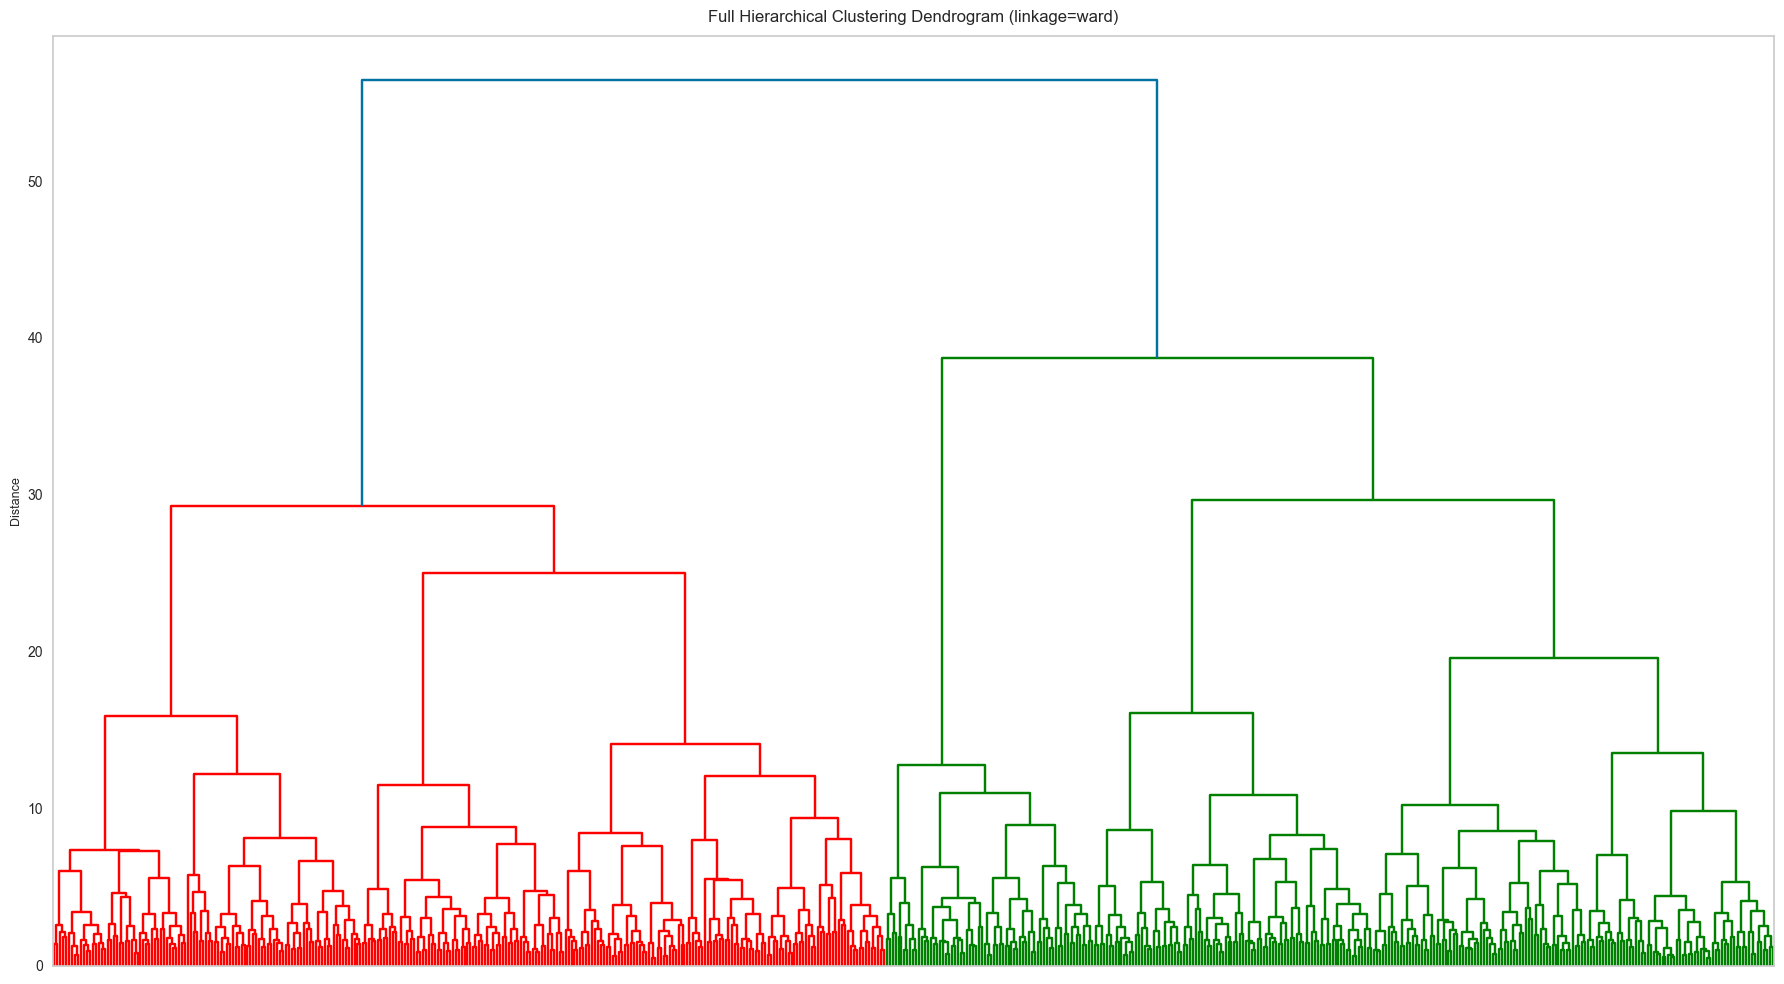

In [88]:
linkage_matrix_data_2 = perform_hac_analysis(data, linkage='ward')

Analyzing 3 clusters from hierarchical clustering:
Cluster 0: 280 samples
Cluster 1: 70 samples
Cluster 2: 229 samples


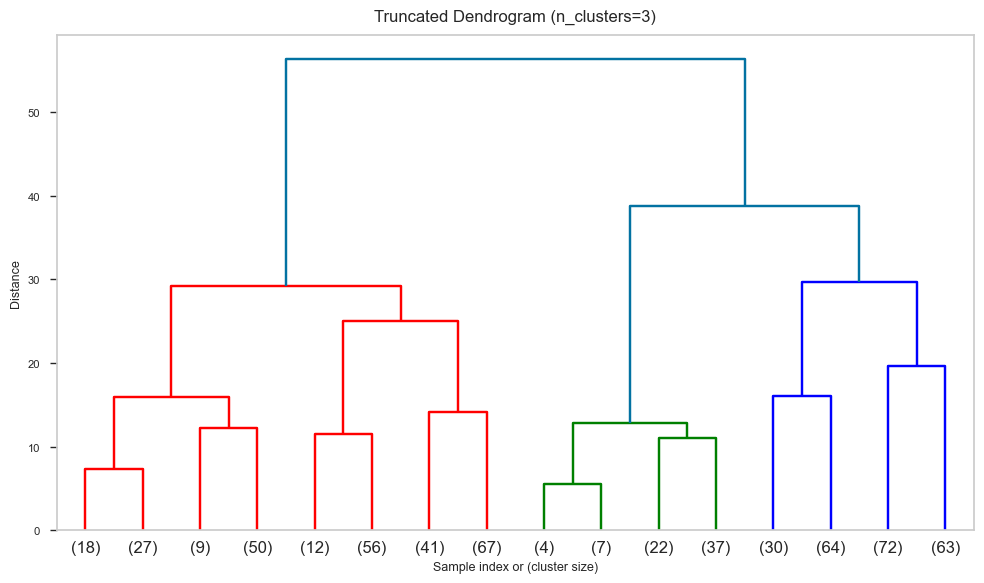

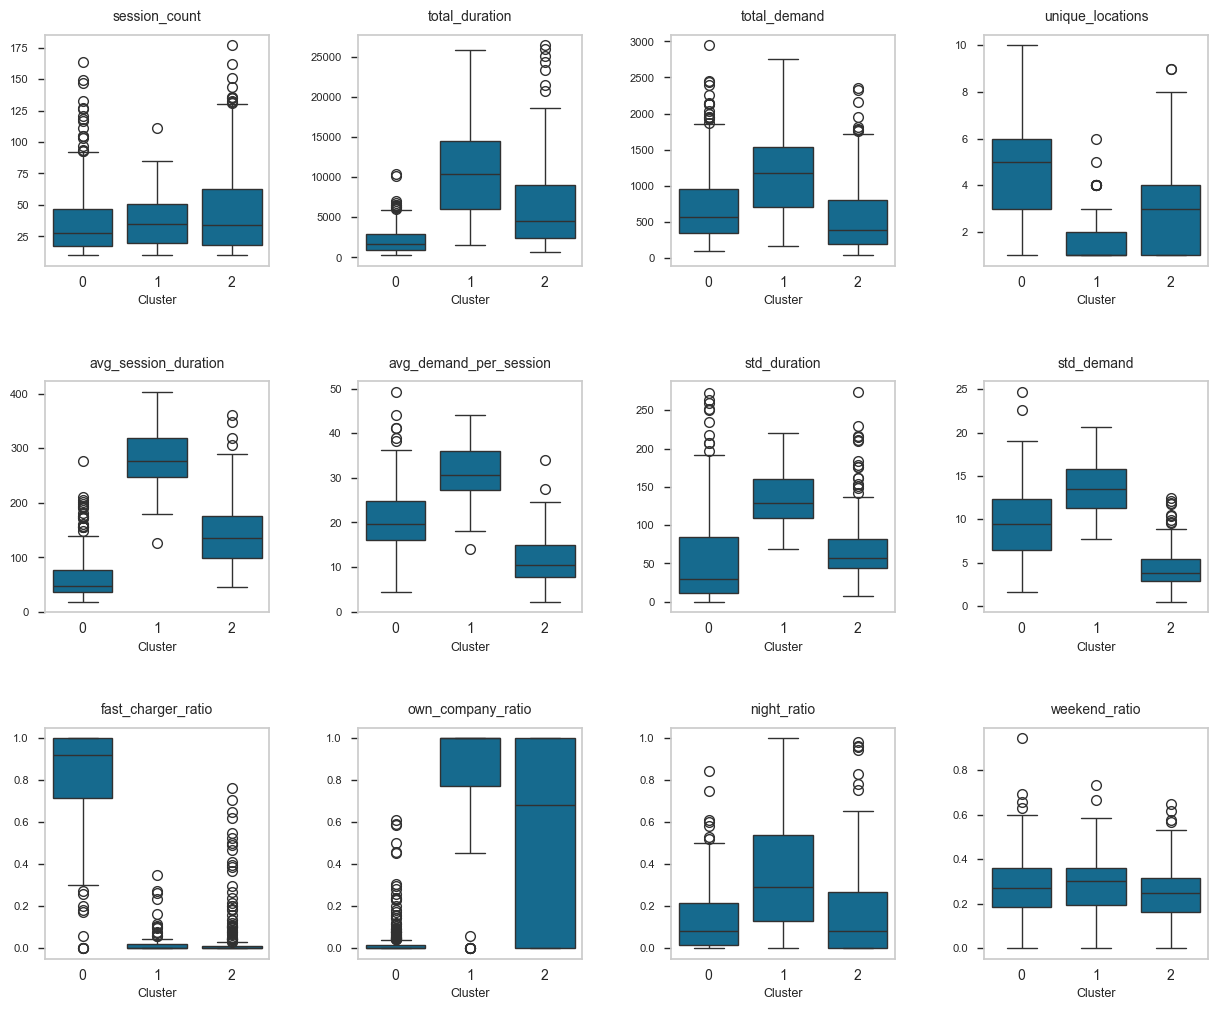

In [89]:
hac_data_cluster_results_2 = analyze_hac_clusters(linkage_matrix_data_2, n_clusters=3)

Result interpretation:

* Cluster 0 - "Quick-Charge Specialists": Lowest total duration despite moderate session count. Distinguished by highest fast_charger_ratio (~0.9) but lowest company loyalty. Short charging sessions (lowest avg_session_duration) with high location diversity.

* Cluster 1 - "Long-Duration Premium Users": Moderate session frequency with highest total duration, demand, and average session duration. Strong company loyalty with minimal fast charger usage. Shows highest variability in demand (highest std_demand) and highest nighttime usage.

* Cluster 2 - "High-Volume Loyal Users": Highest session count with moderate duration and demand. Strong company loyalty (highest own_company_ratio) with minimal fast charger usage. More consistent charging patterns than Cluster 1 with moderate location diversity.

### 6.3.3. data_pca

#### 6.3.3.1. Find optimal linkage

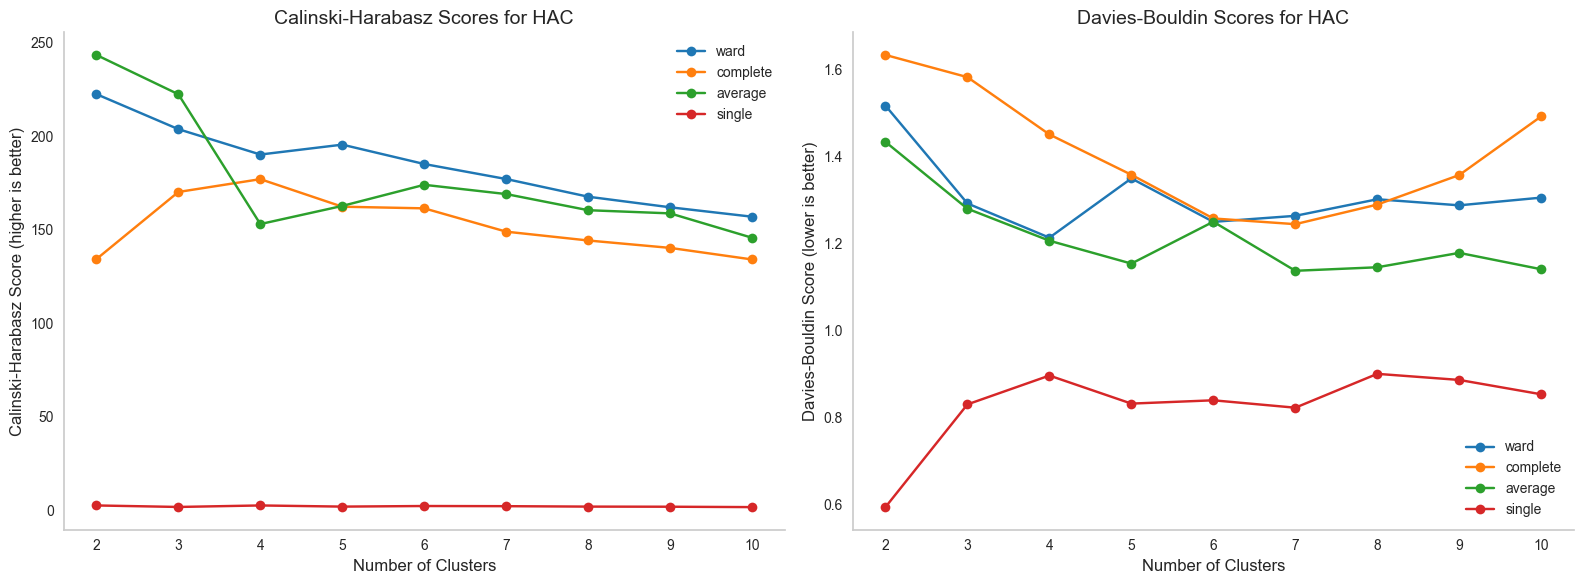

In [90]:
plot_hac_metrics(data_pca)

<div class="alert alert-block alert-info">
Looking at this, I think the average choice is a good option.
</div>

#### 6.3.3.2. Result 1

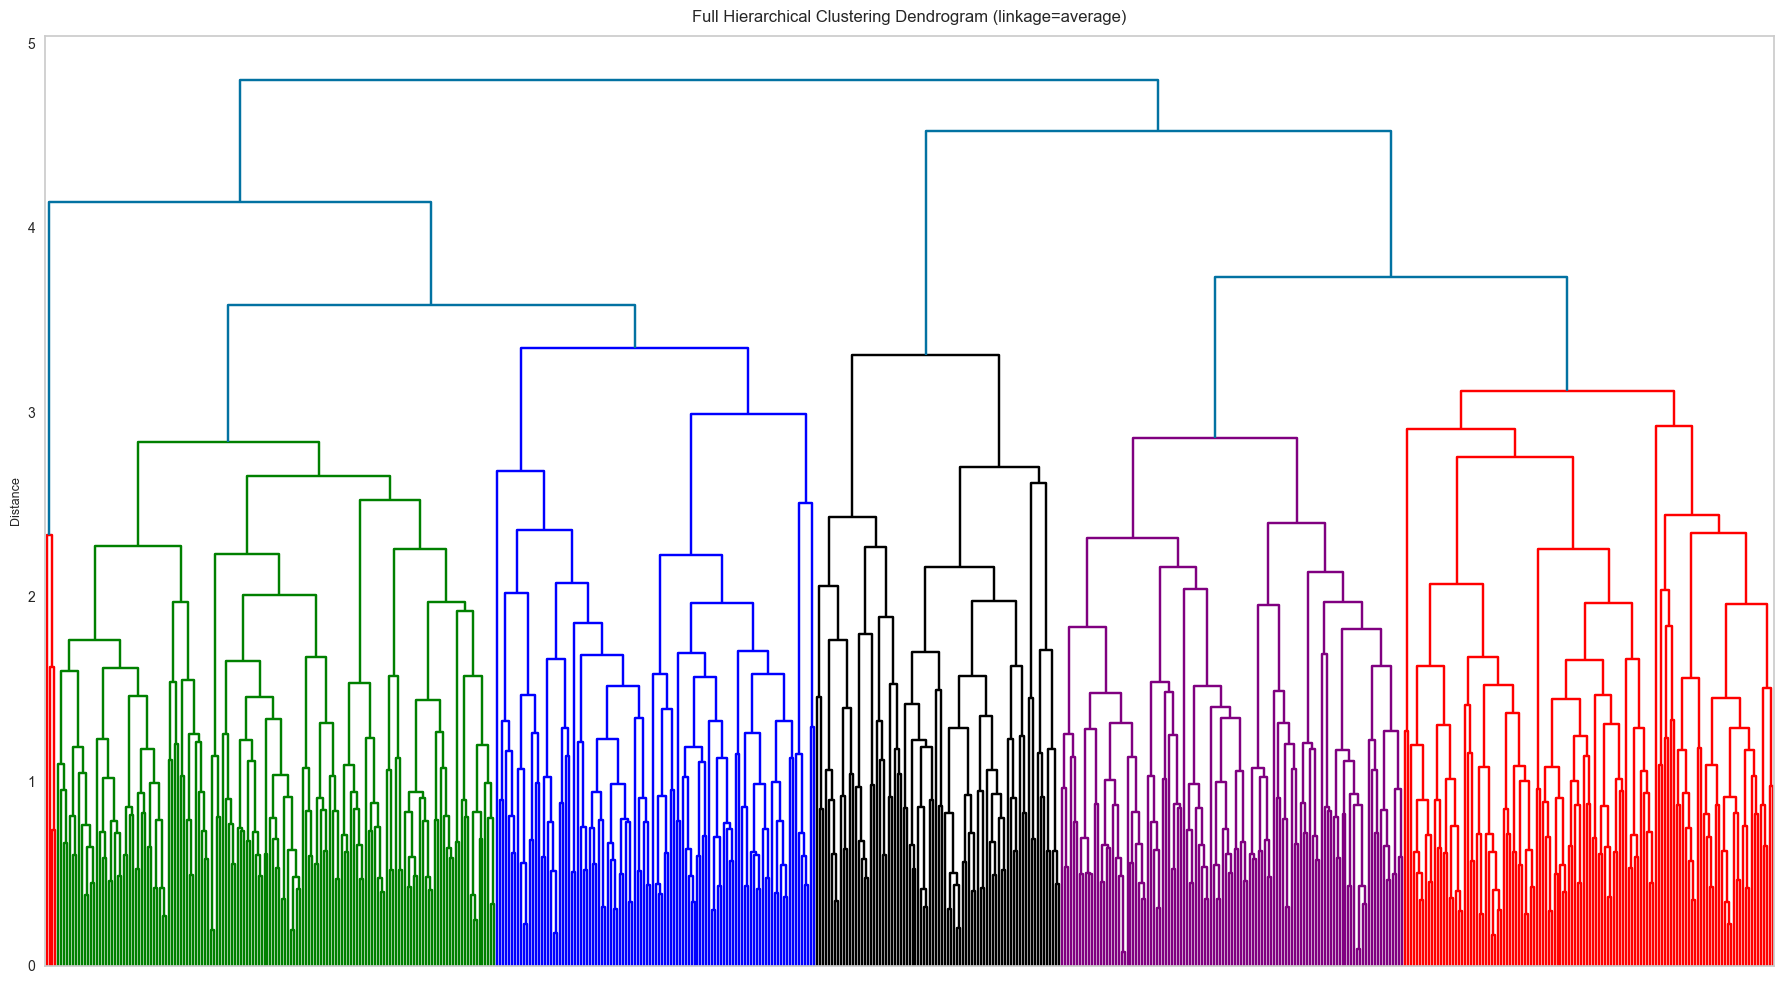

In [91]:
linkage_matrix_data_pca_1 = perform_hac_analysis(data_pca, linkage='average')

Analyzing 3 clusters from hierarchical clustering:
Cluster 0: 258 samples
Cluster 1: 82 samples
Cluster 2: 239 samples


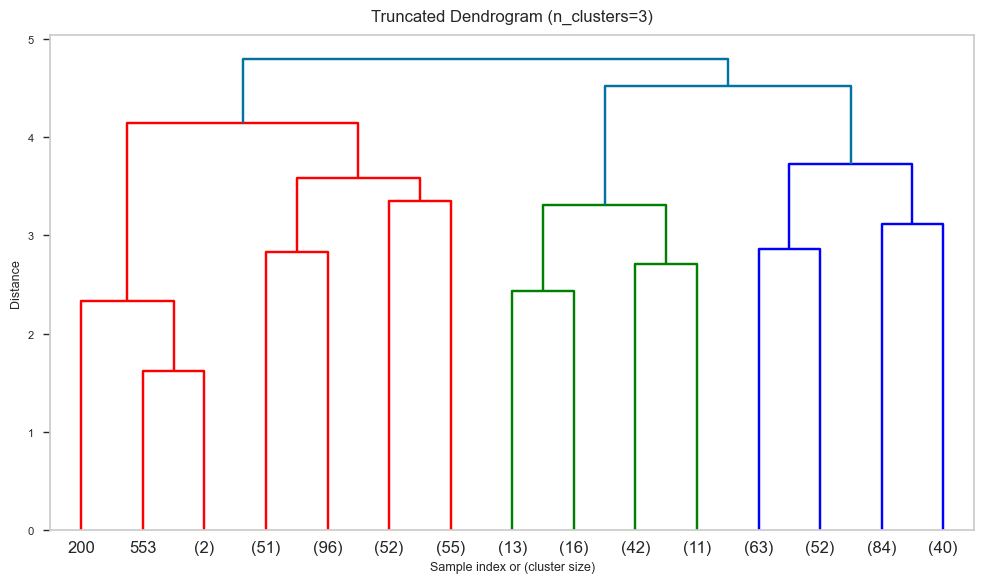

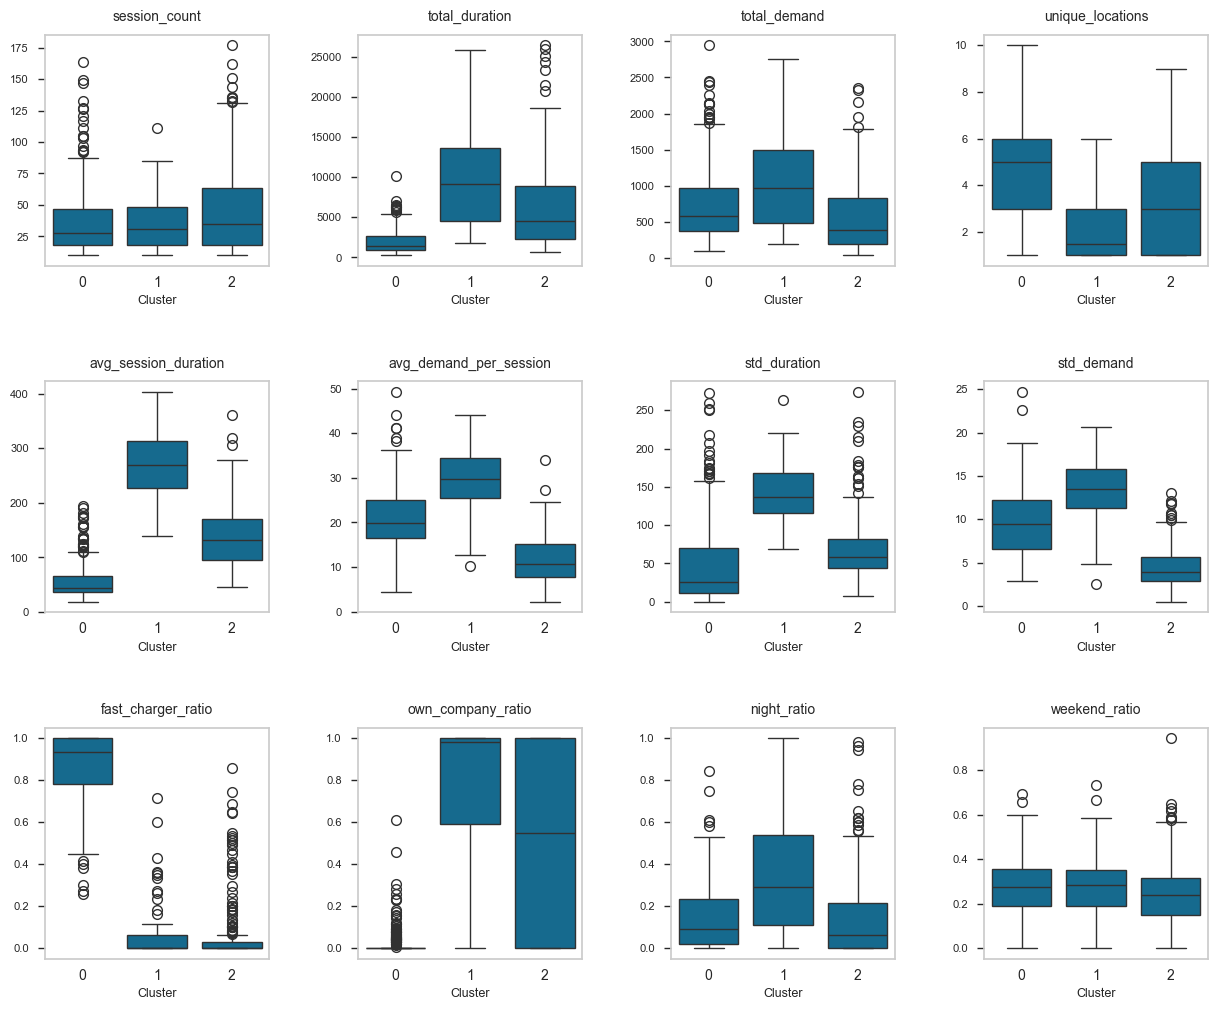

In [92]:
hac_data_pca_cluster_results_1 = analyze_hac_clusters(linkage_matrix_data_pca_1, n_clusters=3)

Result interpretation:

* Cluster 0 - "Fast-Charging Nomads": Moderate session count with shortest total duration. Distinguished by highest fast_charger_ratio (~0.9) but lowest company loyalty. Short charging sessions (lowest avg_session_duration) with high location diversity and consistent charging patterns.

* Cluster 1 - "Premium Long-Duration Users": Moderate session frequency with highest total duration, demand, and average session duration. Strong company loyalty with minimal fast charger usage. Shows highest variability in demand (highest std_demand) and highest nighttime usage ratio.

* Cluster 2 - "High-Volume Loyal Users": Highest session count with moderate duration and demand. Strong company loyalty (highest own_company_ratio) with minimal fast charger usage. More consistent charging patterns than Cluster 1 with moderate location diversity.

#### 6.3.3.2. Result 2

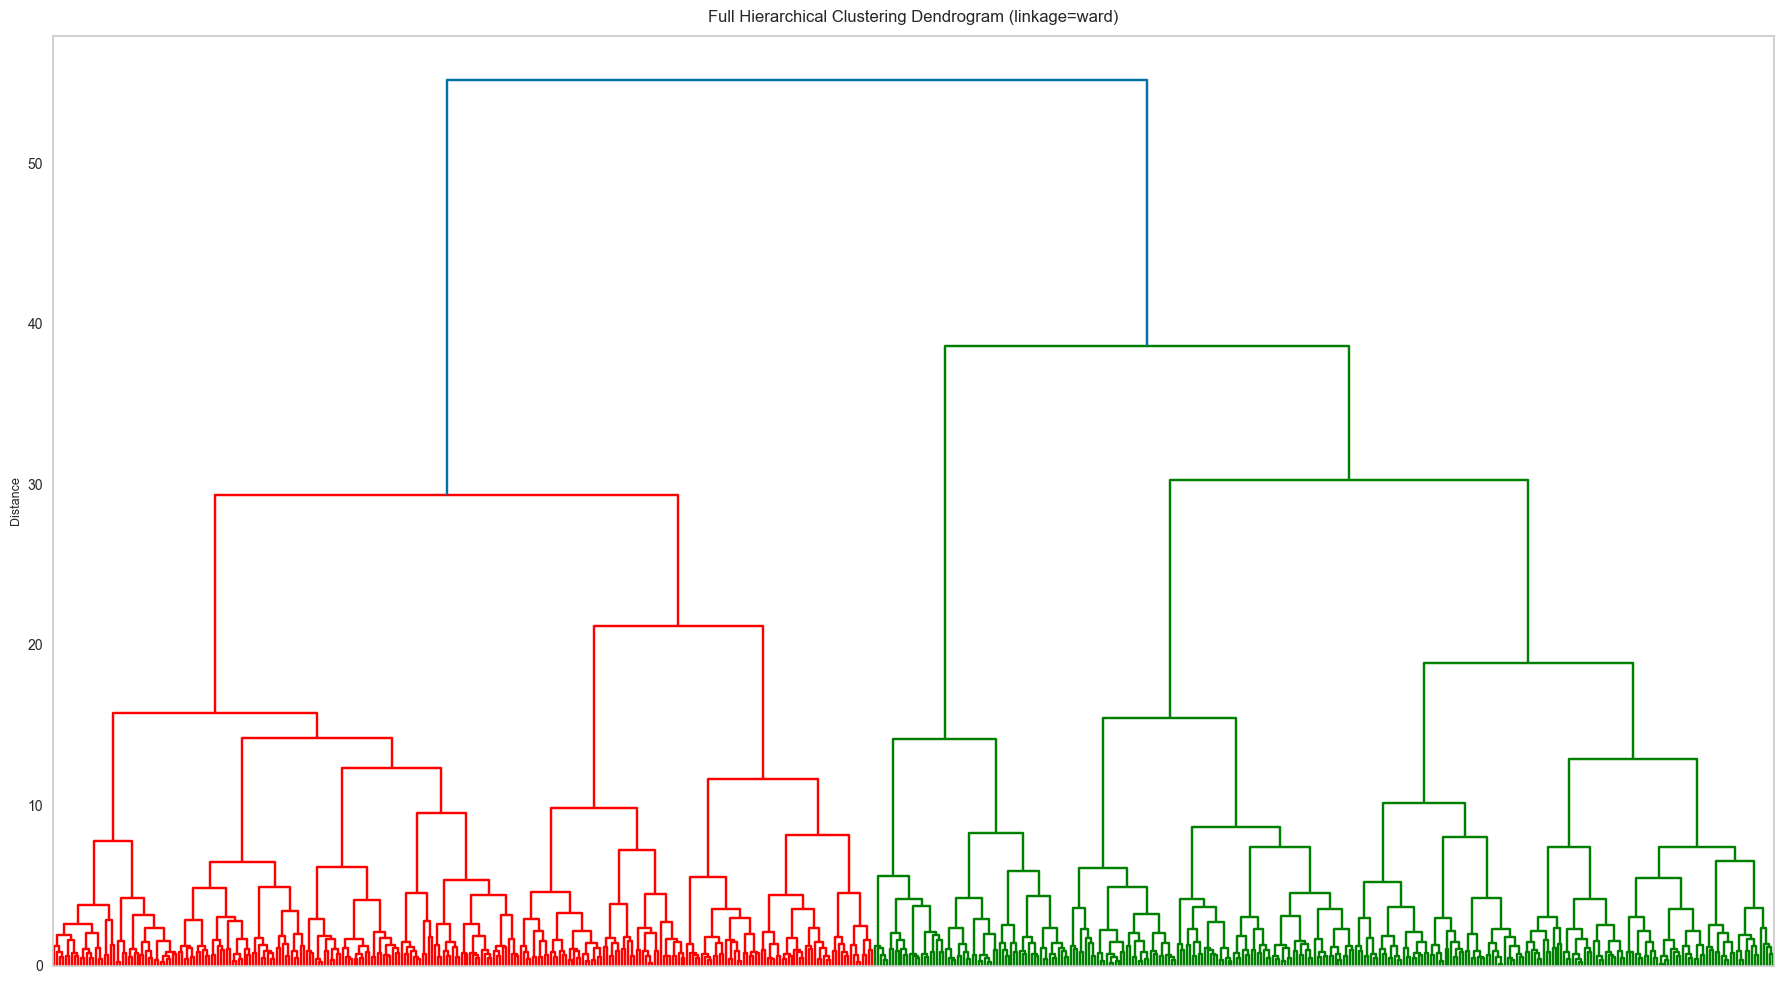

In [93]:
linkage_matrix_data_pca_2 = perform_hac_analysis(data_pca, linkage='ward')

Analyzing 3 clusters from hierarchical clustering:
Cluster 0: 276 samples
Cluster 1: 66 samples
Cluster 2: 237 samples


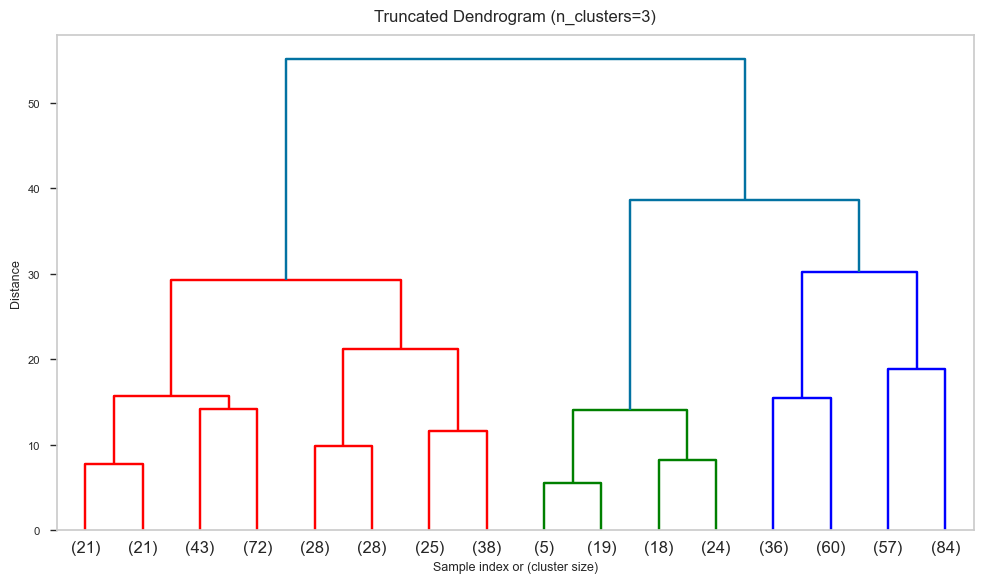

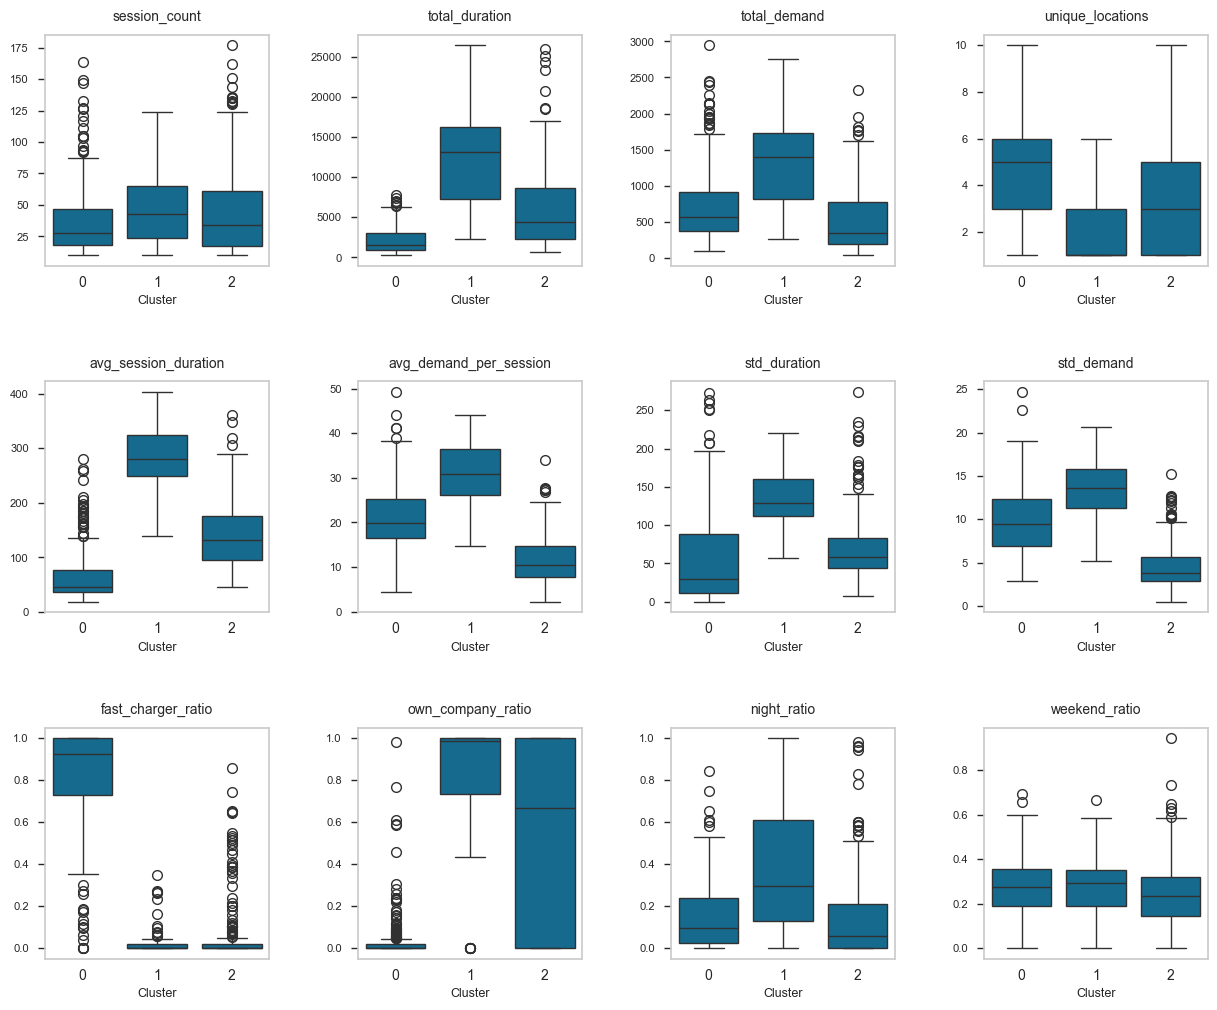

In [94]:
hac_data_pca_cluster_results_2 = analyze_hac_clusters(linkage_matrix_data_pca_2, n_clusters=3)

Result Interpretation:

* Cluster 0 - "Fast-Charging Explorers": Moderate session count with shortest total duration. Distinguished by highest fast_charger_ratio (~0.9) but lowest company loyalty. Short charging sessions (lowest avg_session_duration) with high location diversity and consistent charging patterns.

* Cluster 1 - "Premium Duration Loyalists": Moderate session frequency with highest total duration, demand, and average session duration. Strong company loyalty with minimal fast charger usage. Shows highest variability in demand (highest std_demand) and highest nighttime usage ratio.

* Cluster 2 - "Frequent Balanced Users": Highest session count with moderate duration and demand. Strong company loyalty (highest own_company_ratio) with minimal fast charger usage. More consistent charging patterns than Cluster 1 with moderate location diversity.

# 7. Early Conclusions

* Overall, all defined clusterings don't exhibit a strong structure, but patterns become more visible when examining the boxplots. This suggests the potential for promising results.

* Among the three clustering methods, OPTICS was the only one capable of detecting significant noise and establishing clearer boundaries. 

* Meanwhile, Kmeans++ and HAC provided reasonable clustering results, displaying some visible characteristics while attempting to assign each user to the most suitable group.